<a id='beginning_CRVA'></a>
# Climate Risk and Vulnerability Analysis
This notebook helps you download and visualize climate data to perform Climate Risk and Vulnerability analyses

## Usage
this is how to use this script

1. [Define user input](#user_input)
2. [Run wanted climate variables](#climate_variables)
    1. [Atmosphere's climate variables](#atmosphere_climate_variables)
    2. [Land climate's variables](#land_climate_variables)
    3. [Hydrosphere's climate variables](#hydrosphere_climate_variables)
    4. [Second effect's climate variables](#second_effect_climate_variables)
3. [Export data](#Export)

## Input data

* [Shapefile with project location(s) as points or polygon](#load_shapefile)
* List of variables
* List of SSP's
* List of time horizons

## [Climate variables](#climate_variables)
### [Atmosphere's climate variables](#atmosphere_climate_variables)
* [Precipitation](#worldbank)
* [Temperature](#worldbank)
* [Wind](#wind)
* [Humidity](#humidity)
* [Solar radiation](#solar_radiation)
* Air quality deterioration
### [Land's climate variables](#land_climate_variables)
* [Landslides](#landslides)
* Coastal erosion
* Soil erosion
* Soil salinity
### [Hydrosphere's climate variables](#hydrosphere_climate_variables)
* [Relative sea level rise](#relative_sea_level_rise)
* [Seawater temperature](#sea_water_temperature)
* [Water availability](#water_availability)
* floods (fluvial)
* floods (coastal)
* forest fires
### [Second effects of climate variables](#second_effect_climate_variables)
* Storms
* Dust storms
* Wildfire
* Urban heat island
* Growinf season length
* [cyclone risk](#cyclone_risk)



* earthquakes (not climate related)

## Climate impacts
* calculate impact on yields

## [Climate change information concerning the projects in the study area](#climate_change_info_for_each_project_in_study_area)


## Contact

rapy@cowi.com


<a id='user_input'></a>
## User inputs

[Home](#beginning_CRVA)

In [1]:
#User inputs
import os.path


#project locations (shapefile with location of elements to evaluate)
data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#data_folder=os.path.join(os.pardir,'dataset')
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
project_id='Name' #name of column used as id

#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')

#output folder
#out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Scripts\outputs'
out_path=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs'
out_path_database=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)


#### Year of study
#IDEA IS TO GIVE POSSIBILITY FOR THE USER TO CHOOSE DEPENDING on PROJECT (could choose on year or a period but precise period make more sense)
#SET by default for the moment

first_year = 2025 # start year included
last_year = 2026 # last year included


# For data coming from copernicus, historical data are commonly 1850-2005

## Import python packages

C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_84700\3509116232.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


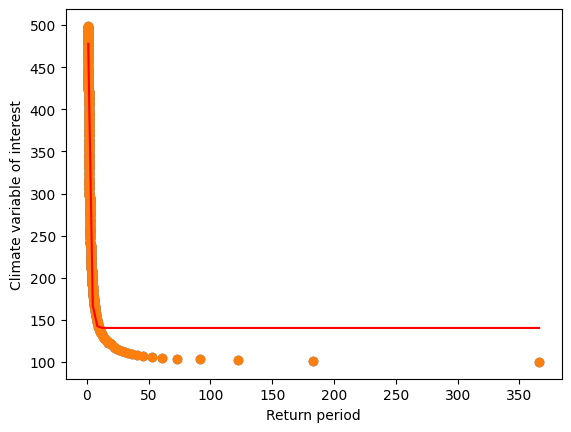

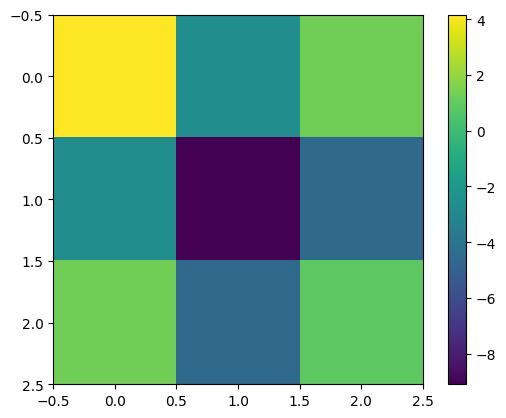

In [2]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray as xr
import os
import os.path
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset
import csv #REMOVE ? not in use ?
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import shutil # to move folders
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings
#import io
import cdsapi # for copernicus function
import datetime # to have actual date
from osgeo import gdal, ogr, osr # in order to convert shp in raster
from geopandas import GeoDataFrame
from shapely.geometry import Point
from matplotlib.lines import Line2D

# to perform bias correction
from bias_correction import BiasCorrection, XBiasCorrection
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gamma, norm
from scipy.signal import detrend

# import functions and class defined in another file named FunctionsAndClass
## Functions
from FunctionsAndClass import copernicus_data
from FunctionsAndClass import year_copernicus
from FunctionsAndClass import date_copernicus
from FunctionsAndClass import csv_copernicus
from FunctionsAndClass import Display_map
from FunctionsAndClass import read_cckp_ncdata
from FunctionsAndClass import get_cckp_file_name
from FunctionsAndClass import Display_map_projects
from FunctionsAndClass import register_data # import to test
from FunctionsAndClass import find_column_name # import to test
from FunctionsAndClass import search_for_nc # import to test
from FunctionsAndClass import try_download_copernicus # import to test


## Class
from FunctionsAndClass import calendar
from FunctionsAndClass import copernicus_elements
from FunctionsAndClass import map_elements

<a id='load_shapefile'></a>
## Load shapefiles and plot

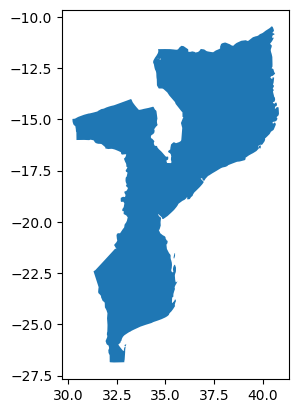

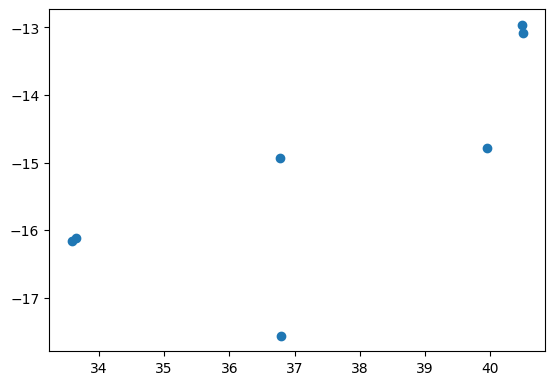

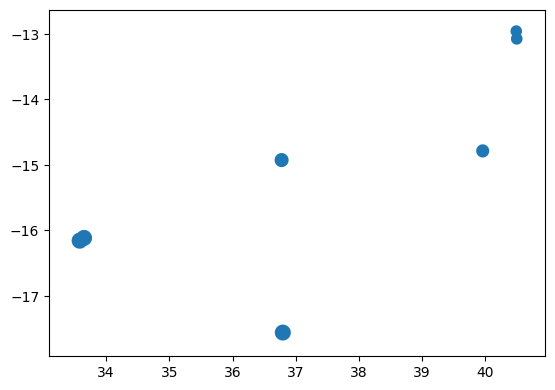

In [3]:
#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 


#show table
projects[[project_id]]

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
area_projects = [lat_projects - 5, lat_projects+5, lon_projects-5,lon_projects+5] # list format
# 5 degres trop grand 
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

area = [lat_min_wanted, lon_min_wanted, lat_max_wanted,lon_max_wanted,] # used to download from copernicus

### YEAR
year = np.arange(first_year,(last_year+1),1) # create vector of years
year_str = [0]*len(year) # create initiale empty vector to convert years in int
index = np.arange(0,len(year)) # create vector of index for year
i = 0 # initialize index
for i in index: # convert all the date in string format
    year_str[i]=str(year[i])

start_date = "01-01-"+year_str[0] # string start date based on start year
stop_date = "31-12-"+year_str[len(year)-1] # string stop date based on stop year
dates = pd.date_range(start_date,stop_date) # vector of dates between start date and stop date
index_dates = np.arange(0,len(dates)) # vector containning index o dates vector

In [ ]:
lat_min_wanted

In [ ]:
lon_min_wanted

In [ ]:
lat_max_wanted

In [ ]:
lon_max_wanted

In [ ]:
base = study_area.plot(color='white', edgecolor='black')
projects.plot(ax=base, marker='o', color='blue', markersize=5);

In [ ]:
library(NASAaccess)

NEX_GDDP_CMIP6(Dir = "./NEX_GDDP_CMIP6/", 
               watershed = shape_path,
              dem_path,  
              start = "2060-12-1", 
              end = "2060-12-3",
              model = 'ACCESS-CM2', 
              type = 'tas', 
              slice = 'ssp245')

In [ ]:
import requests

filepath = 'https://ds.nccs.nasa.gov/thredds2/fileServer/AMES/NEX/GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/hurs/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc'


In [ ]:
import csv
import os
import hashlib
import logging
from subprocess import run as srun
from urllib.parse import urlparse
logging.basicConfig(level=logging.INFO)
def download(uri, ofile, md5):
    srun(['curl', '-s', '-o', ofile, uri], capture_output=True, check=True) # without curl, file is corrupted
    md5dld = str(hashlib.md5(open(ofile, 'rb').read()).hexdigest())
    if md5 != md5dld:
        logging.warning("%s != %s", md5, md5dld)
    logging.info("uri %s (%s == %s) : %s", uri, md5, md5dld, ofile)

with open('gddp-cmip6-thredds-fileserver.csv') as index:
    fobjects = csv.reader(index)
    next(fobjects)
    next(fobjects)
    next(fobjects)
    next(fobjects)
    for objs in fobjects:
        md5, uri = [o.strip() for o in objs]
        prsout = urlparse(uri)
        ofile = os.path.split(prsout.path)[1]
        download(uri, ofile, md5)

In [ ]:
os.path.isfile('hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc')

In [ ]:
Dataset("hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc", format='NETCDF4_CLASSIC')

In [ ]:
import gc
import os

import click
import pandas as pd
import xarray as xr
from xsd.bcsd import bcsd, disagg



<a id='climate_variables'></a>
# Climate variables

[Home](#beginning_CRVA)

<a id='atmosphere_climate_variables'></a>
# ATMOSPHERE

[Home](#beginning_CRVA)

<a id='worldbank'></a>
## World Bank Climate knowledge portal, Precipitation and Temperature - Atmosphere
data source: https://climateknowledgeportal.worldbank.org/download-data

List of different variables:

### Precipitation 
* return period of current 50 and 100 year event
* yearly average precipitation
* seasonal average precipitation - OR MONTH? i word documnet: average dry season precipitation 
* maximum precipitation in one day - NOT REALLY, instead "Average of the largest daily precipitation amount" rx1day 
* maximum precipitation in five days - NOT REALLY, instead "Average of the largest 5-day consecutive precipitation amount".
* FORSLAG: Could also include: precipitation amount from very wet days/ days >50mm. eg. 

### Temperature
* Yearly mean temperature (average) - tas 
* Number of hot days >40 degrees C (average)
* Number of hot days >35 degrees C (average) 
* Maximum of daily max-temperature (per year) -txx
* Average of maximum temperature (daily??) - tasmax 

### How to use
define 

`variables = {variablename1:{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, variablename2:...}`

where variablename corresponds to a variable name in the cckp, periods include the desired periods, ssps the desired ssp-rcp scenarios, and gcms can be either median, p10, or p90 (50%, 10%, and 90% percentile of ensemble models).

In [ ]:
#Read downloaded precipitation and temperature data
#settings

variables= {
    #Temperature
        #era/cru
            #'climatology-hd35-annual-mean_era':{'periods':['1991-2020']},
            'climatology-hd40-annual-mean_era':{'periods':['1991-2020']},
            'climatology-tasmax-annual-mean_era':{'periods':['1991-2020']}, 
            'climatology-tas-annual-mean_era':{'periods':['1991-2020']},
            'climatology-tasmax-annual-mean_cru':{'periods':['1991-2020']}, 
        #realtime
            'climatology-hd40':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'anomaly-hd40':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median']},
            #'anomaly-hd35':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            #'anomaly-tasmax':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, 
            'anomaly-txx':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, #txx=maximum of daily max temperature
            'climatology-txx':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'anomaly-tas':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-tas':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, #data not downloaded 
    #Precipitation
       #era/cru
            #'climatology-r50mm-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-rx1day-monthly-mean_era_monthly':{'periods':['1991-2020']},
            'climatology-rx1day-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-pr-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-pr-monthly-mean_era_monthly':{'periods':['1991-2020']},
            'climatology-pr-annual-mean_cru':{'periods':['1991-2020']},
        #realtime
            'frp100yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039','2035-2064'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, 
            'frp50yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-rx5day-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-rx1day-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-monthly-mean_cmip6_monthly':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-seasonal-mean_cmip6_seasonal':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'changefactorfaep100yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            #'anomaly-pr-monthly-mean_cmip6_monthly':{'periods':['2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}
            }
       ## 'timeseries-rx1day':{'periods':['2015-2100'],'ssps':['ssp245'],'gcms':['median']} # Den kan ikke læse den - brokker sig over Dimension time=0. 
       
#Create multi index for cckp_output
idx=pd.IndexSlice
mindex=[]
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']:
            mindex.append((var,period,None,None))
        else:
            for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        mindex.append((var,period,ssp,gcm))
mindex=pd.MultiIndex.from_tuples(mindex, names=['variable', 'period','ssp','gcm'])
#cckp_output=pd.DataFrame(index=projects[project_id],columns=mindex)
cckp_output=pd.DataFrame(index=mindex,columns=projects[project_id])

#read data from cckp and spatial statistics
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']: # for era/cru data
            varname='_'.join((var,period))
            data_path=get_cckp_file_name(var,period=period)
            if os.path.exists(data_path):
                data=read_cckp_ncdata(data_path)
                stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                projects[varname]=stats
                #cckp_output.loc[:,idx[var,period,:,:]]=stats.values
                cckp_output.loc[idx[var,period,:,:],:]=stats.T.values
            else:
                print(data_path,"not found")
                projects[varname]='not found'
        elif period not in ['1991-2020']: #for realtime data 
                for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        varname='_'.join((var,period,ssp,gcm))
                        data_path=get_cckp_file_name(var,ssp=ssp,period=period,gcm=gcm)
                        if os.path.exists(data_path):
                            data=read_cckp_ncdata(data_path)
                            stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                            projects[varname]=stats
                            #cckp_output.loc[:,idx[var,period,ssp,gcm]]=stats.values
                            cckp_output.loc[idx[var,period,ssp,gcm],:]=stats.T.values
                        else:
                            print(data_path,"not found")
                            projects[varname]='not found'


#plot, show #ADD enlarge the clip + something wierd with nodata value
cckp_output.to_csv('outputs/csv/cckp_output.csv')
projects[[project_id,varname]].head()

fig, ax = plt.subplots()
precip = rioxarray.open_rasterio(data)
precip_clip = precip.rio.clip(study_area.geometry, study_area.crs, drop=True)
precip_clip.plot(ax=ax)
projects.plot(ax=ax)

#close
precip.close()

<a id='wind'></a>
## Wind Speed

Daily wind speed, historical and projected.

Data source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

In [ ]:
### Extraction of Near-surface wind speed data
global_variable = 'Wind'
name_variable = 'near_surface_wind_speed'

#### Historical data for wind speed

In [ ]:
(year_historical, year_str_historical, index_historical)=year_copernicus(1950,2014)
temporal_resolution = 'daily'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
(Wind_historical,period_historical) = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path, name_variable,'sfcWind',area)    

#### Projection data for wind speed

In [ ]:
(year, year_str, index)=year_copernicus(2098,2099)
temporal_resolution = 'daily'

#(df,period) = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,'sfcWind',projects.Name[0],[area_projects[0][0],area_projects[1][0],area_projects[2][0],area_projects[3][0]])

# df with separation of different projects
# separate dataframe function
NameProjects=list(projects['Name'])
#NameProjects.remove('PT1_Pemba - Breidge Paquite')

# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
k=0
Temp=[]
for name_project in NameProjects:
    (df,period) = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,name_project,[area_projects[0][k],area_projects[1][k],area_projects[2][k],area_projects[3][k]])  
    Temp.append(df)
    k+=1
# last parameter is the area of one project, elements are fisrt col (min lat = 0, max lat = 1, min lon = 0, max lon = 1), then line (each ligne is coordinates for a project)

In [ ]:
(year, year_str, index)=year_copernicus(2098,2099)
temporal_resolution = 'daily'
### does not work for PT1_Pemba - Breidge Paquite. When extract all, try to extract a json file (no need for it I think)
### this makes everything going bad
(df,period) = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,'sfcWind','PT_ Dumping Site',[area_projects[0][6],area_projects[1][6],area_projects[2][6],area_projects[3][6]])

In [ ]:
projects['Name']

In [ ]:
df

In [ ]:
### BOXPLOTS


df_reordered2 = df.reorder_levels(['Experiment', 'Model', 'Latitude', 'Date']) # reordering to ...
df_reordered2_mean=df_reordered2.groupby(level=[0,1,2],axis=0,group_keys=True).mean()
numpy_array = df_reordered2_mean.loc['ssp1_2_6','access_cm2'].values
numpy_array=numpy_array.flatten() # make the array a vector to use it in boxplot function
numpy_array1 = numpy_array[~np.isnan(numpy_array)]

numpy_array = df_reordered2_mean.loc['ssp1_2_6','awi_cm_1_1_mr'].values
numpy_array=numpy_array.flatten() # make the array a vector to use it in boxplot function
numpy_array2 = numpy_array[~np.isnan(numpy_array)]

numpy_array = df_reordered2_mean.loc['ssp1_2_6','bcc_csm2_mr'].values
numpy_array=numpy_array.flatten() # make the array a vector to use it in boxplot function
numpy_array3 = numpy_array[~np.isnan(numpy_array)]
# boxplot do not deal with NaN, have to take them out
dict_boxplot = plt.boxplot([numpy_array1,numpy_array2,numpy_array3],notch=True, whis =(10,90),widths = 0.15, patch_artist=True,labels=('access_cm2','awi_cm_1_1_mr','bcc_csm2_mr'))#,labels = 'access_cm2')# ... present boxplot over the period for each models
# this functions returns varius parameters of the boxplot in the dict_boxplot. This funcitons also returns an image of it
# here, numpy_array is a vector. But can also include array with several columns. Each columns will have a boxplot
# 'notch' is true to enhance part where the median is
# 'whis' is the percentile value for the whiskers, every data out of the range indicted by those 2 floats are represented as points
# 'widths' determine width of the boxes
# 'patch_artist' colors the boxplots
# 'labels' gives a name to every column included in the data part
str = 'Distribution of the average daily wind speed for different models \nfor the year '+period+' and under scenario ssp1_2_6'
title_png = 'Boxplot_models_ssp1_2_6'
plt.title(str)
plt.xlabel('Models')
plt.ylabel('Average wind speed m/s')
plt.savefig(os.path.join(out_path,'figures','Boxplots',title_png),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
plt.show()

In [ ]:
#### BOXPLOTS


df_reordered3 = df.reorder_levels(['Experiment', 'Model', 'Latitude', 'Date']) # reordering to ...
df_reordered3_mean=df_reordered3.groupby(level=[0,1,2],axis=0,group_keys=True).mean()
numpy_array = df_reordered3_mean.loc['ssp1_2_6'].values
numpy_array=numpy_array.flatten() # make the array a vector to use it in boxplot function
numpy_array4 = numpy_array[~np.isnan(numpy_array)]
# boxplot do not deal with NaN, have to take them out
dict_boxplot = plt.boxplot(numpy_array4,notch=True, whis =(10,90),widths = 0.15, patch_artist=True,labels=('ssp1_2_6',))# ... present boxplot over the period for each models
# this functions returns varius parameters of the boxplot in the dict_boxplot. This funcitons also returns an image of it
# here, numpy_array is a vector. But can also include array with several columns. Each columns will have a boxplot
# 'notch' is true to enhance part where the median is
# 'whis' is the percentile value for the whiskers, every data out of the range indicted by those 2 floats are represented as points
# 'widths' determine width of the boxes
# 'patch_artist' colors the boxplots
# 'labels' gives a name to every column included in the data part
str = 'Distribution of the average daily wind speed accross models\nfor the year 2099-2100 and under scenario ssp1_2_6'
title_png = 'Boxplot_ssp1_2_6'
plt.title(str)
plt.xlabel('Models')
plt.ylabel('Average wind speed m/s')
plt.savefig(os.path.join(out_path,'figures','Boxplots',title_png),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
plt.show()

<a id='humidity'></a>
## Humidity

Source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

### Relative humidity

Relative humidity of air: amount if moisture it contains compared to the maximum amount of moisture it can have at a specific temperature

### Extraction of Relative humidity data

In [ ]:
global_variable = 'Relative_Humidity'
name_variable = 'near_surface_relative_humidity' # only available on a monthly basis

#### Historical data

In [ ]:
(year_historical, year_str_historical, index_historical) = year_copernicus(1850,2014)
temporal_resolution = 'monthly'

# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Humidity_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path,global_variable, name_variable,area)    

#### Projections

In [ ]:
(year, year_str, index) = year_copernicus(2020,2100)
temporal_resolution = 'monthly'

# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Humidity = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,area)    

<a id='solar_radiation'></a>
## Solar radiation

In [5]:
global_variable = 'Solar_radiation'
# choose of the climate variable from copernicus to represent : choose of surface_downwelling_shortwave_radiation because
# 1. interest for project located at the surface of the Earth
# 2. for most project (for example solar panels), we are interest in radiation going down, not up
# 3. Shortwave radiation are the ones produce by the sun
name_variable = 'surface_downwelling_shortwave_radiation' # only available on a monthly basis

#### Historical data for solar radiation

In [ ]:
(year_historical, year_str_historical, index_historical)=year_copernicus(1850,2016)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Solar_radiation_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path,global_variable, name_variable,area)    

#### Projection for data solar radiation

In [ ]:
## Failed to go the end, separe download and makin one csv for one climate variable with all project, scenario, model and years

(year, year_str, index)=year_copernicus(2016,2099)
temporal_resolution = 'monthly'

Projections_solar_radiation_projects = pd.DataFrame() # create an empty dataframe
for (name_project,k) in zip(projects['Name'],np.arange(0,len(projects['Name']))):
    (df,period) = csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,name_project,[area_projects[0][k],area_projects[1][k],area_projects[2][k],area_projects[3][k]],'CMIP6-copernicus-GCM')  
    Projections_solar_radiation_projects = pd.concat([Projections_solar_radiation_projects,df])
path_for_csv = os.path.join(out_path,'csv','data',name_variable)
Projections_solar_radiation_projects.to_csv('outputs/csv/data/Projections_solar_radiation_projects.csv')

In [ ]:
Future_solar_radiation

In [6]:
(year, year_str, index)=year_copernicus(2015,2099)
temporal_resolution = 'monthly'
name_project = 'CompleteMozambique'

Projections_solar_radiation_country = pd.DataFrame() # create an empty dataframe
(Projections_solar_radiation_country,period) = csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,name_project,area,'CMIP6-copernicus-GCM')  

############################### Project name: CompleteMozambique ###############################
FUNCTION DATAFRAME_COPERNICUS
Test with scenario ssp1_1_9
Test with model access_cm2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:17:32,783 INFO Welcome to the CDS
2023-05-23 09:17:32,784 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 09:17:33,000 INFO Request is queued
2023-05-23 09:17:34,047 INFO Request is failed
2023-05-23 09:17:34,048 ERROR Message: an internal error occurred processing your request
2023-05-23 09:17:34,049 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'ACCESS-CM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:17:34,050 ERROR   Traceback (most recent call last):
2023-05-23 09:17:34,051 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:17:34,052 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:17:34,053 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:17:34,054 ERROR       result = proc(conte

Some parameters are not matching

No value were found for the period and the project tested

Test with model awi_cm_1_1_mr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:17:35,240 INFO Request is failed
2023-05-23 09:17:35,241 ERROR Message: an internal error occurred processing your request
2023-05-23 09:17:35,242 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'AWI-CM-1-1-MR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:17:35,243 ERROR   Traceback (most recent call last):
2023-05-23 09:17:35,244 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:17:35,245 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:17:35,246 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:17:35,247 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:17:35,248 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:17:35,249 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model bcc_csm2_mr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:17:36,425 INFO Request is running
2023-05-23 09:17:37,960 INFO Request is failed
2023-05-23 09:17:37,962 ERROR Message: an internal error occurred processing your request
2023-05-23 09:17:37,964 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'BCC-CSM2-MR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:17:37,965 ERROR   Traceback (most recent call last):
2023-05-23 09:17:37,966 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:17:37,968 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:17:37,969 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:17:37,970 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:17:37,972 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 0

Some parameters are not matching

No value were found for the period and the project tested

Test with model cams_csm1_0
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\cams_csm1_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CAMS-CSM1-0_ssp119_r1i1p1f1_gn_20150116-20991216_v20190708.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\cams_csm1_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CAMS-CSM1-0_ssp119_r1i1p1f1_gn_20150116-20991216_v20190708.nc

 The final path for nc file exists ? True

Registering the data in a dataframe


2023-05-23 09:17:46,310 INFO Welcome to the CDS
2023-05-23 09:17:46,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 09:17:46,433 INFO Request is queued



Value were found for the period and the project tested

Test with model canesm5_canoe
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:17:47,477 INFO Request is failed
2023-05-23 09:17:47,478 ERROR Message: an internal error occurred processing your request
2023-05-23 09:17:47,479 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CanESM5-CanOE', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:17:47,481 ERROR   Traceback (most recent call last):
2023-05-23 09:17:47,482 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:17:47,483 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:17:47,483 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:17:47,484 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:17:47,485 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:17:47,485 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_fv2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:17:47,713 INFO Request is queued
2023-05-23 09:17:48,761 INFO Request is failed
2023-05-23 09:17:48,762 ERROR Message: an internal error occurred processing your request
2023-05-23 09:17:48,763 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CESM2-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:17:48,764 ERROR   Traceback (most recent call last):
2023-05-23 09:17:48,765 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:17:48,766 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:17:48,767 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:17:48,768 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:17:48,768 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:1

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_waccm_fv2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:17:49,913 INFO Request is failed
2023-05-23 09:17:49,914 ERROR Message: an internal error occurred processing your request
2023-05-23 09:17:49,915 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CESM2-WACCM-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:17:49,916 ERROR   Traceback (most recent call last):
2023-05-23 09:17:49,917 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:17:49,918 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:17:49,919 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:17:49,919 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:17:49,921 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:17:49,922 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_hr4
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:17:51,070 INFO Request is failed
2023-05-23 09:17:51,071 ERROR Message: an internal error occurred processing your request
2023-05-23 09:17:51,072 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CMCC-CM2-HR4', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:17:51,073 ERROR   Traceback (most recent call last):
2023-05-23 09:17:51,074 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:17:51,075 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:17:51,076 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:17:51,078 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:17:51,079 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:17:51,080 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_esm2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:17:52,257 INFO Request is failed
2023-05-23 09:17:52,258 ERROR Message: an internal error occurred processing your request
2023-05-23 09:17:52,258 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CMCC-ESM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:17:52,259 ERROR   Traceback (most recent call last):
2023-05-23 09:17:52,260 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:17:52,260 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:17:52,260 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:17:52,261 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:17:52,261 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:17:52,262 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_cm6_1_hr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:17:53,422 INFO Request is failed
2023-05-23 09:17:53,423 ERROR Message: an internal error occurred processing your request
2023-05-23 09:17:53,424 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CNRM-CM6-1-HR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:17:53,424 ERROR   Traceback (most recent call last):
2023-05-23 09:17:53,426 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:17:53,426 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:17:53,426 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:17:53,427 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:17:53,428 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:17:53,428 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model e3sm_1_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:17:54,597 INFO Request is failed
2023-05-23 09:17:54,598 ERROR Message: an internal error occurred processing your request
2023-05-23 09:17:54,599 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'E3SM-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:17:54,601 ERROR   Traceback (most recent call last):
2023-05-23 09:17:54,602 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:17:54,603 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:17:54,605 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:17:54,606 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:17:54,607 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:17:54,608 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model e3sm_1_1_eca
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:17:55,802 INFO Request is failed
2023-05-23 09:17:55,804 ERROR Message: an internal error occurred processing your request
2023-05-23 09:17:55,806 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'E3SM-1-1-ECA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:17:55,807 ERROR   Traceback (most recent call last):
2023-05-23 09:17:55,808 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:17:55,810 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:17:55,811 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:17:55,812 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:17:55,813 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:17:55,814 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_aerchem
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:17:56,984 INFO Request is failed
2023-05-23 09:17:56,985 ERROR Message: an internal error occurred processing your request
2023-05-23 09:17:56,986 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'EC-Earth3-AerChem', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:17:56,987 ERROR   Traceback (most recent call last):
2023-05-23 09:17:56,989 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:17:56,989 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:17:56,990 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:17:56,993 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:17:56,995 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:17:56,995 ERROR       return p(*args, **

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\ec_earth3_veg\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg_ssp119_r1i1p1f1_gr_20150116-20991216_v20200226.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\ec_earth3_veg\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg_ssp119_r1i1p1f1_gr_20150116-20991216_v20200226.nc

 The final path for nc file exists ? True

Registering the data in a datafra

2023-05-23 09:18:33,564 INFO Welcome to the CDS
2023-05-23 09:18:33,565 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 09:18:33,661 INFO Request is queued



Value were found for the period and the project tested

Test with model fgoals_f3_l
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:18:34,703 INFO Request is failed
2023-05-23 09:18:34,704 ERROR Message: an internal error occurred processing your request
2023-05-23 09:18:34,705 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'FGOALS-f3-L', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:18:34,706 ERROR   Traceback (most recent call last):
2023-05-23 09:18:34,707 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:18:34,708 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:18:34,709 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:18:34,710 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:18:34,712 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:18:34,712 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model fio_esm_2_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:18:35,873 INFO Request is failed
2023-05-23 09:18:35,877 ERROR Message: an internal error occurred processing your request
2023-05-23 09:18:35,878 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'FIO-ESM-2-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:18:35,879 ERROR   Traceback (most recent call last):
2023-05-23 09:18:35,879 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:18:35,881 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:18:35,881 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:18:35,882 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:18:35,882 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:18:35,885 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model giss_e2_1_g
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\giss_e2_1_g\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_GISS-E2-1-G_ssp119_r1i1p1f2_gn_20150116-20991216_v20200115.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\giss_e2_1_g\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_GISS-E2-1-G_ssp119_r1i1p1f2_gn_20150116-20991216_v20200115.nc

 The final path for nc file exists ? True

Registering the data in a dataframe


2023-05-23 09:19:05,239 INFO Welcome to the CDS
2023-05-23 09:19:05,239 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 09:19:05,343 INFO Request is queued



Value were found for the period and the project tested

Test with model hadgem3_gc31_ll
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:19:06,381 INFO Request is failed
2023-05-23 09:19:06,382 ERROR Message: an internal error occurred processing your request
2023-05-23 09:19:06,384 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'HadGEM3-GC31-LL', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:19:06,385 ERROR   Traceback (most recent call last):
2023-05-23 09:19:06,387 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:19:06,387 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:19:06,388 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:19:06,389 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:19:06,390 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:19:06,390 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model iitm_esm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:19:07,551 INFO Request is failed
2023-05-23 09:19:07,553 ERROR Message: an internal error occurred processing your request
2023-05-23 09:19:07,553 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'IITM-ESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:19:07,553 ERROR   Traceback (most recent call last):
2023-05-23 09:19:07,553 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:19:07,554 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:19:07,556 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:19:07,556 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:19:07,557 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:19:07,558 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model inm_cm5_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:19:08,707 INFO Request is failed
2023-05-23 09:19:08,708 ERROR Message: an internal error occurred processing your request
2023-05-23 09:19:08,708 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'INM-CM5-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:19:08,708 ERROR   Traceback (most recent call last):
2023-05-23 09:19:08,709 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:19:08,710 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:19:08,711 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:19:08,712 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:19:08,712 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:19:08,713 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model ipsl_cm6a_lr
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\ipsl_cm6a_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_IPSL-CM6A-LR_ssp119_r1i1p1f1_gr_20150116-20991216_v20190410.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\ipsl_cm6a_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_IPSL-CM6A-LR_ssp119_r1i1p1f1_gr_20150116-20991216_v20190410.nc

 The final path for nc file exists ? True

Registering the data in a dataframe


2023-05-23 09:19:44,185 INFO Welcome to the CDS
2023-05-23 09:19:44,186 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 09:19:44,289 INFO Request is queued



Value were found for the period and the project tested

Test with model kiost_esm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:19:45,338 INFO Request is failed
2023-05-23 09:19:45,339 ERROR Message: an internal error occurred processing your request
2023-05-23 09:19:45,339 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'KIOST-ESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:19:45,340 ERROR   Traceback (most recent call last):
2023-05-23 09:19:45,340 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:19:45,341 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:19:45,341 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:19:45,342 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:19:45,343 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:19:45,344 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc6
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\miroc6\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC6_ssp119_r1i1p1f1_gn_20150116-20991216_v20190807.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\miroc6\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC6_ssp119_r1i1p1f1_gn_20150116-20991216_v20190807.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value were found for the period and 

2023-05-23 09:21:17,837 INFO Welcome to the CDS
2023-05-23 09:21:17,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 09:21:17,903 INFO Request is queued
2023-05-23 09:21:18,940 INFO Request is failed
2023-05-23 09:21:18,941 ERROR Message: an internal error occurred processing your request
2023-05-23 09:21:18,942 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'MPI-ESM1-2-HR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:21:18,942 ERROR   Traceback (most recent call last):
2023-05-23 09:21:18,943 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:21:18,944 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:21:18,944 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:21:18,945 ERROR       result = proc(co

Some parameters are not matching

No value were found for the period and the project tested

Test with model mri_esm2_0
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\mri_esm2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp119_r1i1p1f1_gn_20150116-20991216_v20190222.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\mri_esm2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp119_r1i1p1f1_gn_20150116-20991216_v20190222.nc

 The final path for nc file exists ? True

Registering the data in a dataframe


2023-05-23 09:22:10,234 INFO Welcome to the CDS
2023-05-23 09:22:10,235 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 09:22:10,289 INFO Request is queued



Value were found for the period and the project tested

Test with model norcpm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:22:11,333 INFO Request is failed
2023-05-23 09:22:11,335 ERROR Message: an internal error occurred processing your request
2023-05-23 09:22:11,336 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'NorCPM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:22:11,338 ERROR   Traceback (most recent call last):
2023-05-23 09:22:11,339 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:22:11,341 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:22:11,342 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:22:11,342 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:22:11,343 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:22:11,344 ERROR       return p(*args, **kwargs)
20

Some parameters are not matching

No value were found for the period and the project tested

Test with model noresm2_mm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:22:12,498 INFO Request is failed
2023-05-23 09:22:12,499 ERROR Message: an internal error occurred processing your request
2023-05-23 09:22:12,500 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'NorESM2-MM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:22:12,500 ERROR   Traceback (most recent call last):
2023-05-23 09:22:12,501 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:22:12,502 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:22:12,503 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:22:12,503 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:22:12,504 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:22:12,505 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model taiesm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:22:12,718 INFO Request is queued
2023-05-23 09:22:13,758 INFO Request is failed
2023-05-23 09:22:13,760 ERROR Message: an internal error occurred processing your request
2023-05-23 09:22:13,761 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'TaiESM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:22:13,762 ERROR   Traceback (most recent call last):
2023-05-23 09:22:13,763 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:22:13,764 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:22:13,764 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:22:13,765 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:22:13,766 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:22:

Some parameters are not matching

No value were found for the period and the project tested

Test with model access_esm1_5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:22:14,950 INFO Request is failed
2023-05-23 09:22:14,950 ERROR Message: an internal error occurred processing your request
2023-05-23 09:22:14,951 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'ACCESS-ESM1-5', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:22:14,951 ERROR   Traceback (most recent call last):
2023-05-23 09:22:14,952 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:22:14,952 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:22:14,953 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:22:14,953 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:22:14,955 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:22:14,956 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model awi_esm_1_1_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:22:16,150 INFO Request is failed
2023-05-23 09:22:16,152 ERROR Message: an internal error occurred processing your request
2023-05-23 09:22:16,152 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'AWI-ESM-1-1-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:22:16,153 ERROR   Traceback (most recent call last):
2023-05-23 09:22:16,154 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:22:16,154 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:22:16,155 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:22:16,155 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:22:16,156 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:22:16,156 ERROR       return p(*args, **kwa

Some parameters are not matching

No value were found for the period and the project tested

Test with model bcc_esm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:22:17,332 INFO Request is failed
2023-05-23 09:22:17,333 ERROR Message: an internal error occurred processing your request
2023-05-23 09:22:17,334 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'BCC-ESM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:22:17,336 ERROR   Traceback (most recent call last):
2023-05-23 09:22:17,336 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:22:17,337 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:22:17,337 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:22:17,338 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:22:17,339 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:22:17,340 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model canesm5
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\canesm5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp119_r1i1p1f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\canesm5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp119_r1i1p1f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True

Registering the data in a dataframe


2023-05-23 09:23:14,217 INFO Welcome to the CDS
2023-05-23 09:23:14,218 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 09:23:14,274 INFO Request is queued



Value were found for the period and the project tested

Test with model cesm2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:23:15,331 INFO Request is failed
2023-05-23 09:23:15,332 ERROR Message: an internal error occurred processing your request
2023-05-23 09:23:15,333 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CESM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:23:15,334 ERROR   Traceback (most recent call last):
2023-05-23 09:23:15,334 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:23:15,335 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:23:15,335 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:23:15,336 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:23:15,337 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:23:15,338 ERROR       return p(*args, **kwargs)
2023

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_waccm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:23:16,452 INFO Request is failed
2023-05-23 09:23:16,453 ERROR Message: an internal error occurred processing your request
2023-05-23 09:23:16,454 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CESM2-WACCM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:23:16,455 ERROR   Traceback (most recent call last):
2023-05-23 09:23:16,456 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:23:16,457 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:23:16,458 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:23:16,458 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:23:16,459 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:23:16,459 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model ciesm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:23:17,606 INFO Request is failed
2023-05-23 09:23:17,607 ERROR Message: an internal error occurred processing your request
2023-05-23 09:23:17,607 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CIESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:23:17,608 ERROR   Traceback (most recent call last):
2023-05-23 09:23:17,609 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:23:17,610 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:23:17,610 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:23:17,611 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:23:17,611 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:23:17,612 ERROR       return p(*args, **kwargs)
2023

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_sr5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:23:18,761 INFO Request is failed
2023-05-23 09:23:18,762 ERROR Message: an internal error occurred processing your request
2023-05-23 09:23:18,763 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CMCC-CM2-SR5', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:23:18,764 ERROR   Traceback (most recent call last):
2023-05-23 09:23:18,765 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:23:18,765 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:23:18,766 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:23:18,766 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:23:18,768 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:23:18,768 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_cm6_1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:23:19,902 INFO Request is failed
2023-05-23 09:23:19,903 ERROR Message: an internal error occurred processing your request
2023-05-23 09:23:19,904 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CNRM-CM6-1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:23:19,905 ERROR   Traceback (most recent call last):
2023-05-23 09:23:19,905 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:23:19,906 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:23:19,907 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:23:19,907 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:23:19,907 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:23:19,908 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_esm2_1
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\cnrm_esm2_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp119_r1i1p1f2_gr_20150116-20991216_v20190328.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\cnrm_esm2_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp119_r1i1p1f2_gr_20150116-20991216_v20190328.nc

 The final path for nc file exists ? True

Registering the data in a dataframe


2023-05-23 09:24:20,672 INFO Welcome to the CDS
2023-05-23 09:24:20,674 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 09:24:20,781 INFO Request is queued



Value were found for the period and the project tested

Test with model e3sm_1_1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:24:21,826 INFO Request is failed
2023-05-23 09:24:21,828 ERROR Message: an internal error occurred processing your request
2023-05-23 09:24:21,829 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'E3SM-1-1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:24:21,830 ERROR   Traceback (most recent call last):
2023-05-23 09:24:21,831 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:24:21,831 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:24:21,832 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:24:21,832 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:24:21,833 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:24:21,834 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\ec_earth3\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3_ssp119_r4i1p1f1_gr_20150116-20991216_v20200425.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\ec_earth3\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3_ssp119_r4i1p1f1_gr_20150116-20991216_v20200425.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value were found 

2023-05-23 09:25:34,672 INFO Welcome to the CDS
2023-05-23 09:25:34,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 09:25:34,769 INFO Request is queued
2023-05-23 09:25:35,808 INFO Request is failed
2023-05-23 09:25:35,814 ERROR Message: an internal error occurred processing your request
2023-05-23 09:25:35,815 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'EC-Earth3-CC', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:25:35,816 ERROR   Traceback (most recent call last):
2023-05-23 09:25:35,816 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:25:35,816 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:25:35,817 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:25:35,818 ERROR       result = proc(con

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg_lr
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\ec_earth3_veg_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg-LR_ssp119_r1i1p1f1_gr_20150116-20991216_v20201201.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\ec_earth3_veg_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg-LR_ssp119_r1i1p1f1_gr_20150116-20991216_v20201201.nc

 The final path for nc file exists ? True

Registering the da

2023-05-23 09:30:29,009 INFO Welcome to the CDS
2023-05-23 09:30:29,010 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 09:30:29,100 INFO Request is queued
2023-05-23 09:30:30,147 INFO Request is failed
2023-05-23 09:30:30,148 ERROR Message: an internal error occurred processing your request
2023-05-23 09:30:30,150 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'GISS-E2-1-H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:30:30,150 ERROR   Traceback (most recent call last):
2023-05-23 09:30:30,150 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:30:30,151 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:30:30,152 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:30:30,153 ERROR       result = proc(cont

Some parameters are not matching

No value were found for the period and the project tested

Test with model hadgem3_gc31_mm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:30:31,296 INFO Request is failed
2023-05-23 09:30:31,297 ERROR Message: an internal error occurred processing your request
2023-05-23 09:30:31,298 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'HadGEM3-GC31-MM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:30:31,299 ERROR   Traceback (most recent call last):
2023-05-23 09:30:31,299 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:30:31,300 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:30:31,300 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:30:31,301 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:30:31,302 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:30:31,302 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model inm_cm4_8
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:30:32,652 INFO Request is failed
2023-05-23 09:30:32,653 ERROR Message: an internal error occurred processing your request
2023-05-23 09:30:32,654 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'INM-CM4-8', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:30:32,654 ERROR   Traceback (most recent call last):
2023-05-23 09:30:32,655 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:30:32,655 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:30:32,656 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:30:32,656 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:30:32,657 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:30:32,658 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model ipsl_cm5a2_inca
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:30:33,831 INFO Request is failed
2023-05-23 09:30:33,832 ERROR Message: an internal error occurred processing your request
2023-05-23 09:30:33,833 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'IPSL-CM5A2-INCA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:30:33,833 ERROR   Traceback (most recent call last):
2023-05-23 09:30:33,834 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:30:33,835 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:30:33,836 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:30:33,837 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:30:33,837 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:30:33,838 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model kace_1_0_g
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:30:34,959 INFO Request is failed
2023-05-23 09:30:34,960 ERROR Message: an internal error occurred processing your request
2023-05-23 09:30:34,960 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'KACE-1-0-G', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:30:34,962 ERROR   Traceback (most recent call last):
2023-05-23 09:30:34,962 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:30:34,963 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:30:34,964 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:30:34,965 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:30:34,965 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:30:34,966 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model mcm_ua_1_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:30:36,145 INFO Request is failed
2023-05-23 09:30:36,145 ERROR Message: an internal error occurred processing your request
2023-05-23 09:30:36,146 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'MCM-UA-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:30:36,146 ERROR   Traceback (most recent call last):
2023-05-23 09:30:36,147 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:30:36,147 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:30:36,148 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:30:36,148 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:30:36,148 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:30:36,149 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc_es2h
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:30:37,295 INFO Request is failed
2023-05-23 09:30:37,296 ERROR Message: an internal error occurred processing your request
2023-05-23 09:30:37,297 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'MIROC-ES2H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:30:37,297 ERROR   Traceback (most recent call last):
2023-05-23 09:30:37,298 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:30:37,298 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:30:37,299 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:30:37,299 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:30:37,299 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:30:37,301 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm_1_2_ham
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:30:38,467 INFO Request is failed
2023-05-23 09:30:38,467 ERROR Message: an internal error occurred processing your request
2023-05-23 09:30:38,468 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'MPI-ESM-1-2-HAM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:30:38,469 ERROR   Traceback (most recent call last):
2023-05-23 09:30:38,469 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:30:38,469 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:30:38,470 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:30:38,471 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:30:38,472 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:30:38,473 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm1_2_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:30:39,626 INFO Request is failed
2023-05-23 09:30:39,627 ERROR Message: an internal error occurred processing your request
2023-05-23 09:30:39,628 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'MPI-ESM1-2-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:30:39,630 ERROR   Traceback (most recent call last):
2023-05-23 09:30:39,631 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:30:39,631 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:30:39,632 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:30:39,632 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:30:39,633 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:30:39,634 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model nesm3
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:30:40,802 INFO Request is failed
2023-05-23 09:30:40,804 ERROR Message: an internal error occurred processing your request
2023-05-23 09:30:40,805 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'NESM3', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:30:40,805 ERROR   Traceback (most recent call last):
2023-05-23 09:30:40,806 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:30:40,807 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:30:40,807 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:30:40,808 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:30:40,809 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:30:40,809 ERROR       return p(*args, **kwargs)
2023

Some parameters are not matching

No value were found for the period and the project tested

Test with model noresm2_lm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:30:41,977 INFO Request is failed
2023-05-23 09:30:41,978 ERROR Message: an internal error occurred processing your request
2023-05-23 09:30:41,979 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'NorESM2-LM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:30:41,979 ERROR   Traceback (most recent call last):
2023-05-23 09:30:41,979 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:30:41,980 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:30:41,980 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:30:41,981 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:30:41,982 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:30:41,983 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model sam0_unicon
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:30:43,139 INFO Request is failed
2023-05-23 09:30:43,140 ERROR Message: an internal error occurred processing your request
2023-05-23 09:30:43,141 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'SAM0-UNICON', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:30:43,142 ERROR   Traceback (most recent call last):
2023-05-23 09:30:43,143 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:30:43,144 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:30:43,144 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:30:43,145 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:30:43,147 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:30:43,147 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model ukesm1_0_ll
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\ukesm1_0_ll\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_UKESM1-0-LL_ssp119_r1i1p1f2_gn_20150116-20991216_v20190830.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_1_9\ukesm1_0_ll\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_UKESM1-0-LL_ssp119_r1i1p1f2_gn_20150116-20991216_v20190830.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value w

2023-05-23 09:48:20,388 INFO Welcome to the CDS
2023-05-23 09:48:20,389 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 09:48:20,490 INFO Request is queued
2023-05-23 09:48:21,534 INFO Request is failed
2023-05-23 09:48:21,536 ERROR Message: an internal error occurred processing your request
2023-05-23 09:48:21,536 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'CESM2-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:48:21,537 ERROR   Traceback (most recent call last):
2023-05-23 09:48:21,537 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:48:21,538 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:48:21,539 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:48:21,539 ERROR       result = proc(contex

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_waccm_fv2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:48:22,707 INFO Request is failed
2023-05-23 09:48:22,708 ERROR Message: an internal error occurred processing your request
2023-05-23 09:48:22,709 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'CESM2-WACCM-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:48:22,710 ERROR   Traceback (most recent call last):
2023-05-23 09:48:22,710 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:48:22,711 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:48:22,711 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:48:22,712 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:48:22,714 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:48:22,714 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_hr4
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:48:23,874 INFO Request is failed
2023-05-23 09:48:23,875 ERROR Message: an internal error occurred processing your request
2023-05-23 09:48:23,876 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'CMCC-CM2-HR4', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:48:23,876 ERROR   Traceback (most recent call last):
2023-05-23 09:48:23,877 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:48:23,877 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:48:23,878 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:48:23,878 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:48:23,879 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:48:23,880 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_esm2
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\cmcc_esm2\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CMCC-ESM2_ssp126_r1i1p1f1_gn_20150116-20991216_v20210126.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\cmcc_esm2\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CMCC-ESM2_ssp126_r1i1p1f1_gn_20150116-20991216_v20210126.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value were found 

2023-05-23 09:56:06,688 INFO Welcome to the CDS
2023-05-23 09:56:06,689 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 09:56:06,785 INFO Request is queued
2023-05-23 09:56:07,835 INFO Request is failed
2023-05-23 09:56:07,835 ERROR Message: an internal error occurred processing your request
2023-05-23 09:56:07,836 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'E3SM-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:56:07,837 ERROR   Traceback (most recent call last):
2023-05-23 09:56:07,837 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:56:07,838 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:56:07,839 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:56:07,839 ERROR       result = proc(context

Some parameters are not matching

No value were found for the period and the project tested

Test with model e3sm_1_1_eca
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:56:09,016 INFO Request is failed
2023-05-23 09:56:09,017 ERROR Message: an internal error occurred processing your request
2023-05-23 09:56:09,018 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'E3SM-1-1-ECA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:56:09,019 ERROR   Traceback (most recent call last):
2023-05-23 09:56:09,019 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:56:09,020 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:56:09,020 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:56:09,021 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:56:09,021 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:56:09,023 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_aerchem
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:56:10,156 INFO Request is failed
2023-05-23 09:56:10,158 ERROR Message: an internal error occurred processing your request
2023-05-23 09:56:10,159 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'EC-Earth3-AerChem', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:56:10,160 ERROR   Traceback (most recent call last):
2023-05-23 09:56:10,161 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:56:10,162 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:56:10,163 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:56:10,164 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:56:10,164 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:56:10,165 ERROR       return p(*args, **

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 09:56:11,350 INFO Request is failed
2023-05-23 09:56:11,352 ERROR Message: an internal error occurred processing your request
2023-05-23 09:56:11,353 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'EC-Earth3-Veg', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 09:56:11,355 ERROR   Traceback (most recent call last):
2023-05-23 09:56:11,356 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 09:56:11,359 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 09:56:11,359 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 09:56:11,360 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 09:56:11,361 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 09:56:11,362 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model fgoals_f3_l
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\fgoals_f3_l\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-f3-L_ssp126_r1i1p1f1_gr_20150116-20991216_v20191013.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\fgoals_f3_l\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-f3-L_ssp126_r1i1p1f1_gr_20150116-20991216_v20191013.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value w

2023-05-23 10:04:58,652 INFO Welcome to the CDS
2023-05-23 10:04:58,653 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 10:04:58,723 INFO Request is queued
2023-05-23 10:04:59,758 INFO Request is failed
2023-05-23 10:04:59,759 ERROR Message: an internal error occurred processing your request
2023-05-23 10:04:59,760 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'GISS-E2-1-G', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 10:04:59,760 ERROR   Traceback (most recent call last):
2023-05-23 10:04:59,761 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 10:04:59,761 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 10:04:59,762 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 10:04:59,763 ERROR       result = proc(cont

Some parameters are not matching

No value were found for the period and the project tested

Test with model hadgem3_gc31_ll
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\hadgem3_gc31_ll\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20150116-20991216_v20200114.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\hadgem3_gc31_ll\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20150116-20991216_v20200114.nc

 The final path for nc file exists ? True

Registering the data in

2023-05-23 10:43:16,568 INFO Welcome to the CDS
2023-05-23 10:43:16,569 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 10:43:16,626 INFO Request is queued
2023-05-23 10:43:17,670 INFO Request is failed
2023-05-23 10:43:17,671 ERROR Message: an internal error occurred processing your request
2023-05-23 10:43:17,672 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'MPI-ESM1-2-HR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 10:43:17,672 ERROR   Traceback (most recent call last):
2023-05-23 10:43:17,673 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 10:43:17,674 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 10:43:17,675 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 10:43:17,675 ERROR       result = proc(co

Some parameters are not matching

No value were found for the period and the project tested

Test with model mri_esm2_0
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\mri_esm2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp126_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\mri_esm2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp126_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value were f

2023-05-23 10:49:16,024 INFO Welcome to the CDS
2023-05-23 10:49:16,025 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 10:49:16,118 INFO Request is queued
2023-05-23 10:49:17,174 INFO Request is running
2023-05-23 10:49:18,715 INFO Request is failed
2023-05-23 10:49:18,715 ERROR Message: an internal error occurred processing your request
2023-05-23 10:49:18,715 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'NorCPM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 10:49:18,716 ERROR   Traceback (most recent call last):
2023-05-23 10:49:18,716 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 10:49:18,717 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 10:49:18,718 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23

Some parameters are not matching

No value were found for the period and the project tested

Test with model noresm2_mm
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\noresm2_mm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_NorESM2-MM_ssp126_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\noresm2_mm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_NorESM2-MM_ssp126_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value were f

2023-05-23 11:02:56,656 INFO Welcome to the CDS
2023-05-23 11:02:56,657 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 11:02:56,736 INFO Request is queued
2023-05-23 11:02:57,796 INFO Request is failed
2023-05-23 11:02:57,797 ERROR Message: an internal error occurred processing your request
2023-05-23 11:02:57,798 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'ACCESS-ESM1-5', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 11:02:57,799 ERROR   Traceback (most recent call last):
2023-05-23 11:02:57,801 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 11:02:57,803 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 11:02:57,803 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 11:02:57,804 ERROR       result = proc(co

Some parameters are not matching

No value were found for the period and the project tested

Test with model awi_esm_1_1_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 11:02:58,951 INFO Request is failed
2023-05-23 11:02:58,952 ERROR Message: an internal error occurred processing your request
2023-05-23 11:02:58,953 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'AWI-ESM-1-1-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 11:02:58,953 ERROR   Traceback (most recent call last):
2023-05-23 11:02:58,954 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 11:02:58,954 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 11:02:58,955 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 11:02:58,956 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 11:02:58,957 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 11:02:58,957 ERROR       return p(*args, **kwa

Some parameters are not matching

No value were found for the period and the project tested

Test with model bcc_esm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 11:03:00,100 INFO Request is failed
2023-05-23 11:03:00,101 ERROR Message: an internal error occurred processing your request
2023-05-23 11:03:00,102 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'BCC-ESM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 11:03:00,103 ERROR   Traceback (most recent call last):
2023-05-23 11:03:00,103 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 11:03:00,104 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 11:03:00,105 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 11:03:00,106 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 11:03:00,107 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 11:03:00,107 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model canesm5
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\canesm5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp126_r1i1p1f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\canesm5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp126_r1i1p1f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value were found for the period

2023-05-23 11:15:47,750 INFO Welcome to the CDS
2023-05-23 11:15:47,751 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 11:15:47,839 INFO Request is queued
2023-05-23 11:15:48,886 INFO Request is failed
2023-05-23 11:15:48,887 ERROR Message: an internal error occurred processing your request
2023-05-23 11:15:48,889 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'CESM2-WACCM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 11:15:48,890 ERROR   Traceback (most recent call last):
2023-05-23 11:15:48,891 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 11:15:48,892 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 11:15:48,894 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 11:15:48,894 ERROR       result = proc(cont

Some parameters are not matching

No value were found for the period and the project tested

Test with model ciesm
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\ciesm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CIESM_ssp126_r1i1p1f1_gr_20150116-20991216_v20200417.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\ciesm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CIESM_ssp126_r1i1p1f1_gr_20150116-20991216_v20200417.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value were found for the period and the p

2023-05-23 11:42:34,173 INFO Welcome to the CDS
2023-05-23 11:42:34,174 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 11:42:34,257 INFO Request is queued
2023-05-23 11:42:35,303 INFO Request is failed
2023-05-23 11:42:35,305 ERROR Message: an internal error occurred processing your request
2023-05-23 11:42:35,306 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'E3SM-1-1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 11:42:35,307 ERROR   Traceback (most recent call last):
2023-05-23 11:42:35,307 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 11:42:35,308 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 11:42:35,309 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 11:42:35,310 ERROR       result = proc(context

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 11:42:36,510 INFO Request is failed
2023-05-23 11:42:36,510 ERROR Message: an internal error occurred processing your request
2023-05-23 11:42:36,510 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'EC-Earth3', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 11:42:36,511 ERROR   Traceback (most recent call last):
2023-05-23 11:42:36,511 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 11:42:36,512 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 11:42:36,512 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 11:42:36,513 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 11:42:36,514 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 11:42:36,514 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_cc
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 11:42:37,646 INFO Request is failed
2023-05-23 11:42:37,647 ERROR Message: an internal error occurred processing your request
2023-05-23 11:42:37,647 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'EC-Earth3-CC', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 11:42:37,649 ERROR   Traceback (most recent call last):
2023-05-23 11:42:37,649 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 11:42:37,650 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 11:42:37,650 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 11:42:37,651 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 11:42:37,652 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 11:42:37,652 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg_lr
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\ec_earth3_veg_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg-LR_ssp126_r1i1p1f1_gr_20150116-20991216_v20201201.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\ec_earth3_veg_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg-LR_ssp126_r1i1p1f1_gr_20150116-20991216_v20201201.nc

 The final path for nc file exists ? True

Registering the da

2023-05-23 12:04:09,279 INFO Welcome to the CDS
2023-05-23 12:04:09,280 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 12:04:09,375 INFO Request is queued
2023-05-23 12:04:10,431 INFO Request is failed
2023-05-23 12:04:10,431 ERROR Message: an internal error occurred processing your request
2023-05-23 12:04:10,432 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'GISS-E2-1-H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 12:04:10,433 ERROR   Traceback (most recent call last):
2023-05-23 12:04:10,433 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 12:04:10,434 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 12:04:10,434 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 12:04:10,435 ERROR       result = proc(cont

Some parameters are not matching

No value were found for the period and the project tested

Test with model hadgem3_gc31_mm
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\hadgem3_gc31_mm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_HadGEM3-GC31-MM_ssp126_r1i1p1f3_gn_20150116-20991216_v20200515.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\hadgem3_gc31_mm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_HadGEM3-GC31-MM_ssp126_r1i1p1f3_gn_20150116-20991216_v20200515.nc

 The final path for nc file exists ? True

Registering the data in

2023-05-23 12:41:16,558 INFO Welcome to the CDS
2023-05-23 12:41:16,559 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 12:41:16,877 INFO Request is queued
2023-05-23 12:41:17,921 INFO Request is failed
2023-05-23 12:41:17,922 ERROR Message: an internal error occurred processing your request
2023-05-23 12:41:17,924 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'MCM-UA-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 12:41:17,925 ERROR   Traceback (most recent call last):
2023-05-23 12:41:17,925 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 12:41:17,926 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 12:41:17,927 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 12:41:17,927 ERROR       result = proc(conte

Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc_es2h
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 12:41:19,078 INFO Request is failed
2023-05-23 12:41:19,079 ERROR Message: an internal error occurred processing your request
2023-05-23 12:41:19,080 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'MIROC-ES2H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 12:41:19,080 ERROR   Traceback (most recent call last):
2023-05-23 12:41:19,081 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 12:41:19,081 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 12:41:19,082 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 12:41:19,083 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 12:41:19,083 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 12:41:19,084 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm_1_2_ham
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 12:41:20,243 INFO Request is failed
2023-05-23 12:41:20,243 ERROR Message: an internal error occurred processing your request
2023-05-23 12:41:20,244 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'MPI-ESM-1-2-HAM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 12:41:20,244 ERROR   Traceback (most recent call last):
2023-05-23 12:41:20,245 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 12:41:20,246 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 12:41:20,246 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 12:41:20,246 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 12:41:20,247 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 12:41:20,247 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm1_2_lr
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\mpi_esm1_2_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_20150116-20991216_v20190710.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\mpi_esm1_2_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_20150116-20991216_v20190710.nc

 The final path for nc file exists ? True

Registering the data in a datafra

2023-05-23 13:10:04,619 INFO Welcome to the CDS
2023-05-23 13:10:04,620 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 13:10:04,680 INFO Request is queued
2023-05-23 13:10:05,719 INFO Request is failed
2023-05-23 13:10:05,720 ERROR Message: an internal error occurred processing your request
2023-05-23 13:10:05,722 ERROR Reason:  No matching data for request {'experiment': 'ssp126', 'model': 'SAM0-UNICON', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:10:05,724 ERROR   Traceback (most recent call last):
2023-05-23 13:10:05,724 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:10:05,725 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:10:05,727 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:10:05,727 ERROR       result = proc(cont

Some parameters are not matching

No value were found for the period and the project tested

Test with model ukesm1_0_ll
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\ukesm1_0_ll\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_20150116-20991216_v20190503.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp1_2_6\ukesm1_0_ll\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_20150116-20991216_v20190503.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value w

2023-05-23 13:20:29,825 INFO Welcome to the CDS
2023-05-23 13:20:29,826 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 13:20:29,883 INFO Request is queued
2023-05-23 13:20:30,924 INFO Request is failed
2023-05-23 13:20:30,925 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:30,926 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'ACCESS-CM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:30,926 ERROR   Traceback (most recent call last):
2023-05-23 13:20:30,927 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:30,928 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:30,928 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:30,929 ERROR       result = proc(conte

Some parameters are not matching

No value were found for the period and the project tested

Test with model awi_cm_1_1_mr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:32,136 INFO Request is failed
2023-05-23 13:20:32,138 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:32,139 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'AWI-CM-1-1-MR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:32,140 ERROR   Traceback (most recent call last):
2023-05-23 13:20:32,141 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:32,142 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:32,143 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:32,144 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:32,145 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:32,146 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model bcc_csm2_mr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:33,319 INFO Request is failed
2023-05-23 13:20:33,320 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:33,321 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'BCC-CSM2-MR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:33,321 ERROR   Traceback (most recent call last):
2023-05-23 13:20:33,322 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:33,323 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:33,323 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:33,324 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:33,325 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:33,326 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model cams_csm1_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:34,483 INFO Request is failed
2023-05-23 13:20:34,484 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:34,484 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'CAMS-CSM1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:34,485 ERROR   Traceback (most recent call last):
2023-05-23 13:20:34,486 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:34,487 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:34,487 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:34,488 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:34,489 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:34,489 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model canesm5_canoe
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:35,666 INFO Request is failed
2023-05-23 13:20:35,667 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:35,668 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'CanESM5-CanOE', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:35,670 ERROR   Traceback (most recent call last):
2023-05-23 13:20:35,671 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:35,671 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:35,672 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:35,673 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:35,674 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:35,676 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_fv2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:36,895 INFO Request is failed
2023-05-23 13:20:36,896 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:36,897 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'CESM2-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:36,898 ERROR   Traceback (most recent call last):
2023-05-23 13:20:36,898 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:36,898 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:36,900 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:36,900 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:36,901 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:36,902 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_waccm_fv2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:38,103 INFO Request is failed
2023-05-23 13:20:38,104 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:38,105 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'CESM2-WACCM-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:38,106 ERROR   Traceback (most recent call last):
2023-05-23 13:20:38,106 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:38,107 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:38,107 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:38,109 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:38,109 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:38,110 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_hr4
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:39,248 INFO Request is failed
2023-05-23 13:20:39,249 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:39,250 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'CMCC-CM2-HR4', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:39,251 ERROR   Traceback (most recent call last):
2023-05-23 13:20:39,251 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:39,252 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:39,252 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:39,253 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:39,253 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:39,254 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_esm2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:40,419 INFO Request is failed
2023-05-23 13:20:40,422 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:40,423 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'CMCC-ESM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:40,423 ERROR   Traceback (most recent call last):
2023-05-23 13:20:40,424 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:40,426 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:40,426 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:40,428 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:40,429 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:40,430 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_cm6_1_hr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:41,568 INFO Request is failed
2023-05-23 13:20:41,569 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:41,570 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'CNRM-CM6-1-HR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:41,571 ERROR   Traceback (most recent call last):
2023-05-23 13:20:41,572 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:41,572 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:41,573 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:41,573 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:41,574 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:41,574 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model e3sm_1_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:42,759 INFO Request is failed
2023-05-23 13:20:42,760 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:42,761 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'E3SM-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:42,762 ERROR   Traceback (most recent call last):
2023-05-23 13:20:42,762 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:42,763 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:42,765 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:42,765 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:42,766 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:42,767 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model e3sm_1_1_eca
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:43,889 INFO Request is failed
2023-05-23 13:20:43,890 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:43,891 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'E3SM-1-1-ECA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:43,891 ERROR   Traceback (most recent call last):
2023-05-23 13:20:43,892 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:43,892 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:43,893 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:43,893 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:43,894 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:43,895 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_aerchem
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:45,049 INFO Request is failed
2023-05-23 13:20:45,050 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:45,051 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'EC-Earth3-AerChem', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:45,052 ERROR   Traceback (most recent call last):
2023-05-23 13:20:45,053 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:45,053 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:45,054 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:45,054 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:45,055 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:45,055 ERROR       return p(*args, **

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:46,223 INFO Request is failed
2023-05-23 13:20:46,224 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:46,224 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'EC-Earth3-Veg', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:46,225 ERROR   Traceback (most recent call last):
2023-05-23 13:20:46,226 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:46,226 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:46,227 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:46,227 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:46,228 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:46,230 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model fgoals_f3_l
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:47,379 INFO Request is failed
2023-05-23 13:20:47,380 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:47,381 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'FGOALS-f3-L', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:47,382 ERROR   Traceback (most recent call last):
2023-05-23 13:20:47,382 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:47,383 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:47,384 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:47,384 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:47,385 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:47,385 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model fio_esm_2_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:20:48,577 INFO Request is failed
2023-05-23 13:20:48,578 ERROR Message: an internal error occurred processing your request
2023-05-23 13:20:48,579 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'FIO-ESM-2-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:20:48,580 ERROR   Traceback (most recent call last):
2023-05-23 13:20:48,580 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:20:48,581 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:20:48,581 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:20:48,582 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:20:48,582 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:20:48,583 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model giss_e2_1_g
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\giss_e2_1_g\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_GISS-E2-1-G_ssp434_r1i1p1f2_gn_20150116-20991216_v20200115.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\giss_e2_1_g\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_GISS-E2-1-G_ssp434_r1i1p1f2_gn_20150116-20991216_v20200115.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value w

2023-05-23 13:31:13,072 INFO Welcome to the CDS
2023-05-23 13:31:13,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 13:31:13,113 INFO Request is queued
2023-05-23 13:31:14,149 INFO Request is failed
2023-05-23 13:31:14,150 ERROR Message: an internal error occurred processing your request
2023-05-23 13:31:14,151 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'HadGEM3-GC31-LL', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:31:14,151 ERROR   Traceback (most recent call last):
2023-05-23 13:31:14,152 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:31:14,152 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:31:14,153 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:31:14,153 ERROR       result = proc(

Some parameters are not matching

No value were found for the period and the project tested

Test with model iitm_esm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:31:15,346 INFO Request is failed
2023-05-23 13:31:15,347 ERROR Message: an internal error occurred processing your request
2023-05-23 13:31:15,347 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'IITM-ESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:31:15,348 ERROR   Traceback (most recent call last):
2023-05-23 13:31:15,349 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:31:15,349 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:31:15,350 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:31:15,351 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:31:15,351 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:31:15,352 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model inm_cm5_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:31:16,506 INFO Request is failed
2023-05-23 13:31:16,506 ERROR Message: an internal error occurred processing your request
2023-05-23 13:31:16,507 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'INM-CM5-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:31:16,508 ERROR   Traceback (most recent call last):
2023-05-23 13:31:16,508 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:31:16,509 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:31:16,510 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:31:16,511 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:31:16,511 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:31:16,512 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model ipsl_cm6a_lr
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\ipsl_cm6a_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_IPSL-CM6A-LR_ssp434_r1i1p1f1_gr_20150116-20991216_v20190506.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\ipsl_cm6a_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_IPSL-CM6A-LR_ssp434_r1i1p1f1_gr_20150116-20991216_v20190506.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Va

2023-05-23 13:42:49,161 INFO Welcome to the CDS
2023-05-23 13:42:49,161 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 13:42:49,255 INFO Request is queued
2023-05-23 13:42:50,299 INFO Request is failed
2023-05-23 13:42:50,299 ERROR Message: an internal error occurred processing your request
2023-05-23 13:42:50,299 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'KIOST-ESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:42:50,308 ERROR   Traceback (most recent call last):
2023-05-23 13:42:50,309 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:42:50,310 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:42:50,311 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:42:50,313 ERROR       result = proc(contex

Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc6
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\miroc6\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC6_ssp434_r1i1p1f1_gn_20150116-20991216_v20190807.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\miroc6\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC6_ssp434_r1i1p1f1_gn_20150116-20991216_v20190807.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value were found for the period and 

2023-05-23 13:54:25,770 INFO Welcome to the CDS
2023-05-23 13:54:25,771 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 13:54:26,034 INFO Request is queued
2023-05-23 13:54:27,072 INFO Request is failed
2023-05-23 13:54:27,072 ERROR Message: an internal error occurred processing your request
2023-05-23 13:54:27,072 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'MIROC-ES2L', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:54:27,080 ERROR   Traceback (most recent call last):
2023-05-23 13:54:27,080 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:54:27,080 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:54:27,080 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:54:27,088 ERROR       result = proc(conte

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm1_2_hr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 13:54:28,223 INFO Request is failed
2023-05-23 13:54:28,223 ERROR Message: an internal error occurred processing your request
2023-05-23 13:54:28,231 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'MPI-ESM1-2-HR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 13:54:28,231 ERROR   Traceback (most recent call last):
2023-05-23 13:54:28,231 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 13:54:28,231 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 13:54:28,234 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 13:54:28,234 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 13:54:28,234 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 13:54:28,234 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model mri_esm2_0
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\mri_esm2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp434_r1i1p1f1_gn_20150116-20991216_v20190222.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\mri_esm2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp434_r1i1p1f1_gn_20150116-20991216_v20190222.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value were f

2023-05-23 14:06:14,798 INFO Welcome to the CDS
2023-05-23 14:06:14,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 14:06:14,900 INFO Request is queued
2023-05-23 14:06:15,942 INFO Request is failed
2023-05-23 14:06:15,942 ERROR Message: an internal error occurred processing your request
2023-05-23 14:06:15,949 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'NorCPM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:06:15,951 ERROR   Traceback (most recent call last):
2023-05-23 14:06:15,953 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:06:15,954 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:06:15,956 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:06:15,958 ERROR       result = proc(context,

Some parameters are not matching

No value were found for the period and the project tested

Test with model noresm2_mm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:06:17,151 INFO Request is failed
2023-05-23 14:06:17,151 ERROR Message: an internal error occurred processing your request
2023-05-23 14:06:17,151 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'NorESM2-MM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:06:17,153 ERROR   Traceback (most recent call last):
2023-05-23 14:06:17,155 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:06:17,156 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:06:17,157 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:06:17,157 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:06:17,158 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:06:17,159 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model taiesm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:06:18,276 INFO Request is failed
2023-05-23 14:06:18,276 ERROR Message: an internal error occurred processing your request
2023-05-23 14:06:18,276 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'TaiESM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:06:18,276 ERROR   Traceback (most recent call last):
2023-05-23 14:06:18,276 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:06:18,285 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:06:18,285 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:06:18,286 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:06:18,287 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:06:18,287 ERROR       return p(*args, **kwargs)
20

Some parameters are not matching

No value were found for the period and the project tested

Test with model access_esm1_5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:06:19,467 INFO Request is failed
2023-05-23 14:06:19,470 ERROR Message: an internal error occurred processing your request
2023-05-23 14:06:19,472 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'ACCESS-ESM1-5', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:06:19,472 ERROR   Traceback (most recent call last):
2023-05-23 14:06:19,473 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:06:19,473 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:06:19,474 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:06:19,475 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:06:19,476 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:06:19,477 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model awi_esm_1_1_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:06:20,626 INFO Request is failed
2023-05-23 14:06:20,634 ERROR Message: an internal error occurred processing your request
2023-05-23 14:06:20,634 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'AWI-ESM-1-1-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:06:20,634 ERROR   Traceback (most recent call last):
2023-05-23 14:06:20,634 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:06:20,643 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:06:20,644 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:06:20,644 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:06:20,644 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:06:20,644 ERROR       return p(*args, **kwa

Some parameters are not matching

No value were found for the period and the project tested

Test with model bcc_esm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:06:21,798 INFO Request is failed
2023-05-23 14:06:21,798 ERROR Message: an internal error occurred processing your request
2023-05-23 14:06:21,798 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'BCC-ESM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:06:21,806 ERROR   Traceback (most recent call last):
2023-05-23 14:06:21,806 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:06:21,806 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:06:21,806 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:06:21,806 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:06:21,806 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:06:21,806 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model canesm5
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\canesm5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp434_r1i1p1f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\canesm5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp434_r1i1p1f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value were found for the period

2023-05-23 14:18:35,148 INFO Welcome to the CDS
2023-05-23 14:18:35,148 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 14:18:35,196 INFO Request is queued
2023-05-23 14:18:36,246 INFO Request is failed
2023-05-23 14:18:36,246 ERROR Message: an internal error occurred processing your request
2023-05-23 14:18:36,254 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'CESM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:18:36,254 ERROR   Traceback (most recent call last):
2023-05-23 14:18:36,254 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:18:36,254 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:18:36,258 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:18:36,258 ERROR       result = proc(context, *

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_waccm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:18:37,412 INFO Request is failed
2023-05-23 14:18:37,412 ERROR Message: an internal error occurred processing your request
2023-05-23 14:18:37,412 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'CESM2-WACCM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:18:37,412 ERROR   Traceback (most recent call last):
2023-05-23 14:18:37,420 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:18:37,420 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:18:37,423 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:18:37,424 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:18:37,424 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:18:37,424 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model ciesm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:18:38,580 INFO Request is failed
2023-05-23 14:18:38,580 ERROR Message: an internal error occurred processing your request
2023-05-23 14:18:38,580 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'CIESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:18:38,580 ERROR   Traceback (most recent call last):
2023-05-23 14:18:38,588 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:18:38,588 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:18:38,588 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:18:38,588 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:18:38,588 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:18:38,596 ERROR       return p(*args, **kwargs)
2023

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_sr5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:18:39,785 INFO Request is failed
2023-05-23 14:18:39,785 ERROR Message: an internal error occurred processing your request
2023-05-23 14:18:39,785 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'CMCC-CM2-SR5', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:18:39,785 ERROR   Traceback (most recent call last):
2023-05-23 14:18:39,785 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:18:39,785 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:18:39,790 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:18:39,790 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:18:39,792 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:18:39,792 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_cm6_1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:18:40,921 INFO Request is failed
2023-05-23 14:18:40,923 ERROR Message: an internal error occurred processing your request
2023-05-23 14:18:40,924 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'CNRM-CM6-1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:18:40,925 ERROR   Traceback (most recent call last):
2023-05-23 14:18:40,925 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:18:40,928 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:18:40,929 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:18:40,929 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:18:40,930 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:18:40,931 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_esm2_1
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\cnrm_esm2_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp434_r1i1p1f2_gr_20150116-20991216_v20190328.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\cnrm_esm2_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp434_r1i1p1f2_gr_20150116-20991216_v20190328.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value w

2023-05-23 14:31:09,103 INFO Welcome to the CDS
2023-05-23 14:31:09,105 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 14:31:09,191 INFO Request is queued
2023-05-23 14:31:10,242 INFO Request is failed
2023-05-23 14:31:10,242 ERROR Message: an internal error occurred processing your request
2023-05-23 14:31:10,243 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'E3SM-1-1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:31:10,244 ERROR   Traceback (most recent call last):
2023-05-23 14:31:10,245 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:31:10,245 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:31:10,246 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:31:10,247 ERROR       result = proc(context

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\ec_earth3\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3_ssp434_r101i1p1f1_gr_20150116-20991216_v20200412.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\ec_earth3\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3_ssp434_r101i1p1f1_gr_20150116-20991216_v20200412.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value were fo

2023-05-23 14:42:37,945 INFO Welcome to the CDS
2023-05-23 14:42:37,946 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 14:42:38,027 INFO Request is queued
2023-05-23 14:42:39,065 INFO Request is failed
2023-05-23 14:42:39,067 ERROR Message: an internal error occurred processing your request
2023-05-23 14:42:39,068 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'EC-Earth3-CC', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:42:39,069 ERROR   Traceback (most recent call last):
2023-05-23 14:42:39,070 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:42:39,070 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:42:39,072 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:42:39,073 ERROR       result = proc(con

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:42:40,179 INFO Request is failed
2023-05-23 14:42:40,180 ERROR Message: an internal error occurred processing your request
2023-05-23 14:42:40,182 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'EC-Earth3-Veg-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:42:40,183 ERROR   Traceback (most recent call last):
2023-05-23 14:42:40,184 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:42:40,185 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:42:40,187 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:42:40,187 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:42:40,188 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:42:40,189 ERROR       return p(*args, **k

Some parameters are not matching

No value were found for the period and the project tested

Test with model fgoals_g3
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\fgoals_g3\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-g3_ssp434_r1i1p1f1_gn_20150116-20991216_v20191216.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\fgoals_g3\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-g3_ssp434_r1i1p1f1_gn_20150116-20991216_v20191216.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value were found 

2023-05-23 14:53:39,541 INFO Welcome to the CDS
2023-05-23 14:53:39,542 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 14:53:39,599 INFO Request is queued
2023-05-23 14:53:40,647 INFO Request is failed
2023-05-23 14:53:40,648 ERROR Message: an internal error occurred processing your request
2023-05-23 14:53:40,649 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'GFDL-ESM4', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:53:40,650 ERROR   Traceback (most recent call last):
2023-05-23 14:53:40,651 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:53:40,651 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:53:40,652 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:53:40,652 ERROR       result = proc(contex

Some parameters are not matching

No value were found for the period and the project tested

Test with model giss_e2_1_h
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:53:41,777 INFO Request is failed
2023-05-23 14:53:41,778 ERROR Message: an internal error occurred processing your request
2023-05-23 14:53:41,779 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'GISS-E2-1-H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:53:41,779 ERROR   Traceback (most recent call last):
2023-05-23 14:53:41,780 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:53:41,781 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:53:41,781 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:53:41,782 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:53:41,783 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:53:41,783 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model hadgem3_gc31_mm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:53:42,898 INFO Request is failed
2023-05-23 14:53:42,899 ERROR Message: an internal error occurred processing your request
2023-05-23 14:53:42,900 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'HadGEM3-GC31-MM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:53:42,900 ERROR   Traceback (most recent call last):
2023-05-23 14:53:42,901 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:53:42,902 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:53:42,902 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:53:42,904 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:53:42,904 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:53:42,905 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model inm_cm4_8
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:53:44,040 INFO Request is failed
2023-05-23 14:53:44,041 ERROR Message: an internal error occurred processing your request
2023-05-23 14:53:44,042 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'INM-CM4-8', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:53:44,043 ERROR   Traceback (most recent call last):
2023-05-23 14:53:44,044 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:53:44,044 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:53:44,045 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:53:44,045 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:53:44,046 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:53:44,046 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model ipsl_cm5a2_inca
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:53:45,190 INFO Request is failed
2023-05-23 14:53:45,191 ERROR Message: an internal error occurred processing your request
2023-05-23 14:53:45,192 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'IPSL-CM5A2-INCA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:53:45,192 ERROR   Traceback (most recent call last):
2023-05-23 14:53:45,193 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:53:45,194 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:53:45,194 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:53:45,195 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:53:45,195 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:53:45,195 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model kace_1_0_g
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:53:46,333 INFO Request is failed
2023-05-23 14:53:46,334 ERROR Message: an internal error occurred processing your request
2023-05-23 14:53:46,335 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'KACE-1-0-G', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:53:46,335 ERROR   Traceback (most recent call last):
2023-05-23 14:53:46,335 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:53:46,336 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:53:46,337 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:53:46,338 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:53:46,338 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:53:46,339 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model mcm_ua_1_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:53:47,501 INFO Request is failed
2023-05-23 14:53:47,503 ERROR Message: an internal error occurred processing your request
2023-05-23 14:53:47,503 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'MCM-UA-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:53:47,505 ERROR   Traceback (most recent call last):
2023-05-23 14:53:47,505 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:53:47,506 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:53:47,506 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:53:47,507 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:53:47,508 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:53:47,508 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc_es2h
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:53:48,639 INFO Request is failed
2023-05-23 14:53:48,640 ERROR Message: an internal error occurred processing your request
2023-05-23 14:53:48,640 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'MIROC-ES2H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:53:48,641 ERROR   Traceback (most recent call last):
2023-05-23 14:53:48,641 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:53:48,642 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:53:48,642 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:53:48,643 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:53:48,643 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:53:48,644 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm_1_2_ham
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:53:49,792 INFO Request is failed
2023-05-23 14:53:49,793 ERROR Message: an internal error occurred processing your request
2023-05-23 14:53:49,793 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'MPI-ESM-1-2-HAM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:53:49,794 ERROR   Traceback (most recent call last):
2023-05-23 14:53:49,795 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:53:49,796 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:53:49,796 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:53:49,796 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:53:49,797 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:53:49,797 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm1_2_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:53:50,983 INFO Request is failed
2023-05-23 14:53:50,983 ERROR Message: an internal error occurred processing your request
2023-05-23 14:53:50,983 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'MPI-ESM1-2-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:53:50,985 ERROR   Traceback (most recent call last):
2023-05-23 14:53:50,986 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:53:50,986 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:53:50,987 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:53:50,988 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:53:50,988 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:53:50,989 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model nesm3
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:53:52,110 INFO Request is failed
2023-05-23 14:53:52,111 ERROR Message: an internal error occurred processing your request
2023-05-23 14:53:52,112 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'NESM3', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:53:52,112 ERROR   Traceback (most recent call last):
2023-05-23 14:53:52,113 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:53:52,114 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:53:52,115 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:53:52,116 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:53:52,116 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:53:52,116 ERROR       return p(*args, **kwargs)
2023

Some parameters are not matching

No value were found for the period and the project tested

Test with model noresm2_lm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:53:53,271 INFO Request is failed
2023-05-23 14:53:53,273 ERROR Message: an internal error occurred processing your request
2023-05-23 14:53:53,273 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'NorESM2-LM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:53:53,274 ERROR   Traceback (most recent call last):
2023-05-23 14:53:53,275 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:53:53,275 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:53:53,275 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:53:53,276 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:53:53,276 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:53:53,276 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model sam0_unicon
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 14:53:54,411 INFO Request is failed
2023-05-23 14:53:54,412 ERROR Message: an internal error occurred processing your request
2023-05-23 14:53:54,412 ERROR Reason:  No matching data for request {'experiment': 'ssp434', 'model': 'SAM0-UNICON', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 14:53:54,413 ERROR   Traceback (most recent call last):
2023-05-23 14:53:54,414 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 14:53:54,415 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 14:53:54,416 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 14:53:54,417 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 14:53:54,417 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 14:53:54,418 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model ukesm1_0_ll
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\ukesm1_0_ll\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_UKESM1-0-LL_ssp434_r1i1p1f2_gn_20150116-20991216_v20190828.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_3_4\ukesm1_0_ll\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_UKESM1-0-LL_ssp434_r1i1p1f2_gn_20150116-20991216_v20190828.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value w

2023-05-23 15:05:30,911 INFO Welcome to the CDS
2023-05-23 15:05:30,913 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 15:05:30,973 INFO Request is queued
2023-05-23 15:05:32,023 INFO Request is failed
2023-05-23 15:05:32,024 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:32,024 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'ACCESS-CM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:32,025 ERROR   Traceback (most recent call last):
2023-05-23 15:05:32,025 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:32,026 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:32,026 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:32,027 ERROR       result = proc(

Some parameters are not matching

No value were found for the period and the project tested

Test with model awi_cm_1_1_mr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:33,183 INFO Request is failed
2023-05-23 15:05:33,185 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:33,187 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'AWI-CM-1-1-MR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:33,188 ERROR   Traceback (most recent call last):
2023-05-23 15:05:33,189 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:33,190 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:33,191 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:33,193 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:33,193 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:33,194 ERROR       return p(*args, *

Some parameters are not matching

No value were found for the period and the project tested

Test with model bcc_csm2_mr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:34,337 INFO Request is failed
2023-05-23 15:05:34,338 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:34,339 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'BCC-CSM2-MR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:34,339 ERROR   Traceback (most recent call last):
2023-05-23 15:05:34,340 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:34,340 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:34,341 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:34,341 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:34,341 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:34,342 ERROR       return p(*args, **k

Some parameters are not matching

No value were found for the period and the project tested

Test with model cams_csm1_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:35,465 INFO Request is failed
2023-05-23 15:05:35,467 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:35,468 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'CAMS-CSM1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:35,468 ERROR   Traceback (most recent call last):
2023-05-23 15:05:35,469 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:35,471 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:35,472 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:35,472 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:35,473 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:35,473 ERROR       return p(*args, **k

Some parameters are not matching

No value were found for the period and the project tested

Test with model canesm5_canoe
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:36,625 INFO Request is failed
2023-05-23 15:05:36,626 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:36,627 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'CanESM5-CanOE', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:36,628 ERROR   Traceback (most recent call last):
2023-05-23 15:05:36,628 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:36,629 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:36,631 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:36,631 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:36,631 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:36,631 ERROR       return p(*args, *

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_fv2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:37,804 INFO Request is failed
2023-05-23 15:05:37,804 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:37,805 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'CESM2-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:37,806 ERROR   Traceback (most recent call last):
2023-05-23 15:05:37,806 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:37,807 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:37,807 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:37,808 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:37,809 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:37,809 ERROR       return p(*args, **kwa

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_waccm_fv2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:38,970 INFO Request is failed
2023-05-23 15:05:38,971 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:38,972 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'CESM2-WACCM-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:38,973 ERROR   Traceback (most recent call last):
2023-05-23 15:05:38,973 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:38,974 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:38,974 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:38,975 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:38,975 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:38,976 ERROR       return p(*args,

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_hr4
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:40,104 INFO Request is failed
2023-05-23 15:05:40,105 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:40,106 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'CMCC-CM2-HR4', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:40,107 ERROR   Traceback (most recent call last):
2023-05-23 15:05:40,108 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:40,108 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:40,109 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:40,110 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:40,110 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:40,111 ERROR       return p(*args, **

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_esm2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:41,247 INFO Request is failed
2023-05-23 15:05:41,249 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:41,249 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'CMCC-ESM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:41,251 ERROR   Traceback (most recent call last):
2023-05-23 15:05:41,252 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:41,252 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:41,253 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:41,253 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:41,254 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:41,254 ERROR       return p(*args, **kwa

Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_cm6_1_hr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:42,383 INFO Request is failed
2023-05-23 15:05:42,384 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:42,384 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'CNRM-CM6-1-HR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:42,385 ERROR   Traceback (most recent call last):
2023-05-23 15:05:42,385 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:42,386 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:42,388 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:42,389 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:42,390 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:42,391 ERROR       return p(*args, *

Some parameters are not matching

No value were found for the period and the project tested

Test with model e3sm_1_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:43,557 INFO Request is failed
2023-05-23 15:05:43,558 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:43,559 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'E3SM-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:43,560 ERROR   Traceback (most recent call last):
2023-05-23 15:05:43,561 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:43,561 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:43,562 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:43,563 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:43,563 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:43,564 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model e3sm_1_1_eca
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:44,704 INFO Request is failed
2023-05-23 15:05:44,705 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:44,705 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'E3SM-1-1-ECA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:44,706 ERROR   Traceback (most recent call last):
2023-05-23 15:05:44,707 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:44,707 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:44,708 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:44,708 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:44,709 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:44,710 ERROR       return p(*args, **

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_aerchem
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:45,829 INFO Request is failed
2023-05-23 15:05:45,830 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:45,831 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'EC-Earth3-AerChem', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:45,831 ERROR   Traceback (most recent call last):
2023-05-23 15:05:45,832 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:45,832 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:45,833 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:45,834 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:45,835 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:45,836 ERROR       return p(*arg

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:46,995 INFO Request is failed
2023-05-23 15:05:46,997 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:46,998 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'EC-Earth3-Veg', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:46,998 ERROR   Traceback (most recent call last):
2023-05-23 15:05:46,999 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:47,000 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:47,001 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:47,002 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:47,003 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:47,004 ERROR       return p(*args, *

Some parameters are not matching

No value were found for the period and the project tested

Test with model fgoals_f3_l
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:48,128 INFO Request is failed
2023-05-23 15:05:48,129 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:48,130 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'FGOALS-f3-L', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:48,131 ERROR   Traceback (most recent call last):
2023-05-23 15:05:48,131 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:48,132 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:48,132 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:48,133 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:48,133 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:48,134 ERROR       return p(*args, **k

Some parameters are not matching

No value were found for the period and the project tested

Test with model fio_esm_2_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:49,261 INFO Request is failed
2023-05-23 15:05:49,261 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:49,262 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'FIO-ESM-2-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:49,263 ERROR   Traceback (most recent call last):
2023-05-23 15:05:49,263 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:49,264 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:49,264 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:49,265 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:49,265 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:49,266 ERROR       return p(*args, **k

Some parameters are not matching

No value were found for the period and the project tested

Test with model giss_e2_1_g
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:50,406 INFO Request is failed
2023-05-23 15:05:50,408 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:50,409 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'GISS-E2-1-G', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:50,410 ERROR   Traceback (most recent call last):
2023-05-23 15:05:50,410 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:50,411 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:50,412 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:50,412 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:50,413 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:50,413 ERROR       return p(*args, **k

Some parameters are not matching

No value were found for the period and the project tested

Test with model hadgem3_gc31_ll
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:51,592 INFO Request is failed
2023-05-23 15:05:51,593 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:51,593 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'HadGEM3-GC31-LL', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:51,594 ERROR   Traceback (most recent call last):
2023-05-23 15:05:51,594 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:51,595 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:51,596 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:51,596 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:51,597 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:51,597 ERROR       return p(*args,

Some parameters are not matching

No value were found for the period and the project tested

Test with model iitm_esm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:52,758 INFO Request is failed
2023-05-23 15:05:52,759 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:52,760 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'IITM-ESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:52,760 ERROR   Traceback (most recent call last):
2023-05-23 15:05:52,761 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:52,761 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:52,762 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:52,762 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:52,762 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:52,763 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model inm_cm5_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:53,987 INFO Request is failed
2023-05-23 15:05:53,988 ERROR Message: an internal error occurred processing your request
2023-05-23 15:05:53,989 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'INM-CM5-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:05:53,990 ERROR   Traceback (most recent call last):
2023-05-23 15:05:53,990 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:05:53,991 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:05:53,991 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:05:53,992 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:05:53,992 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:05:53,993 ERROR       return p(*args, **kwa

Some parameters are not matching

No value were found for the period and the project tested

Test with model ipsl_cm6a_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:05:55,133 INFO Request is running
2023-05-23 15:06:02,407 INFO Request is failed
2023-05-23 15:06:02,408 ERROR Message: an internal error occurred processing your request
2023-05-23 15:06:02,408 ERROR Reason:  Process error: 2015
2023-05-23 15:06:02,409 ERROR   Traceback (most recent call last):
2023-05-23 15:06:02,409 ERROR     File "/usr/local/lib/python3.6/site-packages/rooki/results.py", line 33, in url
2023-05-23 15:06:02,410 ERROR       return self.response.get()[0]
2023-05-23 15:06:02,411 ERROR     File "/usr/local/lib/python3.6/site-packages/birdy/client/outputs.py", line 40, in get
2023-05-23 15:06:02,411 ERROR       raise ProcessFailed("Sorry, process failed.")
2023-05-23 15:06:02,412 ERROR   birdy.exceptions.ProcessFailed: Sorry, process failed.
2023-05-23 15:06:02,444 INFO Welcome to the CDS
2023-05-23 15:06:02,444 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 15:06:02,512 INFO Request is queued


Some parameters are not matching

No value were found for the period and the project tested

Test with model kiost_esm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:06:03,560 INFO Request is failed
2023-05-23 15:06:03,560 ERROR Message: an internal error occurred processing your request
2023-05-23 15:06:03,562 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'KIOST-ESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:06:03,562 ERROR   Traceback (most recent call last):
2023-05-23 15:06:03,564 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:06:03,565 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:06:03,565 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:06:03,566 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:06:03,566 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:06:03,567 ERROR       return p(*args, **kwa

Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc6
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:06:04,690 INFO Request is running
2023-05-23 15:06:24,711 INFO Request is failed
2023-05-23 15:06:24,712 ERROR Message: an internal error occurred processing your request
2023-05-23 15:06:24,713 ERROR Reason:  Process error: 2015
2023-05-23 15:06:24,714 ERROR   Traceback (most recent call last):
2023-05-23 15:06:24,715 ERROR     File "/usr/local/lib/python3.6/site-packages/rooki/results.py", line 33, in url
2023-05-23 15:06:24,716 ERROR       return self.response.get()[0]
2023-05-23 15:06:24,716 ERROR     File "/usr/local/lib/python3.6/site-packages/birdy/client/outputs.py", line 40, in get
2023-05-23 15:06:24,716 ERROR       raise ProcessFailed("Sorry, process failed.")
2023-05-23 15:06:24,717 ERROR   birdy.exceptions.ProcessFailed: Sorry, process failed.


Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc_es2l
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp5_3_4os\miroc_es2l\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC-ES2L_ssp534-over_r1i1p1f2_gn_20150116-20991216_v20201014.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp5_3_4os\miroc_es2l\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC-ES2L_ssp534-over_r1i1p1f2_gn_20150116-20991216_v20201014.nc

 The final path for nc file exists ? True

Registering the data in a datafram

2023-05-23 15:18:11,809 INFO Welcome to the CDS
2023-05-23 15:18:11,809 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 15:18:11,891 INFO Request is queued
2023-05-23 15:18:13,025 INFO Request is failed
2023-05-23 15:18:13,027 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:13,029 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'MPI-ESM1-2-HR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:18:13,032 ERROR   Traceback (most recent call last):
2023-05-23 15:18:13,033 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:18:13,034 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:18:13,035 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:18:13,035 ERROR       result = pr

Some parameters are not matching

No value were found for the period and the project tested

Test with model mri_esm2_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:18:14,162 INFO Request is running
2023-05-23 15:18:18,001 INFO Request is failed
2023-05-23 15:18:18,002 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:18,003 ERROR Reason:  Process error: 2015
2023-05-23 15:18:18,003 ERROR   Traceback (most recent call last):
2023-05-23 15:18:18,004 ERROR     File "/usr/local/lib/python3.6/site-packages/rooki/results.py", line 33, in url
2023-05-23 15:18:18,005 ERROR       return self.response.get()[0]
2023-05-23 15:18:18,005 ERROR     File "/usr/local/lib/python3.6/site-packages/birdy/client/outputs.py", line 40, in get
2023-05-23 15:18:18,006 ERROR       raise ProcessFailed("Sorry, process failed.")
2023-05-23 15:18:18,006 ERROR   birdy.exceptions.ProcessFailed: Sorry, process failed.
2023-05-23 15:18:18,037 INFO Welcome to the CDS
2023-05-23 15:18:18,038 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 15:18:18,107 INFO Request is queued


Some parameters are not matching

No value were found for the period and the project tested

Test with model norcpm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:18:19,145 INFO Request is failed
2023-05-23 15:18:19,146 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:19,146 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'NorCPM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:18:19,147 ERROR   Traceback (most recent call last):
2023-05-23 15:18:19,147 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:18:19,148 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:18:19,148 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:18:19,149 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:18:19,149 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:18:19,150 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model noresm2_mm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:18:20,288 INFO Request is failed
2023-05-23 15:18:20,290 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:20,292 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'NorESM2-MM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:18:20,293 ERROR   Traceback (most recent call last):
2023-05-23 15:18:20,295 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:18:20,296 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:18:20,297 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:18:20,298 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:18:20,298 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:18:20,299 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model taiesm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:18:21,467 INFO Request is failed
2023-05-23 15:18:21,469 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:21,470 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'TaiESM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:18:21,471 ERROR   Traceback (most recent call last):
2023-05-23 15:18:21,472 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:18:21,473 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:18:21,474 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:18:21,475 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:18:21,476 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:18:21,477 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model access_esm1_5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:18:22,601 INFO Request is failed
2023-05-23 15:18:22,602 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:22,603 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'ACCESS-ESM1-5', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:18:22,604 ERROR   Traceback (most recent call last):
2023-05-23 15:18:22,604 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:18:22,605 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:18:22,605 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:18:22,606 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:18:22,607 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:18:22,607 ERROR       return p(*args, *

Some parameters are not matching

No value were found for the period and the project tested

Test with model awi_esm_1_1_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:18:23,778 INFO Request is failed
2023-05-23 15:18:23,780 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:23,781 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'AWI-ESM-1-1-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:18:23,784 ERROR   Traceback (most recent call last):
2023-05-23 15:18:23,785 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:18:23,786 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:18:23,787 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:18:23,788 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:18:23,791 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:18:23,792 ERROR       return p(*args, 

Some parameters are not matching

No value were found for the period and the project tested

Test with model bcc_esm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:18:24,920 INFO Request is failed
2023-05-23 15:18:24,922 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:24,923 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'BCC-ESM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:18:24,924 ERROR   Traceback (most recent call last):
2023-05-23 15:18:24,925 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:18:24,928 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:18:24,929 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:18:24,930 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:18:24,931 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:18:24,932 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model canesm5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:18:26,054 INFO Request is running
2023-05-23 15:18:46,051 INFO Request is failed
2023-05-23 15:18:46,053 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:46,054 ERROR Reason:  Process error: 2015
2023-05-23 15:18:46,056 ERROR   Traceback (most recent call last):
2023-05-23 15:18:46,057 ERROR     File "/usr/local/lib/python3.6/site-packages/rooki/results.py", line 33, in url
2023-05-23 15:18:46,058 ERROR       return self.response.get()[0]
2023-05-23 15:18:46,059 ERROR     File "/usr/local/lib/python3.6/site-packages/birdy/client/outputs.py", line 40, in get
2023-05-23 15:18:46,060 ERROR       raise ProcessFailed("Sorry, process failed.")
2023-05-23 15:18:46,060 ERROR   birdy.exceptions.ProcessFailed: Sorry, process failed.
2023-05-23 15:18:46,094 INFO Welcome to the CDS
2023-05-23 15:18:46,095 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 15:18:46,185 INFO Request is queued


Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:18:47,226 INFO Request is failed
2023-05-23 15:18:47,227 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:47,229 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'CESM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:18:47,230 ERROR   Traceback (most recent call last):
2023-05-23 15:18:47,231 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:18:47,232 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:18:47,234 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:18:47,236 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:18:47,236 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:18:47,237 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_waccm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:18:47,510 INFO Request is queued
2023-05-23 15:18:48,556 INFO Request is failed
2023-05-23 15:18:48,557 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:48,558 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'CESM2-WACCM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:18:48,559 ERROR   Traceback (most recent call last):
2023-05-23 15:18:48,560 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:18:48,560 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:18:48,561 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:18:48,562 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:18:48,562 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-

Some parameters are not matching

No value were found for the period and the project tested

Test with model ciesm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:18:49,715 INFO Request is failed
2023-05-23 15:18:49,717 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:49,718 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'CIESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:18:49,719 ERROR   Traceback (most recent call last):
2023-05-23 15:18:49,721 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:18:49,721 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:18:49,723 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:18:49,724 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:18:49,725 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:18:49,725 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_sr5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:18:49,937 INFO Request is queued
2023-05-23 15:18:50,982 INFO Request is failed
2023-05-23 15:18:50,984 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:50,985 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'CMCC-CM2-SR5', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:18:50,987 ERROR   Traceback (most recent call last):
2023-05-23 15:18:50,988 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:18:50,989 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:18:50,990 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:18:50,991 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:18:50,992 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05

Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_cm6_1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:18:52,161 INFO Request is failed
2023-05-23 15:18:52,163 ERROR Message: an internal error occurred processing your request
2023-05-23 15:18:52,165 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'CNRM-CM6-1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:18:52,167 ERROR   Traceback (most recent call last):
2023-05-23 15:18:52,168 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:18:52,169 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:18:52,169 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:18:52,170 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:18:52,171 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:18:52,172 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_esm2_1
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp5_3_4os\cnrm_esm2_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp534-over_r2i1p1f2_gr_20150116-20991216_v20190410.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp5_3_4os\cnrm_esm2_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp534-over_r2i1p1f2_gr_20150116-20991216_v20190410.nc

 The final path for nc file exists ? True

Registering the data in a dat

2023-05-23 15:32:21,245 INFO Welcome to the CDS
2023-05-23 15:32:21,247 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 15:32:21,319 INFO Request is queued
2023-05-23 15:32:22,363 INFO Request is failed
2023-05-23 15:32:22,365 ERROR Message: an internal error occurred processing your request
2023-05-23 15:32:22,367 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'E3SM-1-1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:32:22,368 ERROR   Traceback (most recent call last):
2023-05-23 15:32:22,368 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:32:22,368 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:32:22,369 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:32:22,370 ERROR       result = proc(co

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:32:23,479 INFO Request is running
2023-05-23 15:32:43,567 INFO Request is failed
2023-05-23 15:32:43,568 ERROR Message: an internal error occurred processing your request
2023-05-23 15:32:43,568 ERROR Reason:  Process error: 2015
2023-05-23 15:32:43,569 ERROR   Traceback (most recent call last):
2023-05-23 15:32:43,570 ERROR     File "/usr/local/lib/python3.6/site-packages/rooki/results.py", line 33, in url
2023-05-23 15:32:43,570 ERROR       return self.response.get()[0]
2023-05-23 15:32:43,571 ERROR     File "/usr/local/lib/python3.6/site-packages/birdy/client/outputs.py", line 40, in get
2023-05-23 15:32:43,572 ERROR       raise ProcessFailed("Sorry, process failed.")
2023-05-23 15:32:43,572 ERROR   birdy.exceptions.ProcessFailed: Sorry, process failed.
2023-05-23 15:32:43,606 INFO Welcome to the CDS
2023-05-23 15:32:43,607 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 15:32:43,689 INFO Request is queued


Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_cc
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:32:44,725 INFO Request is failed
2023-05-23 15:32:44,727 ERROR Message: an internal error occurred processing your request
2023-05-23 15:32:44,728 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'EC-Earth3-CC', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:32:44,728 ERROR   Traceback (most recent call last):
2023-05-23 15:32:44,729 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:32:44,730 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:32:44,730 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:32:44,731 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:32:44,732 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:32:44,732 ERROR       return p(*args, **

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:32:45,840 INFO Request is failed
2023-05-23 15:32:45,841 ERROR Message: an internal error occurred processing your request
2023-05-23 15:32:45,842 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'EC-Earth3-Veg-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:32:45,843 ERROR   Traceback (most recent call last):
2023-05-23 15:32:45,844 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:32:45,845 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:32:45,845 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:32:45,846 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:32:45,847 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:32:45,847 ERROR       return p(*args

Some parameters are not matching

No value were found for the period and the project tested

Test with model fgoals_g3
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp5_3_4os\fgoals_g3\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-g3_ssp534-over_r1i1p1f1_gn_20150116-20991216_v20200410.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp5_3_4os\fgoals_g3\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-g3_ssp534-over_r1i1p1f1_gn_20150116-20991216_v20200410.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Va

2023-05-23 15:44:52,928 INFO Welcome to the CDS
2023-05-23 15:44:52,929 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 15:44:52,973 INFO Request is queued
2023-05-23 15:44:54,010 INFO Request is failed
2023-05-23 15:44:54,012 ERROR Message: an internal error occurred processing your request
2023-05-23 15:44:54,013 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'GFDL-ESM4', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:44:54,014 ERROR   Traceback (most recent call last):
2023-05-23 15:44:54,016 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:44:54,016 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:44:54,017 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:44:54,018 ERROR       result = proc(c

Some parameters are not matching

No value were found for the period and the project tested

Test with model giss_e2_1_h
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:44:55,216 INFO Request is failed
2023-05-23 15:44:55,218 ERROR Message: an internal error occurred processing your request
2023-05-23 15:44:55,219 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'GISS-E2-1-H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:44:55,220 ERROR   Traceback (most recent call last):
2023-05-23 15:44:55,220 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:44:55,221 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:44:55,222 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:44:55,223 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:44:55,223 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:44:55,224 ERROR       return p(*args, **k

Some parameters are not matching

No value were found for the period and the project tested

Test with model hadgem3_gc31_mm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:44:56,377 INFO Request is failed
2023-05-23 15:44:56,377 ERROR Message: an internal error occurred processing your request
2023-05-23 15:44:56,378 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'HadGEM3-GC31-MM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:44:56,378 ERROR   Traceback (most recent call last):
2023-05-23 15:44:56,379 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:44:56,380 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:44:56,380 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:44:56,381 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:44:56,381 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:44:56,384 ERROR       return p(*args,

Some parameters are not matching

No value were found for the period and the project tested

Test with model inm_cm4_8
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:44:57,508 INFO Request is failed
2023-05-23 15:44:57,509 ERROR Message: an internal error occurred processing your request
2023-05-23 15:44:57,509 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'INM-CM4-8', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:44:57,511 ERROR   Traceback (most recent call last):
2023-05-23 15:44:57,511 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:44:57,512 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:44:57,512 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:44:57,513 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:44:57,513 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:44:57,513 ERROR       return p(*args, **kwa

Some parameters are not matching

No value were found for the period and the project tested

Test with model ipsl_cm5a2_inca
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:44:58,704 INFO Request is failed
2023-05-23 15:44:58,705 ERROR Message: an internal error occurred processing your request
2023-05-23 15:44:58,705 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'IPSL-CM5A2-INCA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:44:58,706 ERROR   Traceback (most recent call last):
2023-05-23 15:44:58,706 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:44:58,707 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:44:58,708 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:44:58,708 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:44:58,709 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:44:58,709 ERROR       return p(*args,

Some parameters are not matching

No value were found for the period and the project tested

Test with model kace_1_0_g
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:44:59,860 INFO Request is failed
2023-05-23 15:44:59,861 ERROR Message: an internal error occurred processing your request
2023-05-23 15:44:59,862 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'KACE-1-0-G', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:44:59,863 ERROR   Traceback (most recent call last):
2023-05-23 15:44:59,863 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:44:59,864 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:44:59,865 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:44:59,865 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:44:59,867 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:44:59,867 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model mcm_ua_1_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:45:00,987 INFO Request is failed
2023-05-23 15:45:00,988 ERROR Message: an internal error occurred processing your request
2023-05-23 15:45:00,988 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'MCM-UA-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:45:00,989 ERROR   Traceback (most recent call last):
2023-05-23 15:45:00,989 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:45:00,989 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:45:00,990 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:45:00,990 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:45:00,991 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:45:00,991 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc_es2h
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:45:02,167 INFO Request is failed
2023-05-23 15:45:02,168 ERROR Message: an internal error occurred processing your request
2023-05-23 15:45:02,169 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'MIROC-ES2H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:45:02,169 ERROR   Traceback (most recent call last):
2023-05-23 15:45:02,170 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:45:02,170 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:45:02,171 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:45:02,172 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:45:02,172 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:45:02,172 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm_1_2_ham
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:45:03,301 INFO Request is failed
2023-05-23 15:45:03,302 ERROR Message: an internal error occurred processing your request
2023-05-23 15:45:03,303 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'MPI-ESM-1-2-HAM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:45:03,303 ERROR   Traceback (most recent call last):
2023-05-23 15:45:03,304 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:45:03,304 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:45:03,305 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:45:03,305 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:45:03,306 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:45:03,307 ERROR       return p(*args,

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm1_2_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:45:04,493 INFO Request is failed
2023-05-23 15:45:04,494 ERROR Message: an internal error occurred processing your request
2023-05-23 15:45:04,494 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'MPI-ESM1-2-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:45:04,495 ERROR   Traceback (most recent call last):
2023-05-23 15:45:04,496 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:45:04,497 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:45:04,498 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:45:04,499 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:45:04,500 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:45:04,501 ERROR       return p(*args, *

Some parameters are not matching

No value were found for the period and the project tested

Test with model nesm3
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:45:05,635 INFO Request is failed
2023-05-23 15:45:05,635 ERROR Message: an internal error occurred processing your request
2023-05-23 15:45:05,636 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'NESM3', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:45:05,636 ERROR   Traceback (most recent call last):
2023-05-23 15:45:05,637 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:45:05,637 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:45:05,637 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:45:05,638 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:45:05,638 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:45:05,639 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model noresm2_lm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:45:06,799 INFO Request is failed
2023-05-23 15:45:06,800 ERROR Message: an internal error occurred processing your request
2023-05-23 15:45:06,800 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'NorESM2-LM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:45:06,801 ERROR   Traceback (most recent call last):
2023-05-23 15:45:06,802 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:45:06,802 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:45:06,802 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:45:06,804 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:45:06,804 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:45:06,805 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model sam0_unicon
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:45:07,960 INFO Request is failed
2023-05-23 15:45:07,961 ERROR Message: an internal error occurred processing your request
2023-05-23 15:45:07,961 ERROR Reason:  No matching data for request {'experiment': 'ssp534-over', 'model': 'SAM0-UNICON', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 15:45:07,962 ERROR   Traceback (most recent call last):
2023-05-23 15:45:07,963 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 15:45:07,964 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 15:45:07,964 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 15:45:07,965 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 15:45:07,966 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 15:45:07,966 ERROR       return p(*args, **k

Some parameters are not matching

No value were found for the period and the project tested

Test with model ukesm1_0_ll
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:45:09,118 INFO Request is running
2023-05-23 15:45:16,374 INFO Request is failed
2023-05-23 15:45:16,374 ERROR Message: an internal error occurred processing your request
2023-05-23 15:45:16,376 ERROR Reason:  Process error: 2015
2023-05-23 15:45:16,376 ERROR   Traceback (most recent call last):
2023-05-23 15:45:16,378 ERROR     File "/usr/local/lib/python3.6/site-packages/rooki/results.py", line 33, in url
2023-05-23 15:45:16,378 ERROR       return self.response.get()[0]
2023-05-23 15:45:16,379 ERROR     File "/usr/local/lib/python3.6/site-packages/birdy/client/outputs.py", line 40, in get
2023-05-23 15:45:16,379 ERROR       raise ProcessFailed("Sorry, process failed.")
2023-05-23 15:45:16,380 ERROR   birdy.exceptions.ProcessFailed: Sorry, process failed.
2023-05-23 15:45:16,417 INFO Welcome to the CDS
2023-05-23 15:45:16,417 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 15:45:16,522 INFO Request is queued


Some parameters are not matching

No value were found for the period and the project tested

Test with scenario ssp2_4_5
Test with model access_cm2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 15:45:17,574 INFO Request is running
2023-05-23 15:45:37,655 INFO Request is completed
2023-05-23 15:45:37,655 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data6/adaptor.esgf_wps.retrieve-1684849533.4934368-16918-15-c9ee43eb-1410-49ee-b594-31a31361c66b.zip to download.zip (1.5M)
2023-05-23 15:45:38,765 INFO Download rate 1.3M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\access_cm2\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_ACCESS-CM2_ssp245_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\access_cm2\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_ACCESS-CM2_ssp245_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the per

2023-05-23 15:58:27,289 INFO Welcome to the CDS
2023-05-23 15:58:27,290 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 15:58:27,336 INFO Request is queued
2023-05-23 15:58:28,387 INFO Request is running
2023-05-23 15:58:48,554 INFO Request is completed
2023-05-23 15:58:48,557 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data4/adaptor.esgf_wps.retrieve-1684850327.8132324-3333-16-5d9d8623-972c-49d6-8b7b-3776e1fbc8e6.zip to download.zip (3.2M)
2023-05-23 15:58:50,051 INFO Download rate 2.1M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\awi_cm_1_1_mr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_AWI-CM-1-1-MR_ssp245_r1i1p1f1_gn_20150116-20991216_v20190529.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\awi_cm_1_1_mr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_AWI-CM-1-1-MR_ssp245_r1i1p1f1_gn_20150116-20991216_v20190529.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were foun

2023-05-23 16:11:15,945 INFO Welcome to the CDS
2023-05-23 16:11:15,946 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 16:11:16,011 INFO Request is queued
2023-05-23 16:11:17,048 INFO Request is running
2023-05-23 16:11:37,014 INFO Request is completed
2023-05-23 16:11:37,016 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data7/adaptor.esgf_wps.retrieve-1684851090.2125123-2896-16-e82b8e02-be81-4cc0-a84d-f015d827ad61.zip to download.zip (2.8M)
2023-05-23 16:11:37,804 INFO Download rate 3.6M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\bcc_csm2_mr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_20150116-20991216_v20190314.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\bcc_csm2_mr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_20150116-20991216_v20190314.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the

2023-05-23 16:24:37,440 INFO Welcome to the CDS
2023-05-23 16:24:37,441 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 16:24:37,503 INFO Request is queued
2023-05-23 16:24:38,553 INFO Request is running
2023-05-23 16:24:58,590 INFO Request is completed
2023-05-23 16:24:58,591 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data7/adaptor.esgf_wps.retrieve-1684851891.414086-17484-14-66a20826-c00b-423d-9396-721eb15b9326.zip to download.zip (2.8M)
2023-05-23 16:24:59,299 INFO Download rate 4M/s                                                                        



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cams_csm1_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CAMS-CSM1-0_ssp245_r1i1p1f1_gn_20150116-20991216_v20190708.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cams_csm1_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CAMS-CSM1-0_ssp245_r1i1p1f1_gn_20150116-20991216_v20190708.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the

2023-05-23 16:38:04,427 INFO Welcome to the CDS
2023-05-23 16:38:04,428 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 16:38:04,470 INFO Request is queued
2023-05-23 16:38:05,512 INFO Request is running
2023-05-23 16:38:25,497 INFO Request is completed
2023-05-23 16:38:25,499 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data3/adaptor.esgf_wps.retrieve-1684852698.314384-22376-13-f9e995f6-054c-48e8-b056-3fdf3120824e.zip to download.zip (739.8K)
2023-05-23 16:38:26,149 INFO Download rate 1.1M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\canesm5_canoe\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5-CanOE_ssp245_r1i1p2f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\canesm5_canoe\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5-CanOE_ssp245_r1i1p2f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were foun

2023-05-23 16:51:37,131 INFO Welcome to the CDS
2023-05-23 16:51:37,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 16:51:37,195 INFO Request is queued
2023-05-23 16:51:38,242 INFO Request is failed
2023-05-23 16:51:38,243 ERROR Message: an internal error occurred processing your request
2023-05-23 16:51:38,244 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'CESM2-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 16:51:38,244 ERROR   Traceback (most recent call last):
2023-05-23 16:51:38,245 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 16:51:38,245 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 16:51:38,246 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 16:51:38,246 ERROR       result = proc(contex

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_waccm_fv2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 16:51:39,410 INFO Request is failed
2023-05-23 16:51:39,411 ERROR Message: an internal error occurred processing your request
2023-05-23 16:51:39,412 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'CESM2-WACCM-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 16:51:39,412 ERROR   Traceback (most recent call last):
2023-05-23 16:51:39,413 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 16:51:39,413 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 16:51:39,414 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 16:51:39,415 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 16:51:39,415 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 16:51:39,416 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_hr4
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 16:51:40,560 INFO Request is failed
2023-05-23 16:51:40,562 ERROR Message: an internal error occurred processing your request
2023-05-23 16:51:40,562 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'CMCC-CM2-HR4', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 16:51:40,563 ERROR   Traceback (most recent call last):
2023-05-23 16:51:40,563 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 16:51:40,564 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 16:51:40,565 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 16:51:40,565 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 16:51:40,566 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 16:51:40,567 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_esm2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 16:51:41,702 INFO Request is running
2023-05-23 16:51:54,068 INFO Request is completed
2023-05-23 16:51:54,069 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data1/adaptor.esgf_wps.retrieve-1684853511.644345-29720-8-d600c623-bb7f-416b-98a7-d07dbb6d9217.zip to download.zip (2.3M)
2023-05-23 16:51:54,788 INFO Download rate 3.2M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cmcc_esm2\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CMCC-ESM2_ssp245_r1i1p1f1_gn_20150116-20991216_v20210129.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cmcc_esm2\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CMCC-ESM2_ssp245_r1i1p1f1_gn_20150116-20991216_v20210129.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period 

2023-05-23 17:04:44,058 INFO Welcome to the CDS
2023-05-23 17:04:44,058 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 17:04:44,124 INFO Request is queued
2023-05-23 17:04:45,164 INFO Request is running
2023-05-23 17:05:05,163 INFO Request is completed
2023-05-23 17:05:05,165 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data7/adaptor.esgf_wps.retrieve-1684854304.34205-21312-15-02bcea4d-a17e-434e-985a-5de09e9ac904.zip to download.zip (9.5M)
2023-05-23 17:05:06,328 INFO Download rate 8.1M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cnrm_cm6_1_hr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-CM6-1-HR_ssp245_r1i1p1f2_gr_20150116-20991216_v20191202.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cnrm_cm6_1_hr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-CM6-1-HR_ssp245_r1i1p1f2_gr_20150116-20991216_v20191202.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were foun

2023-05-23 17:18:29,379 INFO Welcome to the CDS
2023-05-23 17:18:29,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 17:18:29,490 INFO Request is queued
2023-05-23 17:18:30,532 INFO Request is failed
2023-05-23 17:18:30,533 ERROR Message: an internal error occurred processing your request
2023-05-23 17:18:30,535 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'E3SM-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 17:18:30,536 ERROR   Traceback (most recent call last):
2023-05-23 17:18:30,537 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 17:18:30,538 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 17:18:30,538 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 17:18:30,540 ERROR       result = proc(context

Some parameters are not matching

No value were found for the period and the project tested

Test with model e3sm_1_1_eca
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 17:18:31,694 INFO Request is failed
2023-05-23 17:18:31,696 ERROR Message: an internal error occurred processing your request
2023-05-23 17:18:31,697 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'E3SM-1-1-ECA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 17:18:31,699 ERROR   Traceback (most recent call last):
2023-05-23 17:18:31,700 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 17:18:31,701 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 17:18:31,702 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 17:18:31,703 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 17:18:31,704 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 17:18:31,705 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_aerchem
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 17:18:32,827 INFO Request is failed
2023-05-23 17:18:32,829 ERROR Message: an internal error occurred processing your request
2023-05-23 17:18:32,830 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'EC-Earth3-AerChem', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 17:18:32,831 ERROR   Traceback (most recent call last):
2023-05-23 17:18:32,833 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 17:18:32,834 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 17:18:32,835 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 17:18:32,836 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 17:18:32,836 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 17:18:32,838 ERROR       return p(*args, **

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 17:18:33,982 INFO Request is failed
2023-05-23 17:18:33,983 ERROR Message: an internal error occurred processing your request
2023-05-23 17:18:33,984 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'EC-Earth3-Veg', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 17:18:33,984 ERROR   Traceback (most recent call last):
2023-05-23 17:18:33,985 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 17:18:33,985 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 17:18:33,985 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 17:18:33,986 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 17:18:33,987 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 17:18:33,987 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model fgoals_f3_l
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 17:18:35,141 INFO Request is running
2023-05-23 17:19:06,575 INFO Request is completed
2023-05-23 17:19:06,577 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data9/adaptor.esgf_wps.retrieve-1684855137.5330715-31267-18-5d2b0812-b5f1-421b-bf55-34fdae0e5f22.zip to download.zip (2.8M)
2023-05-23 17:19:07,343 INFO Download rate 3.7M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\fgoals_f3_l\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-f3-L_ssp245_r1i1p1f1_gr_20150116-20991216_v20191013.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\fgoals_f3_l\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-f3-L_ssp245_r1i1p1f1_gr_20150116-20991216_v20191013.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the

2023-05-23 17:32:44,981 INFO Welcome to the CDS
2023-05-23 17:32:44,982 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 17:32:45,209 INFO Request is queued
2023-05-23 17:32:46,244 INFO Request is running
2023-05-23 17:33:06,235 INFO Request is completed
2023-05-23 17:33:06,239 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data2/adaptor.esgf_wps.retrieve-1684855982.067815-2659-17-5575a329-9681-42f6-8458-b07cca40db4f.zip to download.zip (2.6M)
2023-05-23 17:33:06,952 INFO Download rate 3.6M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\fio_esm_2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FIO-ESM-2-0_ssp245_r1i1p1f1_gn_20150116-20991216_v20200923.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\fio_esm_2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FIO-ESM-2-0_ssp245_r1i1p1f1_gn_20150116-20991216_v20200923.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the

2023-05-23 17:47:00,672 INFO Welcome to the CDS
2023-05-23 17:47:00,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 17:47:00,762 INFO Request is queued
2023-05-23 17:47:01,813 INFO Request is failed
2023-05-23 17:47:01,815 ERROR Message: an internal error occurred processing your request
2023-05-23 17:47:01,817 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'GISS-E2-1-G', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 17:47:01,818 ERROR   Traceback (most recent call last):
2023-05-23 17:47:01,818 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 17:47:01,819 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 17:47:01,819 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 17:47:01,820 ERROR       result = proc(cont

Some parameters are not matching

No value were found for the period and the project tested

Test with model hadgem3_gc31_ll
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 17:47:02,977 INFO Request is running
2023-05-23 17:47:22,963 INFO Request is completed
2023-05-23 17:47:22,964 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data5/adaptor.esgf_wps.retrieve-1684856838.9067488-13399-11-159b5a89-1214-496f-a80b-f31a0445ab98.zip to download.zip (1.1M)
2023-05-23 17:47:24,447 INFO Download rate 778.9K/s                                                                    



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\hadgem3_gc31_ll\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_20150116-20991216_v20190908.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\hadgem3_gc31_ll\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_20150116-20991216_v20190908.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value w

2023-05-23 18:01:13,253 INFO Welcome to the CDS
2023-05-23 18:01:13,255 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 18:01:13,325 INFO Request is queued
2023-05-23 18:01:14,366 INFO Request is running
2023-05-23 18:01:26,734 INFO Request is completed
2023-05-23 18:01:26,735 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data9/adaptor.esgf_wps.retrieve-1684857681.287715-20310-10-d31bc77f-a1ff-4236-965c-9560073eb65e.zip to download.zip (1022.7K)
2023-05-23 18:01:27,365 INFO Download rate 1.6M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\iitm_esm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_IITM-ESM_ssp245_r1i1p1f1_gn_20150116-20991216_v20200915.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\iitm_esm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_IITM-ESM_ssp245_r1i1p1f1_gn_20150116-20991216_v20200915.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period and 

2023-05-23 18:15:51,551 INFO Welcome to the CDS
2023-05-23 18:15:51,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 18:15:51,610 INFO Request is queued
2023-05-23 18:15:52,652 INFO Request is running
2023-05-23 18:16:12,653 INFO Request is completed
2023-05-23 18:16:12,653 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data2/adaptor.esgf_wps.retrieve-1684858568.859616-12241-18-eee64d45-a3a8-488b-8671-5bf852c0b8ac.zip to download.zip (1.1M)
2023-05-23 18:16:13,410 INFO Download rate 1.5M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\inm_cm5_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_INM-CM5-0_ssp245_r1i1p1f1_gr1_20150116-20991216_v20190619.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\inm_cm5_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_INM-CM5-0_ssp245_r1i1p1f1_gr1_20150116-20991216_v20190619.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the perio

2023-05-23 18:30:23,923 INFO Welcome to the CDS
2023-05-23 18:30:23,924 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 18:30:23,968 INFO Request is queued
2023-05-23 18:30:25,014 INFO Request is running
2023-05-23 18:31:13,582 INFO Request is completed
2023-05-23 18:31:13,583 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data1/adaptor.esgf_wps.retrieve-1684859462.335575-19358-8-78064214-eb83-408c-941f-f901c5ca9514.zip to download.zip (1.1M)
2023-05-23 18:31:14,361 INFO Download rate 1.4M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\ipsl_cm6a_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gr_20150116-20991216_v20190119.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\ipsl_cm6a_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gr_20150116-20991216_v20190119.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for

2023-05-23 18:45:23,556 INFO Welcome to the CDS
2023-05-23 18:45:23,559 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 18:45:23,601 INFO Request is queued
2023-05-23 18:45:24,648 INFO Request is running
2023-05-23 18:45:44,642 INFO Request is completed
2023-05-23 18:45:44,643 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data5/adaptor.esgf_wps.retrieve-1684860337.7653475-16603-15-49fc11c7-604a-42a5-b881-658f114b1c1b.zip to download.zip (1.2M)
2023-05-23 18:45:45,693 INFO Download rate 1.2M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\kiost_esm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_KIOST-ESM_ssp245_r1i1p1f1_gr1_20150117-20991217_v20191106.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\kiost_esm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_KIOST-ESM_ssp245_r1i1p1f1_gr1_20150117-20991217_v20191106.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the perio

2023-05-23 19:00:07,021 INFO Welcome to the CDS
2023-05-23 19:00:07,023 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 19:00:07,096 INFO Request is queued
2023-05-23 19:00:08,134 INFO Request is running
2023-05-23 19:00:20,506 INFO Request is completed
2023-05-23 19:00:20,507 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data0/adaptor.esgf_wps.retrieve-1684861218.3046715-22667-20-255b3870-ec28-463e-95fb-fdceebad1fd0.zip to download.zip (1.6M)
2023-05-23 19:00:21,275 INFO Download rate 2M/s                                                                        



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\miroc6\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC6_ssp245_r1i1p1f1_gn_20150116-20991216_v20190627.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\miroc6\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC6_ssp245_r1i1p1f1_gn_20150116-20991216_v20190627.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period and the project 

2023-05-23 19:13:40,613 INFO Welcome to the CDS
2023-05-23 19:13:40,615 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 19:13:40,677 INFO Request is queued
2023-05-23 19:13:41,725 INFO Request is running
2023-05-23 19:13:54,096 INFO Request is completed
2023-05-23 19:13:54,097 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data8/adaptor.esgf_wps.retrieve-1684862028.7045174-24600-18-8c5f8699-9902-4114-bb65-717f40c4ae61.zip to download.zip (661.4K)
2023-05-23 19:13:54,748 INFO Download rate 1017.6K/s                                                                   



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\miroc_es2l\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC-ES2L_ssp245_r1i1p1f2_gn_20150116-20991216_v20190823.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\miroc_es2l\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC-ES2L_ssp245_r1i1p1f2_gn_20150116-20991216_v20190823.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the per

2023-05-23 19:27:16,089 INFO Welcome to the CDS
2023-05-23 19:27:16,090 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 19:27:16,252 INFO Request is queued
2023-05-23 19:27:17,300 INFO Request is failed
2023-05-23 19:27:17,301 ERROR Message: an internal error occurred processing your request
2023-05-23 19:27:17,302 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'MPI-ESM1-2-HR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 19:27:17,302 ERROR   Traceback (most recent call last):
2023-05-23 19:27:17,303 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 19:27:17,303 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 19:27:17,304 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 19:27:17,305 ERROR       result = proc(co

Some parameters are not matching

No value were found for the period and the project tested

Test with model mri_esm2_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 19:27:18,432 INFO Request is running
2023-05-23 19:27:38,435 INFO Request is completed
2023-05-23 19:27:38,437 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data0/adaptor.esgf_wps.retrieve-1684862851.6009834-16730-20-8dd54974-f959-4c06-95b7-7ee53c49d528.zip to download.zip (2.2M)
2023-05-23 19:27:39,356 INFO Download rate 2.4M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\mri_esm2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp245_r1i1p1f1_gn_20150116-20991216_v20190222.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\mri_esm2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp245_r1i1p1f1_gn_20150116-20991216_v20190222.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the per

2023-05-23 19:41:04,860 INFO Welcome to the CDS
2023-05-23 19:41:04,862 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 19:41:04,940 INFO Request is queued
2023-05-23 19:41:05,984 INFO Request is failed
2023-05-23 19:41:05,985 ERROR Message: an internal error occurred processing your request
2023-05-23 19:41:05,987 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'NorCPM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 19:41:05,987 ERROR   Traceback (most recent call last):
2023-05-23 19:41:05,988 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 19:41:05,989 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 19:41:05,990 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 19:41:05,990 ERROR       result = proc(context,

Some parameters are not matching

No value were found for the period and the project tested

Test with model noresm2_mm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 19:41:07,212 INFO Request is running
2023-05-23 19:41:19,568 INFO Request is completed
2023-05-23 19:41:19,570 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data7/adaptor.esgf_wps.retrieve-1684863677.240494-5609-15-4f3c78bc-4875-41c7-acb8-32bdddeff31c.zip to download.zip (2.1M)
2023-05-23 19:41:20,298 INFO Download rate 2.9M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\noresm2_mm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_NorESM2-MM_ssp245_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\noresm2_mm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_NorESM2-MM_ssp245_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the per

2023-05-23 19:55:07,301 INFO Welcome to the CDS
2023-05-23 19:55:07,303 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 19:55:07,374 INFO Request is queued
2023-05-23 19:55:08,428 INFO Request is running
2023-05-23 19:55:21,055 INFO Request is completed
2023-05-23 19:55:21,057 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data9/adaptor.esgf_wps.retrieve-1684864518.3368883-13008-6-464f39d5-04a1-4da8-9aec-558c7050c25b.zip to download.zip (2.3M)
2023-05-23 19:55:21,995 INFO Download rate 2.5M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\taiesm1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_TaiESM1_ssp245_r1i1p1f1_gn_20150116-20991216_v20201124.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\taiesm1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_TaiESM1_ssp245_r1i1p1f1_gn_20150116-20991216_v20201124.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period and the proj

2023-05-23 20:09:26,695 INFO Welcome to the CDS
2023-05-23 20:09:26,696 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 20:09:26,740 INFO Request is queued
2023-05-23 20:09:27,791 INFO Request is failed
2023-05-23 20:09:27,793 ERROR Message: an internal error occurred processing your request
2023-05-23 20:09:27,793 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'ACCESS-ESM1-5', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 20:09:27,794 ERROR   Traceback (most recent call last):
2023-05-23 20:09:27,795 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 20:09:27,797 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 20:09:27,798 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 20:09:27,799 ERROR       result = proc(co

Some parameters are not matching

No value were found for the period and the project tested

Test with model awi_esm_1_1_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 20:09:28,953 INFO Request is failed
2023-05-23 20:09:28,954 ERROR Message: an internal error occurred processing your request
2023-05-23 20:09:28,956 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'AWI-ESM-1-1-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 20:09:28,956 ERROR   Traceback (most recent call last):
2023-05-23 20:09:28,957 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 20:09:28,958 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 20:09:28,959 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 20:09:28,960 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 20:09:28,960 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 20:09:28,960 ERROR       return p(*args, **kwa

Some parameters are not matching

No value were found for the period and the project tested

Test with model bcc_esm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 20:09:30,115 INFO Request is failed
2023-05-23 20:09:30,116 ERROR Message: an internal error occurred processing your request
2023-05-23 20:09:30,117 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'BCC-ESM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 20:09:30,118 ERROR   Traceback (most recent call last):
2023-05-23 20:09:30,119 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 20:09:30,119 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 20:09:30,120 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 20:09:30,121 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 20:09:30,121 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 20:09:30,122 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model canesm5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 20:09:31,274 INFO Request is running
2023-05-23 20:09:51,277 INFO Request is completed
2023-05-23 20:09:51,280 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data9/adaptor.esgf_wps.retrieve-1684865387.0478108-28269-10-82f8b8ab-3b0d-4d00-adb7-5a20f215d1c7.zip to download.zip (717.2K)
2023-05-23 20:09:52,069 INFO Download rate 910.3K/s                                                                    



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\canesm5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp245_r1i1p1f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\canesm5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp245_r1i1p1f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period and the proj

2023-05-23 20:24:00,709 INFO Welcome to the CDS
2023-05-23 20:24:00,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 20:24:00,767 INFO Request is queued
2023-05-23 20:24:01,820 INFO Request is running
2023-05-23 20:24:21,842 INFO Request is completed
2023-05-23 20:24:21,844 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data1/adaptor.esgf_wps.retrieve-1684866257.399148-18968-19-fc70f519-e6ba-46f3-88c5-7bc96f072e1a.zip to download.zip (2.1M)
2023-05-23 20:24:22,592 INFO Download rate 2.8M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cesm2\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CESM2_ssp245_r4i1p1f1_gn_20150115-20991215_v20200528.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cesm2\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CESM2_ssp245_r4i1p1f1_gn_20150115-20991215_v20200528.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period and the project test

2023-05-23 20:38:43,853 INFO Welcome to the CDS
2023-05-23 20:38:43,854 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 20:38:43,916 INFO Request is queued
2023-05-23 20:38:44,965 INFO Request is failed
2023-05-23 20:38:44,967 ERROR Message: an internal error occurred processing your request
2023-05-23 20:38:44,968 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'CESM2-WACCM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 20:38:44,970 ERROR   Traceback (most recent call last):
2023-05-23 20:38:44,972 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 20:38:44,973 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 20:38:44,973 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 20:38:44,975 ERROR       result = proc(cont

Some parameters are not matching

No value were found for the period and the project tested

Test with model ciesm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 20:38:46,118 INFO Request is running
2023-05-23 20:39:34,713 INFO Request is completed
2023-05-23 20:39:34,714 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data2/adaptor.esgf_wps.retrieve-1684867166.3801725-4915-17-2ed5ff8f-8943-42fc-bfc2-e56208121943.zip to download.zip (2.6M)
2023-05-23 20:39:35,900 INFO Download rate 2.2M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\ciesm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CIESM_ssp245_r1i1p1f1_gr_20150116-20991216_v20200417.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\ciesm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CIESM_ssp245_r1i1p1f1_gr_20150116-20991216_v20200417.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period and the project test

2023-05-23 20:54:02,376 INFO Welcome to the CDS
2023-05-23 20:54:02,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 20:54:02,453 INFO Request is queued
2023-05-23 20:54:03,501 INFO Request is running
2023-05-23 20:54:23,592 INFO Request is completed
2023-05-23 20:54:23,593 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data5/adaptor.esgf_wps.retrieve-1684868056.282012-32399-15-4a901057-733e-4145-973f-363dcf7d7a93.zip to download.zip (2.3M)
2023-05-23 20:54:25,321 INFO Download rate 1.4M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cmcc_cm2_sr5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_20150116-20991216_v20200617.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cmcc_cm2_sr5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_20150116-20991216_v20200617.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for

2023-05-23 21:09:05,570 INFO Welcome to the CDS
2023-05-23 21:09:05,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 21:09:05,613 INFO Request is queued
2023-05-23 21:09:06,657 INFO Request is running
2023-05-23 21:09:19,009 INFO Request is completed
2023-05-23 21:09:19,011 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data1/adaptor.esgf_wps.retrieve-1684868956.445957-15389-18-3599cc65-b18a-4000-b331-4f03eb7adb75.zip to download.zip (1.5M)
2023-05-23 21:09:19,762 INFO Download rate 2.1M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cnrm_cm6_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_20150116-20991216_v20190219.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cnrm_cm6_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_20150116-20991216_v20190219.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the per

2023-05-23 21:24:09,792 INFO Welcome to the CDS
2023-05-23 21:24:09,793 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 21:24:09,859 INFO Request is queued
2023-05-23 21:24:10,923 INFO Request is running
2023-05-23 21:24:23,305 INFO Request is completed
2023-05-23 21:24:23,306 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data5/adaptor.esgf_wps.retrieve-1684869861.0077353-10636-17-094eb64d-9ceb-488b-93e1-e09a6ad9b952.zip to download.zip (1.6M)
2023-05-23 21:24:24,028 INFO Download rate 2.2M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cnrm_esm2_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_20150116-20991216_v20190328.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\cnrm_esm2_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_20150116-20991216_v20190328.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the

2023-05-23 21:39:21,418 INFO Welcome to the CDS
2023-05-23 21:39:21,419 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 21:39:21,486 INFO Request is queued
2023-05-23 21:39:22,537 INFO Request is failed
2023-05-23 21:39:22,538 ERROR Message: an internal error occurred processing your request
2023-05-23 21:39:22,539 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'E3SM-1-1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 21:39:22,540 ERROR   Traceback (most recent call last):
2023-05-23 21:39:22,540 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 21:39:22,542 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 21:39:22,542 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 21:39:22,542 ERROR       result = proc(context

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 21:39:23,691 INFO Request is failed
2023-05-23 21:39:23,692 ERROR Message: an internal error occurred processing your request
2023-05-23 21:39:23,694 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'EC-Earth3', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 21:39:23,696 ERROR   Traceback (most recent call last):
2023-05-23 21:39:23,697 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 21:39:23,698 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 21:39:23,700 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 21:39:23,700 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 21:39:23,702 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 21:39:23,702 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_cc
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 21:39:24,848 INFO Request is running
2023-05-23 21:41:17,578 INFO Request is completed
2023-05-23 21:41:17,580 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data1/adaptor.esgf_wps.retrieve-1684870848.409458-11687-11-3a5f8df9-732e-45e4-aaf2-676f2a943f34.zip to download.zip (5.7M)
2023-05-23 21:41:19,572 INFO Download rate 2.9M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\ec_earth3_cc\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-CC_ssp245_r1i1p1f1_gr_20150116-20991216_v20210113.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\ec_earth3_cc\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-CC_ssp245_r1i1p1f1_gr_20150116-20991216_v20210113.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for

2023-05-23 21:56:39,590 INFO Welcome to the CDS
2023-05-23 21:56:39,592 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 21:56:39,655 INFO Request is queued
2023-05-23 21:56:40,700 INFO Request is running
2023-05-23 21:57:00,742 INFO Request is completed
2023-05-23 21:57:00,743 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data2/adaptor.esgf_wps.retrieve-1684871820.0495973-1708-8-ad9705e5-f5b0-4e69-adf1-46d8b32882cf.zip to download.zip (2.4M)
2023-05-23 21:57:01,472 INFO Download rate 3.3M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\ec_earth3_veg_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg-LR_ssp245_r1i1p1f1_gr_20150116-20991216_v20201123.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\ec_earth3_veg_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg-LR_ssp245_r1i1p1f1_gr_20150116-20991216_v20201123.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Val

2023-05-23 22:12:25,821 INFO Welcome to the CDS
2023-05-23 22:12:25,822 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 22:12:25,884 INFO Request is queued
2023-05-23 22:12:26,931 INFO Request is failed
2023-05-23 22:12:26,932 ERROR Message: an internal error occurred processing your request
2023-05-23 22:12:26,933 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'FGOALS-g3', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 22:12:26,934 ERROR   Traceback (most recent call last):
2023-05-23 22:12:26,934 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 22:12:26,935 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 22:12:26,936 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 22:12:26,936 ERROR       result = proc(contex

Some parameters are not matching

No value were found for the period and the project tested

Test with model gfdl_esm4
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 22:12:28,058 INFO Request is running
2023-05-23 22:12:40,424 INFO Request is completed
2023-05-23 22:12:40,425 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data5/adaptor.esgf_wps.retrieve-1684872758.1728563-31575-10-ec365556-c22c-4ff9-9c09-19543d565a71.zip to download.zip (2.2M)
2023-05-23 22:12:41,394 INFO Download rate 2.3M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\gfdl_esm4\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20150116-20991216_v20180701.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\gfdl_esm4\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20150116-20991216_v20180701.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the perio

2023-05-23 22:28:16,317 INFO Welcome to the CDS
2023-05-23 22:28:16,318 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 22:28:16,413 INFO Request is queued
2023-05-23 22:28:17,450 INFO Request is failed
2023-05-23 22:28:17,452 ERROR Message: an internal error occurred processing your request
2023-05-23 22:28:17,453 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'GISS-E2-1-H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 22:28:17,454 ERROR   Traceback (most recent call last):
2023-05-23 22:28:17,455 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 22:28:17,456 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 22:28:17,457 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 22:28:17,458 ERROR       result = proc(cont

Some parameters are not matching

No value were found for the period and the project tested

Test with model hadgem3_gc31_mm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 22:28:18,583 INFO Request is failed
2023-05-23 22:28:18,585 ERROR Message: an internal error occurred processing your request
2023-05-23 22:28:18,586 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'HadGEM3-GC31-MM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 22:28:18,586 ERROR   Traceback (most recent call last):
2023-05-23 22:28:18,587 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 22:28:18,587 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 22:28:18,588 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 22:28:18,588 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 22:28:18,588 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 22:28:18,589 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model inm_cm4_8
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 22:28:19,733 INFO Request is running
2023-05-23 22:28:32,086 INFO Request is completed
2023-05-23 22:28:32,087 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data7/adaptor.esgf_wps.retrieve-1684873709.199625-10493-19-1c0e03cf-e1d4-4c4a-970a-700e76a481c5.zip to download.zip (1.1M)
2023-05-23 22:28:32,714 INFO Download rate 1.8M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\inm_cm4_8\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_INM-CM4-8_ssp245_r1i1p1f1_gr1_20150116-20991216_v20190603.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\inm_cm4_8\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_INM-CM4-8_ssp245_r1i1p1f1_gr1_20150116-20991216_v20190603.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the perio

2023-05-23 22:44:20,021 INFO Welcome to the CDS
2023-05-23 22:44:20,023 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 22:44:20,073 INFO Request is queued
2023-05-23 22:44:21,133 INFO Request is failed
2023-05-23 22:44:21,134 ERROR Message: an internal error occurred processing your request
2023-05-23 22:44:21,137 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'IPSL-CM5A2-INCA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 22:44:21,138 ERROR   Traceback (most recent call last):
2023-05-23 22:44:21,139 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 22:44:21,140 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 22:44:21,141 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 22:44:21,141 ERROR       result = proc(

Some parameters are not matching

No value were found for the period and the project tested

Test with model kace_1_0_g
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 22:44:22,306 INFO Request is running
2023-05-23 22:44:34,688 INFO Request is completed
2023-05-23 22:44:34,689 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data3/adaptor.esgf_wps.retrieve-1684874672.266448-1845-10-1f40cc61-60e9-4978-8ecc-0809ec28b6d0.zip to download.zip (1.4M)
2023-05-23 22:44:35,377 INFO Download rate 2M/s                                                                        



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\kace_1_0_g\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_KACE-1-0-G_ssp245_r1i1p1f1_gr_20150116-20991216_v20191125.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\kace_1_0_g\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_KACE-1-0-G_ssp245_r1i1p1f1_gr_20150116-20991216_v20191125.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the per

2023-05-23 23:01:01,106 INFO Welcome to the CDS
2023-05-23 23:01:01,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 23:01:01,169 INFO Request is queued
2023-05-23 23:01:02,224 INFO Request is failed
2023-05-23 23:01:02,225 ERROR Message: an internal error occurred processing your request
2023-05-23 23:01:02,226 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'MCM-UA-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 23:01:02,227 ERROR   Traceback (most recent call last):
2023-05-23 23:01:02,228 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 23:01:02,229 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 23:01:02,229 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 23:01:02,230 ERROR       result = proc(conte

Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc_es2h
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 23:01:03,387 INFO Request is failed
2023-05-23 23:01:03,396 ERROR Message: an internal error occurred processing your request
2023-05-23 23:01:03,397 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'MIROC-ES2H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 23:01:03,397 ERROR   Traceback (most recent call last):
2023-05-23 23:01:03,398 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 23:01:03,399 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 23:01:03,399 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 23:01:03,401 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 23:01:03,401 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 23:01:03,402 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm_1_2_ham
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 23:01:04,569 INFO Request is failed
2023-05-23 23:01:04,571 ERROR Message: an internal error occurred processing your request
2023-05-23 23:01:04,572 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'MPI-ESM-1-2-HAM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 23:01:04,573 ERROR   Traceback (most recent call last):
2023-05-23 23:01:04,573 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 23:01:04,576 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 23:01:04,577 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 23:01:04,578 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-23 23:01:04,578 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-23 23:01:04,580 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm1_2_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 23:01:05,754 INFO Request is running
2023-05-23 23:01:18,114 INFO Request is completed
2023-05-23 23:01:18,116 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data7/adaptor.esgf_wps.retrieve-1684875675.9438224-14930-11-9955e4a0-8560-4087-b20d-861f06544106.zip to download.zip (711.5K)
2023-05-23 23:01:18,745 INFO Download rate 1.1M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\mpi_esm1_2_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_20150116-20991216_v20190710.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\mpi_esm1_2_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_20150116-20991216_v20190710.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were foun

2023-05-23 23:17:20,484 INFO Welcome to the CDS
2023-05-23 23:17:20,485 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 23:17:20,528 INFO Request is queued
2023-05-23 23:17:21,577 INFO Request is running
2023-05-23 23:17:33,937 INFO Request is completed
2023-05-23 23:17:33,938 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data7/adaptor.esgf_wps.retrieve-1684876648.3184261-29238-16-f5637164-1bac-489d-9f08-3bda853d7077.zip to download.zip (1.1M)
2023-05-23 23:17:34,735 INFO Download rate 1.4M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\nesm3\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_NESM3_ssp245_r1i1p1f1_gn_20150116-20991216_v20190731.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\nesm3\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_NESM3_ssp245_r1i1p1f1_gn_20150116-20991216_v20190731.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period and the project test

2023-05-23 23:33:54,031 INFO Welcome to the CDS
2023-05-23 23:33:54,033 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 23:33:54,138 INFO Request is queued
2023-05-23 23:33:55,186 INFO Request is running
2023-05-23 23:34:15,199 INFO Request is completed
2023-05-23 23:34:15,200 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data7/adaptor.esgf_wps.retrieve-1684877647.9391627-13396-9-2ed6821c-38b0-4034-b60a-c4a260720b22.zip to download.zip (737.5K)
2023-05-23 23:34:16,196 INFO Download rate 741.6K/s                                                                    



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\noresm2_lm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_NorESM2-LM_ssp245_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\noresm2_lm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_NorESM2-LM_ssp245_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the per

2023-05-23 23:50:38,243 INFO Welcome to the CDS
2023-05-23 23:50:38,244 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-23 23:50:38,290 INFO Request is queued
2023-05-23 23:50:39,332 INFO Request is failed
2023-05-23 23:50:39,333 ERROR Message: an internal error occurred processing your request
2023-05-23 23:50:39,334 ERROR Reason:  No matching data for request {'experiment': 'ssp245', 'model': 'SAM0-UNICON', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-23 23:50:39,335 ERROR   Traceback (most recent call last):
2023-05-23 23:50:39,335 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-23 23:50:39,336 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-23 23:50:39,337 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-23 23:50:39,337 ERROR       result = proc(cont

Some parameters are not matching

No value were found for the period and the project tested

Test with model ukesm1_0_ll
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-23 23:50:40,481 INFO Request is running
2023-05-23 23:50:52,855 INFO Request is completed
2023-05-23 23:50:52,856 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data6/adaptor.esgf_wps.retrieve-1684878650.7385921-19232-17-b95f2a17-4e87-4d03-8f88-3157673f6744.zip to download.zip (1.1M)
2023-05-23 23:50:53,705 INFO Download rate 1.3M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\ukesm1_0_ll\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_UKESM1-0-LL_ssp245_r1i1p1f2_gn_20150116-20991216_v20190507.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp2_4_5\ukesm1_0_ll\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_UKESM1-0-LL_ssp245_r1i1p1f2_gn_20150116-20991216_v20190507.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the

2023-05-24 00:07:20,498 INFO Welcome to the CDS
2023-05-24 00:07:20,498 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 00:07:20,559 INFO Request is queued
2023-05-24 00:07:21,600 INFO Request is failed
2023-05-24 00:07:21,600 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:21,602 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'ACCESS-CM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:21,602 ERROR   Traceback (most recent call last):
2023-05-24 00:07:21,603 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:21,604 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:21,606 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:21,606 ERROR       result = proc(conte

Some parameters are not matching

No value were found for the period and the project tested

Test with model awi_cm_1_1_mr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:22,746 INFO Request is failed
2023-05-24 00:07:22,748 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:22,749 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'AWI-CM-1-1-MR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:22,750 ERROR   Traceback (most recent call last):
2023-05-24 00:07:22,751 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:22,752 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:22,752 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:22,753 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:22,754 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:22,756 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model bcc_csm2_mr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:23,932 INFO Request is failed
2023-05-24 00:07:23,933 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:23,934 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'BCC-CSM2-MR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:23,935 ERROR   Traceback (most recent call last):
2023-05-24 00:07:23,936 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:23,937 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:23,937 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:23,938 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:23,939 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:23,939 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model cams_csm1_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:25,097 INFO Request is failed
2023-05-24 00:07:25,098 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:25,099 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'CAMS-CSM1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:25,100 ERROR   Traceback (most recent call last):
2023-05-24 00:07:25,100 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:25,102 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:25,102 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:25,103 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:25,104 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:25,104 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model canesm5_canoe
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:26,243 INFO Request is failed
2023-05-24 00:07:26,244 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:26,247 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'CanESM5-CanOE', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:26,249 ERROR   Traceback (most recent call last):
2023-05-24 00:07:26,250 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:26,252 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:26,252 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:26,253 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:26,254 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:26,255 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_fv2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:27,385 INFO Request is failed
2023-05-24 00:07:27,386 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:27,387 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'CESM2-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:27,388 ERROR   Traceback (most recent call last):
2023-05-24 00:07:27,389 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:27,390 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:27,390 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:27,391 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:27,391 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:27,392 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_waccm_fv2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:28,566 INFO Request is failed
2023-05-24 00:07:28,567 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:28,569 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'CESM2-WACCM-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:28,570 ERROR   Traceback (most recent call last):
2023-05-24 00:07:28,571 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:28,572 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:28,573 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:28,573 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:28,574 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:28,574 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_hr4
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:29,706 INFO Request is failed
2023-05-24 00:07:29,708 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:29,710 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'CMCC-CM2-HR4', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:29,711 ERROR   Traceback (most recent call last):
2023-05-24 00:07:29,712 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:29,714 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:29,715 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:29,716 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:29,717 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:29,718 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_esm2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:29,905 INFO Request is queued
2023-05-24 00:07:30,948 INFO Request is failed
2023-05-24 00:07:30,950 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:30,951 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'CMCC-ESM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:30,951 ERROR   Traceback (most recent call last):
2023-05-24 00:07:30,952 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:30,952 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:30,953 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:30,954 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:30,954 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:0

Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_cm6_1_hr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:32,095 INFO Request is failed
2023-05-24 00:07:32,097 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:32,099 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'CNRM-CM6-1-HR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:32,101 ERROR   Traceback (most recent call last):
2023-05-24 00:07:32,101 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:32,102 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:32,103 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:32,105 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:32,105 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:32,106 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model e3sm_1_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:33,308 INFO Request is failed
2023-05-24 00:07:33,310 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:33,311 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'E3SM-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:33,312 ERROR   Traceback (most recent call last):
2023-05-24 00:07:33,313 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:33,314 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:33,314 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:33,315 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:33,316 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:33,317 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model e3sm_1_1_eca
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:34,459 INFO Request is failed
2023-05-24 00:07:34,460 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:34,461 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'E3SM-1-1-ECA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:34,463 ERROR   Traceback (most recent call last):
2023-05-24 00:07:34,463 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:34,465 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:34,466 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:34,467 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:34,467 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:34,468 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_aerchem
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:35,624 INFO Request is failed
2023-05-24 00:07:35,625 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:35,627 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'EC-Earth3-AerChem', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:35,629 ERROR   Traceback (most recent call last):
2023-05-24 00:07:35,630 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:35,631 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:35,632 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:35,633 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:35,633 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:35,634 ERROR       return p(*args, **

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:36,755 INFO Request is failed
2023-05-24 00:07:36,756 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:36,757 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'EC-Earth3-Veg', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:36,758 ERROR   Traceback (most recent call last):
2023-05-24 00:07:36,758 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:36,759 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:36,760 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:36,760 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:36,761 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:36,761 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model fgoals_f3_l
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:37,924 INFO Request is failed
2023-05-24 00:07:37,925 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:37,926 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'FGOALS-f3-L', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:37,927 ERROR   Traceback (most recent call last):
2023-05-24 00:07:37,928 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:37,928 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:37,929 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:37,930 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:37,931 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:37,932 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model fio_esm_2_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:39,060 INFO Request is failed
2023-05-24 00:07:39,061 ERROR Message: an internal error occurred processing your request
2023-05-24 00:07:39,062 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'FIO-ESM-2-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:07:39,063 ERROR   Traceback (most recent call last):
2023-05-24 00:07:39,064 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:07:39,065 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:07:39,066 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:07:39,067 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:07:39,068 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:07:39,068 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model giss_e2_1_g
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:07:40,237 INFO Request is running
2023-05-24 00:08:11,694 INFO Request is completed
2023-05-24 00:08:11,695 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data3/adaptor.esgf_wps.retrieve-1684879682.42132-5830-14-2e30d57b-b26d-4c33-bd7b-323eddfd82c6.zip to download.zip (1.2M)
2023-05-24 00:08:12,639 INFO Download rate 1.3M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\giss_e2_1_g\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_GISS-E2-1-G_ssp460_r1i1p1f2_gn_20150116-20991216_v20200115.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\giss_e2_1_g\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_GISS-E2-1-G_ssp460_r1i1p1f2_gn_20150116-20991216_v20200115.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the

2023-05-24 00:24:59,703 INFO Welcome to the CDS
2023-05-24 00:24:59,705 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 00:24:59,777 INFO Request is queued
2023-05-24 00:25:00,830 INFO Request is failed
2023-05-24 00:25:00,831 ERROR Message: an internal error occurred processing your request
2023-05-24 00:25:00,833 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'HadGEM3-GC31-LL', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:25:00,834 ERROR   Traceback (most recent call last):
2023-05-24 00:25:00,834 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:25:00,837 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:25:00,838 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:25:00,838 ERROR       result = proc(

Some parameters are not matching

No value were found for the period and the project tested

Test with model iitm_esm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:25:02,020 INFO Request is failed
2023-05-24 00:25:02,020 ERROR Message: an internal error occurred processing your request
2023-05-24 00:25:02,021 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'IITM-ESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:25:02,021 ERROR   Traceback (most recent call last):
2023-05-24 00:25:02,023 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:25:02,024 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:25:02,025 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:25:02,026 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:25:02,027 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:25:02,027 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model inm_cm5_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:25:03,179 INFO Request is failed
2023-05-24 00:25:03,180 ERROR Message: an internal error occurred processing your request
2023-05-24 00:25:03,181 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'INM-CM5-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:25:03,182 ERROR   Traceback (most recent call last):
2023-05-24 00:25:03,183 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:25:03,183 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:25:03,185 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:25:03,186 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:25:03,187 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:25:03,187 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model ipsl_cm6a_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:25:04,352 INFO Request is running
2023-05-24 00:25:16,813 INFO Request is completed
2023-05-24 00:25:16,815 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data2/adaptor.esgf_wps.retrieve-1684880714.526274-27064-17-e8902a58-5cae-45bf-8709-cf04ce5950bb.zip to download.zip (1.1M)
2023-05-24 00:25:17,510 INFO Download rate 1.6M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\ipsl_cm6a_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_IPSL-CM6A-LR_ssp460_r1i1p1f1_gr_20150116-20991216_v20190506.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\ipsl_cm6a_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_IPSL-CM6A-LR_ssp460_r1i1p1f1_gr_20150116-20991216_v20190506.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for

2023-05-24 00:42:09,951 INFO Welcome to the CDS
2023-05-24 00:42:09,952 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 00:42:10,022 INFO Request is queued
2023-05-24 00:42:11,077 INFO Request is failed
2023-05-24 00:42:11,078 ERROR Message: an internal error occurred processing your request
2023-05-24 00:42:11,079 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'KIOST-ESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:42:11,079 ERROR   Traceback (most recent call last):
2023-05-24 00:42:11,080 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:42:11,080 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:42:11,081 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:42:11,082 ERROR       result = proc(contex

Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc6
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:42:12,256 INFO Request is running
2023-05-24 00:42:24,632 INFO Request is completed
2023-05-24 00:42:24,634 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data6/adaptor.esgf_wps.retrieve-1684881742.7218604-4979-12-95ba545c-32ff-49b9-a544-a62f261b7bab.zip to download.zip (1.6M)
2023-05-24 00:42:25,440 INFO Download rate 1.9M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\miroc6\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC6_ssp460_r1i1p1f1_gn_20150116-20991216_v20190807.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\miroc6\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC6_ssp460_r1i1p1f1_gn_20150116-20991216_v20190807.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period and the project 

2023-05-24 00:59:18,315 INFO Welcome to the CDS
2023-05-24 00:59:18,316 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 00:59:18,405 INFO Request is queued
2023-05-24 00:59:19,461 INFO Request is failed
2023-05-24 00:59:19,462 ERROR Message: an internal error occurred processing your request
2023-05-24 00:59:19,465 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'MIROC-ES2L', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:59:19,466 ERROR   Traceback (most recent call last):
2023-05-24 00:59:19,467 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:59:19,469 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:59:19,469 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:59:19,470 ERROR       result = proc(conte

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm1_2_hr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:59:20,625 INFO Request is failed
2023-05-24 00:59:20,627 ERROR Message: an internal error occurred processing your request
2023-05-24 00:59:20,628 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'MPI-ESM1-2-HR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 00:59:20,631 ERROR   Traceback (most recent call last):
2023-05-24 00:59:20,632 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 00:59:20,633 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 00:59:20,634 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 00:59:20,635 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 00:59:20,635 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 00:59:20,636 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model mri_esm2_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 00:59:21,819 INFO Request is running
2023-05-24 00:59:34,197 INFO Request is completed
2023-05-24 00:59:34,199 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data1/adaptor.esgf_wps.retrieve-1684882772.208098-32525-17-105571a9-715c-4237-bcc5-4f62870f4060.zip to download.zip (2.3M)
2023-05-24 00:59:35,037 INFO Download rate 2.7M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\mri_esm2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp460_r1i1p1f1_gn_20150116-20991216_v20190222.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\mri_esm2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp460_r1i1p1f1_gn_20150116-20991216_v20190222.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the per

2023-05-24 01:16:47,433 INFO Welcome to the CDS
2023-05-24 01:16:47,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 01:16:47,490 INFO Request is queued
2023-05-24 01:16:48,551 INFO Request is failed
2023-05-24 01:16:48,553 ERROR Message: an internal error occurred processing your request
2023-05-24 01:16:48,555 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'NorCPM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:16:48,556 ERROR   Traceback (most recent call last):
2023-05-24 01:16:48,557 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:16:48,558 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:16:48,559 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:16:48,559 ERROR       result = proc(context,

Some parameters are not matching

No value were found for the period and the project tested

Test with model noresm2_mm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:16:49,721 INFO Request is failed
2023-05-24 01:16:49,722 ERROR Message: an internal error occurred processing your request
2023-05-24 01:16:49,723 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'NorESM2-MM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:16:49,724 ERROR   Traceback (most recent call last):
2023-05-24 01:16:49,725 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:16:49,726 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:16:49,726 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:16:49,728 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 01:16:49,729 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 01:16:49,729 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model taiesm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:16:50,899 INFO Request is failed
2023-05-24 01:16:50,900 ERROR Message: an internal error occurred processing your request
2023-05-24 01:16:50,901 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'TaiESM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:16:50,903 ERROR   Traceback (most recent call last):
2023-05-24 01:16:50,904 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:16:50,905 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:16:50,907 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:16:50,908 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 01:16:50,908 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 01:16:50,910 ERROR       return p(*args, **kwargs)
20

Some parameters are not matching

No value were found for the period and the project tested

Test with model access_esm1_5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:16:51,287 INFO Request is queued
2023-05-24 01:16:52,338 INFO Request is failed
2023-05-24 01:16:52,339 ERROR Message: an internal error occurred processing your request
2023-05-24 01:16:52,341 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'ACCESS-ESM1-5', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:16:52,344 ERROR   Traceback (most recent call last):
2023-05-24 01:16:52,345 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:16:52,345 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:16:52,347 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:16:52,347 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 01:16:52,348 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 

Some parameters are not matching

No value were found for the period and the project tested

Test with model awi_esm_1_1_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:16:53,518 INFO Request is failed
2023-05-24 01:16:53,519 ERROR Message: an internal error occurred processing your request
2023-05-24 01:16:53,520 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'AWI-ESM-1-1-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:16:53,521 ERROR   Traceback (most recent call last):
2023-05-24 01:16:53,521 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:16:53,522 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:16:53,522 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:16:53,523 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 01:16:53,524 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 01:16:53,524 ERROR       return p(*args, **kwa

Some parameters are not matching

No value were found for the period and the project tested

Test with model bcc_esm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:16:54,675 INFO Request is failed
2023-05-24 01:16:54,676 ERROR Message: an internal error occurred processing your request
2023-05-24 01:16:54,677 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'BCC-ESM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:16:54,679 ERROR   Traceback (most recent call last):
2023-05-24 01:16:54,681 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:16:54,683 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:16:54,683 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:16:54,684 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 01:16:54,685 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 01:16:54,685 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model canesm5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:16:55,860 INFO Request is running
2023-05-24 01:17:08,236 INFO Request is completed
2023-05-24 01:17:08,237 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data8/adaptor.esgf_wps.retrieve-1684883825.811533-20944-18-f991e50f-5c2c-4776-8e94-cd1f3ae68cc8.zip to download.zip (717.2K)
2023-05-24 01:17:08,886 INFO Download rate 1.1M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\canesm5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp460_r1i1p1f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\canesm5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp460_r1i1p1f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period and the proj

2023-05-24 01:34:18,590 INFO Welcome to the CDS
2023-05-24 01:34:18,590 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 01:34:18,742 INFO Request is queued
2023-05-24 01:34:19,781 INFO Request is failed
2023-05-24 01:34:19,782 ERROR Message: an internal error occurred processing your request
2023-05-24 01:34:19,783 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'CESM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:34:19,784 ERROR   Traceback (most recent call last):
2023-05-24 01:34:19,785 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:34:19,786 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:34:19,786 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:34:19,787 ERROR       result = proc(context, *

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_waccm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:34:20,912 INFO Request is failed
2023-05-24 01:34:20,913 ERROR Message: an internal error occurred processing your request
2023-05-24 01:34:20,914 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'CESM2-WACCM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:34:20,915 ERROR   Traceback (most recent call last):
2023-05-24 01:34:20,915 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:34:20,915 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:34:20,916 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:34:20,917 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 01:34:20,917 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 01:34:20,919 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model ciesm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:34:22,040 INFO Request is failed
2023-05-24 01:34:22,041 ERROR Message: an internal error occurred processing your request
2023-05-24 01:34:22,042 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'CIESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:34:22,043 ERROR   Traceback (most recent call last):
2023-05-24 01:34:22,043 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:34:22,044 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:34:22,045 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:34:22,045 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 01:34:22,045 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 01:34:22,046 ERROR       return p(*args, **kwargs)
2023

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_sr5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:34:23,198 INFO Request is failed
2023-05-24 01:34:23,199 ERROR Message: an internal error occurred processing your request
2023-05-24 01:34:23,201 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'CMCC-CM2-SR5', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:34:23,203 ERROR   Traceback (most recent call last):
2023-05-24 01:34:23,204 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:34:23,205 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:34:23,206 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:34:23,207 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 01:34:23,208 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 01:34:23,208 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_cm6_1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:34:24,338 INFO Request is failed
2023-05-24 01:34:24,339 ERROR Message: an internal error occurred processing your request
2023-05-24 01:34:24,340 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'CNRM-CM6-1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:34:24,342 ERROR   Traceback (most recent call last):
2023-05-24 01:34:24,342 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:34:24,343 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:34:24,343 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:34:24,344 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 01:34:24,345 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 01:34:24,345 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_esm2_1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:34:25,469 INFO Request is running
2023-05-24 01:34:37,848 INFO Request is completed
2023-05-24 01:34:37,850 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data8/adaptor.esgf_wps.retrieve-1684884875.2098403-27921-16-03aed5e7-d45c-4946-a5f6-366a23b57026.zip to download.zip (1.5M)
2023-05-24 01:34:38,501 INFO Download rate 2.4M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\cnrm_esm2_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp460_r1i1p1f2_gr_20150116-20991216_v20190328.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\cnrm_esm2_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp460_r1i1p1f2_gr_20150116-20991216_v20190328.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the

2023-05-24 01:51:47,346 INFO Welcome to the CDS
2023-05-24 01:51:47,347 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 01:51:47,483 INFO Request is queued
2023-05-24 01:51:48,533 INFO Request is failed
2023-05-24 01:51:48,535 ERROR Message: an internal error occurred processing your request
2023-05-24 01:51:48,536 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'E3SM-1-1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:51:48,539 ERROR   Traceback (most recent call last):
2023-05-24 01:51:48,540 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:51:48,541 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:51:48,542 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:51:48,543 ERROR       result = proc(context

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:51:49,742 INFO Request is failed
2023-05-24 01:51:49,744 ERROR Message: an internal error occurred processing your request
2023-05-24 01:51:49,745 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'EC-Earth3', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:51:49,745 ERROR   Traceback (most recent call last):
2023-05-24 01:51:49,746 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:51:49,747 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:51:49,747 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:51:49,748 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 01:51:49,748 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 01:51:49,749 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_cc
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:51:50,887 INFO Request is failed
2023-05-24 01:51:50,887 ERROR Message: an internal error occurred processing your request
2023-05-24 01:51:50,888 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'EC-Earth3-CC', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:51:50,889 ERROR   Traceback (most recent call last):
2023-05-24 01:51:50,889 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:51:50,890 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:51:50,890 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:51:50,891 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 01:51:50,891 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 01:51:50,892 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:51:51,258 INFO Request is queued
2023-05-24 01:51:52,291 INFO Request is failed
2023-05-24 01:51:52,292 ERROR Message: an internal error occurred processing your request
2023-05-24 01:51:52,294 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'EC-Earth3-Veg-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 01:51:52,296 ERROR   Traceback (most recent call last):
2023-05-24 01:51:52,297 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 01:51:52,298 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 01:51:52,299 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 01:51:52,300 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 01:51:52,301 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-

Some parameters are not matching

No value were found for the period and the project tested

Test with model fgoals_g3
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 01:51:53,443 INFO Request is running
2023-05-24 01:52:05,807 INFO Request is completed
2023-05-24 01:52:05,809 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data3/adaptor.esgf_wps.retrieve-1684885923.444336-822-13-76c26e33-be72-4e74-a225-a23124a5378f.zip to download.zip (1.4M)
2023-05-24 01:52:06,719 INFO Download rate 1.6M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\fgoals_g3\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-g3_ssp460_r1i1p1f1_gn_20150116-20991216_v20191216.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp4_6_0\fgoals_g3\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-g3_ssp460_r1i1p1f1_gn_20150116-20991216_v20191216.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period 

2023-05-24 02:10:08,258 INFO Welcome to the CDS
2023-05-24 02:10:08,260 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 02:10:08,426 INFO Request is queued
2023-05-24 02:10:09,470 INFO Request is failed
2023-05-24 02:10:09,471 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:09,472 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'GFDL-ESM4', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:09,473 ERROR   Traceback (most recent call last):
2023-05-24 02:10:09,474 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:09,475 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:09,476 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:09,477 ERROR       result = proc(contex

Some parameters are not matching

No value were found for the period and the project tested

Test with model giss_e2_1_h
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:10,678 INFO Request is failed
2023-05-24 02:10:10,680 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:10,681 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'GISS-E2-1-H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:10,683 ERROR   Traceback (most recent call last):
2023-05-24 02:10:10,684 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:10,685 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:10,685 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:10,687 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 02:10:10,688 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 02:10:10,689 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model hadgem3_gc31_mm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:11,847 INFO Request is failed
2023-05-24 02:10:11,849 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:11,850 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'HadGEM3-GC31-MM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:11,851 ERROR   Traceback (most recent call last):
2023-05-24 02:10:11,853 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:11,854 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:11,855 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:11,856 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 02:10:11,856 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 02:10:11,857 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model inm_cm4_8
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:13,021 INFO Request is failed
2023-05-24 02:10:13,023 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:13,024 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'INM-CM4-8', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:13,024 ERROR   Traceback (most recent call last):
2023-05-24 02:10:13,025 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:13,026 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:13,027 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:13,028 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 02:10:13,028 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 02:10:13,029 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model ipsl_cm5a2_inca
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:14,197 INFO Request is failed
2023-05-24 02:10:14,198 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:14,199 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'IPSL-CM5A2-INCA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:14,200 ERROR   Traceback (most recent call last):
2023-05-24 02:10:14,201 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:14,202 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:14,203 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:14,203 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 02:10:14,204 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 02:10:14,205 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model kace_1_0_g
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:15,377 INFO Request is failed
2023-05-24 02:10:15,378 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:15,380 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'KACE-1-0-G', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:15,380 ERROR   Traceback (most recent call last):
2023-05-24 02:10:15,381 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:15,382 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:15,382 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:15,384 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 02:10:15,384 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 02:10:15,385 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model mcm_ua_1_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:16,582 INFO Request is failed
2023-05-24 02:10:16,583 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:16,585 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'MCM-UA-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:16,587 ERROR   Traceback (most recent call last):
2023-05-24 02:10:16,588 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:16,589 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:16,591 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:16,592 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 02:10:16,592 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 02:10:16,593 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc_es2h
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:17,750 INFO Request is failed
2023-05-24 02:10:17,751 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:17,755 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'MIROC-ES2H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:17,755 ERROR   Traceback (most recent call last):
2023-05-24 02:10:17,757 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:17,758 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:17,758 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:17,759 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 02:10:17,760 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 02:10:17,762 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm_1_2_ham
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:18,953 INFO Request is failed
2023-05-24 02:10:18,954 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:18,955 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'MPI-ESM-1-2-HAM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:18,956 ERROR   Traceback (most recent call last):
2023-05-24 02:10:18,956 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:18,957 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:18,958 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:18,958 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 02:10:18,959 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 02:10:18,959 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm1_2_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:20,189 INFO Request is failed
2023-05-24 02:10:20,191 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:20,192 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'MPI-ESM1-2-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:20,193 ERROR   Traceback (most recent call last):
2023-05-24 02:10:20,193 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:20,194 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:20,194 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:20,195 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 02:10:20,196 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 02:10:20,196 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model nesm3
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:21,365 INFO Request is failed
2023-05-24 02:10:21,367 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:21,369 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'NESM3', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:21,371 ERROR   Traceback (most recent call last):
2023-05-24 02:10:21,372 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:21,374 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:21,375 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:21,377 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 02:10:21,377 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 02:10:21,378 ERROR       return p(*args, **kwargs)
2023

Some parameters are not matching

No value were found for the period and the project tested

Test with model noresm2_lm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:22,526 INFO Request is failed
2023-05-24 02:10:22,527 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:22,529 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'NorESM2-LM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:22,529 ERROR   Traceback (most recent call last):
2023-05-24 02:10:22,530 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:22,530 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:22,532 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:22,533 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 02:10:22,534 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 02:10:22,535 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model sam0_unicon
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:23,744 INFO Request is failed
2023-05-24 02:10:23,746 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:23,748 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'SAM0-UNICON', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:23,749 ERROR   Traceback (most recent call last):
2023-05-24 02:10:23,751 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:23,752 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:23,752 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:23,754 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 02:10:23,755 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 02:10:23,755 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model ukesm1_0_ll
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:24,892 INFO Request is failed
2023-05-24 02:10:24,893 ERROR Message: an internal error occurred processing your request
2023-05-24 02:10:24,895 ERROR Reason:  No matching data for request {'experiment': 'ssp460', 'model': 'UKESM1-0-LL', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 02:10:24,897 ERROR   Traceback (most recent call last):
2023-05-24 02:10:24,898 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 02:10:24,899 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 02:10:24,900 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 02:10:24,900 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 02:10:24,901 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 02:10:24,901 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with scenario ssp3_7_0
Test with model access_cm2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 02:10:26,074 INFO Request is running
2023-05-24 02:10:38,454 INFO Request is completed
2023-05-24 02:10:38,455 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data7/adaptor.esgf_wps.retrieve-1684887036.1851013-26966-19-6c7eeb37-d0fa-4d5f-9b9c-daabac740915.zip to download.zip (1.5M)
2023-05-24 02:10:39,150 INFO Download rate 2.1M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\access_cm2\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_ACCESS-CM2_ssp370_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\access_cm2\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_ACCESS-CM2_ssp370_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the per

2023-05-24 02:27:48,722 INFO Welcome to the CDS
2023-05-24 02:27:48,723 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 02:27:48,777 INFO Request is queued
2023-05-24 02:27:49,823 INFO Request is running
2023-05-24 02:28:38,361 INFO Request is completed
2023-05-24 02:28:38,363 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data6/adaptor.esgf_wps.retrieve-1684888107.0015543-19568-14-9204fada-aecd-4195-aec7-2dc2e80c9db4.zip to download.zip (3.2M)
2023-05-24 02:28:39,113 INFO Download rate 4.3M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\awi_cm_1_1_mr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_AWI-CM-1-1-MR_ssp370_r1i1p1f1_gn_20150116-20991216_v20190529.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\awi_cm_1_1_mr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_AWI-CM-1-1-MR_ssp370_r1i1p1f1_gn_20150116-20991216_v20190529.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were foun

2023-05-24 02:46:04,960 INFO Welcome to the CDS
2023-05-24 02:46:04,961 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 02:46:05,027 INFO Request is queued
2023-05-24 02:46:06,073 INFO Request is running
2023-05-24 02:46:37,894 INFO Request is completed
2023-05-24 02:46:37,896 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data0/adaptor.esgf_wps.retrieve-1684889197.2400122-5980-16-cb97a469-d52a-4399-b83b-091f9c026b7c.zip to download.zip (2.9M)
2023-05-24 02:46:38,720 INFO Download rate 3.5M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\bcc_csm2_mr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_20150116-20991216_v20190314.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\bcc_csm2_mr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_20150116-20991216_v20190314.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the

2023-05-24 03:03:56,331 INFO Welcome to the CDS
2023-05-24 03:03:56,333 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 03:03:56,579 INFO Request is queued
2023-05-24 03:03:57,629 INFO Request is running
2023-05-24 03:04:29,077 INFO Request is completed
2023-05-24 03:04:29,078 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data6/adaptor.esgf_wps.retrieve-1684890259.613663-21450-8-7d53d4c7-a808-48ba-bc51-1deeec2b659e.zip to download.zip (2.8M)
2023-05-24 03:04:30,085 INFO Download rate 2.8M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cams_csm1_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CAMS-CSM1-0_ssp370_r1i1p1f1_gn_20150116-20991216_v20190708.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cams_csm1_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CAMS-CSM1-0_ssp370_r1i1p1f1_gn_20150116-20991216_v20190708.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the

2023-05-24 03:22:03,081 INFO Welcome to the CDS
2023-05-24 03:22:03,081 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 03:22:03,138 INFO Request is queued
2023-05-24 03:22:04,177 INFO Request is running
2023-05-24 03:22:11,438 INFO Request is completed
2023-05-24 03:22:11,439 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data4/adaptor.esgf_wps.retrieve-1684891330.9068801-6715-19-549ec6dd-20bf-46a2-8fd9-51e8de307d0f.zip to download.zip (739.8K)
2023-05-24 03:22:12,129 INFO Download rate 1M/s                                                                        



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\canesm5_canoe\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5-CanOE_ssp370_r1i1p2f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\canesm5_canoe\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5-CanOE_ssp370_r1i1p2f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were foun

2023-05-24 03:40:00,366 INFO Welcome to the CDS
2023-05-24 03:40:00,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 03:40:00,431 INFO Request is queued
2023-05-24 03:40:01,485 INFO Request is failed
2023-05-24 03:40:01,486 ERROR Message: an internal error occurred processing your request
2023-05-24 03:40:01,487 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'CESM2-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 03:40:01,489 ERROR   Traceback (most recent call last):
2023-05-24 03:40:01,490 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 03:40:01,491 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 03:40:01,492 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 03:40:01,492 ERROR       result = proc(contex

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_waccm_fv2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 03:40:02,668 INFO Request is failed
2023-05-24 03:40:02,669 ERROR Message: an internal error occurred processing your request
2023-05-24 03:40:02,672 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'CESM2-WACCM-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 03:40:02,673 ERROR   Traceback (most recent call last):
2023-05-24 03:40:02,673 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 03:40:02,674 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 03:40:02,675 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 03:40:02,677 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 03:40:02,678 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 03:40:02,678 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_hr4
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 03:40:02,928 INFO Request is queued
2023-05-24 03:40:03,978 INFO Request is failed
2023-05-24 03:40:03,979 ERROR Message: an internal error occurred processing your request
2023-05-24 03:40:03,980 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'CMCC-CM2-HR4', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 03:40:03,980 ERROR   Traceback (most recent call last):
2023-05-24 03:40:03,982 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 03:40:03,982 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 03:40:03,982 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 03:40:03,983 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 03:40:03,984 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 0

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_esm2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 03:40:05,146 INFO Request is failed
2023-05-24 03:40:05,147 ERROR Message: an internal error occurred processing your request
2023-05-24 03:40:05,149 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'CMCC-ESM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 03:40:05,150 ERROR   Traceback (most recent call last):
2023-05-24 03:40:05,151 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 03:40:05,152 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 03:40:05,153 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 03:40:05,155 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 03:40:05,156 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 03:40:05,156 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_cm6_1_hr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 03:40:06,341 INFO Request is running
2023-05-24 03:40:26,434 INFO Request is completed
2023-05-24 03:40:26,435 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data6/adaptor.esgf_wps.retrieve-1684892419.5036213-15076-11-ad5d6194-f896-467b-bf85-ed5bbc006139.zip to download.zip (9.5M)
2023-05-24 03:40:27,395 INFO Download rate 9.9M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cnrm_cm6_1_hr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-CM6-1-HR_ssp370_r1i1p1f2_gr_20150116-20991216_v20200127.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cnrm_cm6_1_hr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-CM6-1-HR_ssp370_r1i1p1f2_gr_20150116-20991216_v20200127.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were foun

2023-05-24 03:58:14,649 INFO Welcome to the CDS
2023-05-24 03:58:14,651 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 03:58:14,730 INFO Request is queued
2023-05-24 03:58:15,776 INFO Request is failed
2023-05-24 03:58:15,777 ERROR Message: an internal error occurred processing your request
2023-05-24 03:58:15,779 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'E3SM-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 03:58:15,781 ERROR   Traceback (most recent call last):
2023-05-24 03:58:15,783 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 03:58:15,784 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 03:58:15,784 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 03:58:15,784 ERROR       result = proc(context

Some parameters are not matching

No value were found for the period and the project tested

Test with model e3sm_1_1_eca
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 03:58:16,920 INFO Request is failed
2023-05-24 03:58:16,921 ERROR Message: an internal error occurred processing your request
2023-05-24 03:58:16,923 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'E3SM-1-1-ECA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 03:58:16,923 ERROR   Traceback (most recent call last):
2023-05-24 03:58:16,923 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 03:58:16,925 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 03:58:16,925 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 03:58:16,926 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 03:58:16,926 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 03:58:16,927 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_aerchem
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 03:58:18,051 INFO Request is running
2023-05-24 03:58:49,509 INFO Request is completed
2023-05-24 03:58:49,510 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data7/adaptor.esgf_wps.retrieve-1684893527.1172166-16662-16-1d661f92-5343-4f19-8493-884e3a78b672.zip to download.zip (5.7M)
2023-05-24 03:58:53,325 INFO Download rate 1.5M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\ec_earth3_aerchem\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-AerChem_ssp370_r1i1p1f1_gr_20150116-20991216_v20200827.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\ec_earth3_aerchem\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-AerChem_ssp370_r1i1p1f1_gr_20150116-20991216_v20200827.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe


2023-05-24 04:17:06,655 INFO Welcome to the CDS
2023-05-24 04:17:06,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 04:17:06,697 INFO Request is queued
2023-05-24 04:17:07,739 INFO Request is failed
2023-05-24 04:17:07,740 ERROR Message: an internal error occurred processing your request
2023-05-24 04:17:07,741 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'EC-Earth3-Veg', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 04:17:07,743 ERROR   Traceback (most recent call last):
2023-05-24 04:17:07,745 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 04:17:07,746 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 04:17:07,747 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 04:17:07,747 ERROR       result = proc(co

Some parameters are not matching

No value were found for the period and the project tested

Test with model fgoals_f3_l
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 04:17:08,905 INFO Request is running
2023-05-24 04:17:40,344 INFO Request is completed
2023-05-24 04:17:40,345 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data3/adaptor.esgf_wps.retrieve-1684894648.7791097-16474-18-ca4f401e-94f7-4e49-be68-d87473f24bf3.zip to download.zip (2.8M)
2023-05-24 04:17:41,062 INFO Download rate 3.9M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\fgoals_f3_l\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-f3-L_ssp370_r1i1p1f1_gr_20150116-20991216_v20191013.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\fgoals_f3_l\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-f3-L_ssp370_r1i1p1f1_gr_20150116-20991216_v20191013.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the

2023-05-24 04:36:22,098 INFO Welcome to the CDS
2023-05-24 04:36:22,099 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 04:36:22,148 INFO Request is queued
2023-05-24 04:36:23,199 INFO Request is failed
2023-05-24 04:36:23,200 ERROR Message: an internal error occurred processing your request
2023-05-24 04:36:23,201 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'FIO-ESM-2-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 04:36:23,201 ERROR   Traceback (most recent call last):
2023-05-24 04:36:23,202 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 04:36:23,202 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 04:36:23,203 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 04:36:23,204 ERROR       result = proc(cont

Some parameters are not matching

No value were found for the period and the project tested

Test with model giss_e2_1_g
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 04:36:24,365 INFO Request is failed
2023-05-24 04:36:24,366 ERROR Message: an internal error occurred processing your request
2023-05-24 04:36:24,368 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'GISS-E2-1-G', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 04:36:24,369 ERROR   Traceback (most recent call last):
2023-05-24 04:36:24,369 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 04:36:24,370 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 04:36:24,370 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 04:36:24,371 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 04:36:24,372 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 04:36:24,372 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model hadgem3_gc31_ll
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 04:36:25,542 INFO Request is failed
2023-05-24 04:36:25,544 ERROR Message: an internal error occurred processing your request
2023-05-24 04:36:25,545 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'HadGEM3-GC31-LL', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 04:36:25,545 ERROR   Traceback (most recent call last):
2023-05-24 04:36:25,546 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 04:36:25,546 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 04:36:25,547 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 04:36:25,548 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 04:36:25,548 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 04:36:25,549 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model iitm_esm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 04:36:26,724 INFO Request is running
2023-05-24 04:36:33,992 INFO Request is failed
2023-05-24 04:36:33,994 ERROR Message: an internal error occurred processing your request
2023-05-24 04:36:33,995 ERROR Reason:  Process error: 2099
2023-05-24 04:36:33,996 ERROR   Traceback (most recent call last):
2023-05-24 04:36:33,998 ERROR     File "/usr/local/lib/python3.6/site-packages/rooki/results.py", line 33, in url
2023-05-24 04:36:33,999 ERROR       return self.response.get()[0]
2023-05-24 04:36:34,000 ERROR     File "/usr/local/lib/python3.6/site-packages/birdy/client/outputs.py", line 40, in get
2023-05-24 04:36:34,000 ERROR       raise ProcessFailed("Sorry, process failed.")
2023-05-24 04:36:34,003 ERROR   birdy.exceptions.ProcessFailed: Sorry, process failed.
2023-05-24 04:36:34,036 INFO Welcome to the CDS
2023-05-24 04:36:34,037 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 04:36:34,116 INFO Request is queued


Some parameters are not matching

No value were found for the period and the project tested

Test with model inm_cm5_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 04:36:35,156 INFO Request is running
2023-05-24 04:36:47,520 INFO Request is completed
2023-05-24 04:36:47,520 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data8/adaptor.esgf_wps.retrieve-1684895805.3859873-9749-13-321d4200-aa91-41bd-a697-75b820419a86.zip to download.zip (1.1M)
2023-05-24 04:36:48,218 INFO Download rate 1.6M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\inm_cm5_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_INM-CM5-0_ssp370_r1i1p1f1_gr1_20150116-20991216_v20190618.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\inm_cm5_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_INM-CM5-0_ssp370_r1i1p1f1_gr1_20150116-20991216_v20190618.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the perio

2023-05-24 04:55:55,842 INFO Welcome to the CDS
2023-05-24 04:55:55,843 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 04:55:55,916 INFO Request is queued
2023-05-24 04:55:56,974 INFO Request is running
2023-05-24 04:56:09,326 INFO Request is completed
2023-05-24 04:56:09,328 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data0/adaptor.esgf_wps.retrieve-1684896967.0242696-5877-15-a7c8346b-4d38-4762-b1e5-9399ee17c3cc.zip to download.zip (1.1M)
2023-05-24 04:56:10,153 INFO Download rate 1.4M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\ipsl_cm6a_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_IPSL-CM6A-LR_ssp370_r1i1p1f1_gr_20150116-20991216_v20190119.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\ipsl_cm6a_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_IPSL-CM6A-LR_ssp370_r1i1p1f1_gr_20150116-20991216_v20190119.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for

2023-05-24 05:14:50,434 INFO Welcome to the CDS
2023-05-24 05:14:50,435 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 05:14:50,517 INFO Request is queued
2023-05-24 05:14:51,564 INFO Request is failed
2023-05-24 05:14:51,565 ERROR Message: an internal error occurred processing your request
2023-05-24 05:14:51,566 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'KIOST-ESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 05:14:51,568 ERROR   Traceback (most recent call last):
2023-05-24 05:14:51,569 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 05:14:51,572 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 05:14:51,573 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 05:14:51,574 ERROR       result = proc(contex

Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc6
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 05:14:52,711 INFO Request is running
2023-05-24 05:15:05,089 INFO Request is completed
2023-05-24 05:15:05,091 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data5/adaptor.esgf_wps.retrieve-1684898103.1117983-30151-18-78605a78-e330-462b-ae60-bc1326a6006b.zip to download.zip (1.6M)
2023-05-24 05:15:05,827 INFO Download rate 2.1M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\miroc6\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC6_ssp370_r1i1p1f1_gn_20150116-20991216_v20190627.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\miroc6\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC6_ssp370_r1i1p1f1_gn_20150116-20991216_v20190627.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period and the project 

2023-05-24 05:34:04,878 INFO Welcome to the CDS
2023-05-24 05:34:04,881 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 05:34:04,966 INFO Request is queued
2023-05-24 05:34:06,020 INFO Request is running
2023-05-24 05:34:18,407 INFO Request is completed
2023-05-24 05:34:18,408 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data4/adaptor.esgf_wps.retrieve-1684899253.2941508-8665-19-431b6ab3-fce8-4615-b82d-915d2e094a9f.zip to download.zip (662K)
2023-05-24 05:34:19,016 INFO Download rate 1.1M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\miroc_es2l\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC-ES2L_ssp370_r1i1p1f2_gn_20150116-20991216_v20190823.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\miroc_es2l\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC-ES2L_ssp370_r1i1p1f2_gn_20150116-20991216_v20190823.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the per

2023-05-24 05:53:32,550 INFO Welcome to the CDS
2023-05-24 05:53:32,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 05:53:32,593 INFO Request is queued
2023-05-24 05:53:33,637 INFO Request is failed
2023-05-24 05:53:33,638 ERROR Message: an internal error occurred processing your request
2023-05-24 05:53:33,639 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'MPI-ESM1-2-HR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 05:53:33,639 ERROR   Traceback (most recent call last):
2023-05-24 05:53:33,640 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 05:53:33,641 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 05:53:33,642 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 05:53:33,642 ERROR       result = proc(co

Some parameters are not matching

No value were found for the period and the project tested

Test with model mri_esm2_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 05:53:34,796 INFO Request is running
2023-05-24 05:53:47,156 INFO Request is completed
2023-05-24 05:53:47,158 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data2/adaptor.esgf_wps.retrieve-1684900424.6637044-462-18-2276d060-5b4a-456f-ab6a-ea1aaab55480.zip to download.zip (2.3M)
2023-05-24 05:53:47,883 INFO Download rate 3.1M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\mri_esm2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp370_r1i1p1f1_gn_20150116-20991216_v20190222.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\mri_esm2_0\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp370_r1i1p1f1_gn_20150116-20991216_v20190222.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the per

2023-05-24 06:13:11,632 INFO Welcome to the CDS
2023-05-24 06:13:11,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 06:13:11,718 INFO Request is queued
2023-05-24 06:13:12,772 INFO Request is failed
2023-05-24 06:13:12,773 ERROR Message: an internal error occurred processing your request
2023-05-24 06:13:12,775 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'NorCPM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 06:13:12,775 ERROR   Traceback (most recent call last):
2023-05-24 06:13:12,776 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 06:13:12,777 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 06:13:12,777 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 06:13:12,777 ERROR       result = proc(context,

Some parameters are not matching

No value were found for the period and the project tested

Test with model noresm2_mm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 06:13:13,925 INFO Request is running
2023-05-24 06:13:26,290 INFO Request is completed
2023-05-24 06:13:26,291 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data2/adaptor.esgf_wps.retrieve-1684901604.0391326-13902-17-cb06a034-2984-4c2b-a239-7b4ee4707b76.zip to download.zip (2.1M)
2023-05-24 06:13:27,092 INFO Download rate 2.6M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\noresm2_mm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_NorESM2-MM_ssp370_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\noresm2_mm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_NorESM2-MM_ssp370_r1i1p1f1_gn_20150116-20991216_v20191108.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the per

2023-05-24 06:33:21,248 INFO Welcome to the CDS
2023-05-24 06:33:21,249 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 06:33:21,358 INFO Request is queued
2023-05-24 06:33:22,398 INFO Request is running
2023-05-24 06:33:34,778 INFO Request is completed
2023-05-24 06:33:34,780 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data1/adaptor.esgf_wps.retrieve-1684902813.3049104-19017-18-6a99bbb4-b415-44f9-880c-72ef6791e8c7.zip to download.zip (2.3M)
2023-05-24 06:33:36,058 INFO Download rate 1.8M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\taiesm1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_TaiESM1_ssp370_r1i1p1f1_gn_20150116-20991216_v20201014.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\taiesm1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_TaiESM1_ssp370_r1i1p1f1_gn_20150116-20991216_v20201014.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period and the proj

2023-05-24 06:53:11,612 INFO Welcome to the CDS
2023-05-24 06:53:11,613 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 06:53:11,678 INFO Request is queued
2023-05-24 06:53:12,732 INFO Request is failed
2023-05-24 06:53:12,733 ERROR Message: an internal error occurred processing your request
2023-05-24 06:53:12,734 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'ACCESS-ESM1-5', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 06:53:12,735 ERROR   Traceback (most recent call last):
2023-05-24 06:53:12,735 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 06:53:12,736 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 06:53:12,736 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 06:53:12,737 ERROR       result = proc(co

Some parameters are not matching

No value were found for the period and the project tested

Test with model awi_esm_1_1_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 06:53:13,891 INFO Request is failed
2023-05-24 06:53:13,893 ERROR Message: an internal error occurred processing your request
2023-05-24 06:53:13,894 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'AWI-ESM-1-1-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 06:53:13,895 ERROR   Traceback (most recent call last):
2023-05-24 06:53:13,896 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 06:53:13,896 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 06:53:13,897 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 06:53:13,898 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 06:53:13,899 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 06:53:13,900 ERROR       return p(*args, **kwa

Some parameters are not matching

No value were found for the period and the project tested

Test with model bcc_esm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 06:53:15,065 INFO Request is failed
2023-05-24 06:53:15,067 ERROR Message: an internal error occurred processing your request
2023-05-24 06:53:15,068 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'BCC-ESM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 06:53:15,068 ERROR   Traceback (most recent call last):
2023-05-24 06:53:15,069 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 06:53:15,070 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 06:53:15,071 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 06:53:15,071 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 06:53:15,072 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 06:53:15,072 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model canesm5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 06:53:16,205 INFO Request is running
2023-05-24 06:53:28,569 INFO Request is completed
2023-05-24 06:53:28,571 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data5/adaptor.esgf_wps.retrieve-1684904006.422968-25215-18-3c263f4a-5f86-4f30-9f3b-c82ace2d2f5f.zip to download.zip (717.8K)
2023-05-24 06:53:29,246 INFO Download rate 1M/s                                                                        



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\canesm5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp370_r1i1p1f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\canesm5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp370_r1i1p1f1_gn_20150116-20991216_v20190429.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period and the proj

2023-05-24 07:13:28,708 INFO Welcome to the CDS
2023-05-24 07:13:28,709 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 07:13:28,771 INFO Request is queued
2023-05-24 07:13:29,815 INFO Request is running
2023-05-24 07:13:42,169 INFO Request is completed
2023-05-24 07:13:42,170 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data6/adaptor.esgf_wps.retrieve-1684905220.2052686-22495-12-b5626c47-ebfc-4196-9576-d264d43c44f7.zip to download.zip (2.1M)
2023-05-24 07:13:42,944 INFO Download rate 2.7M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cesm2\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CESM2_ssp370_r4i1p1f1_gn_20150115-20991215_v20200528.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cesm2\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CESM2_ssp370_r4i1p1f1_gn_20150115-20991215_v20200528.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the period and the project test

2023-05-24 07:33:31,277 INFO Welcome to the CDS
2023-05-24 07:33:31,278 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 07:33:31,360 INFO Request is queued
2023-05-24 07:33:32,411 INFO Request is running
2023-05-24 07:33:44,775 INFO Request is completed
2023-05-24 07:33:44,776 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data6/adaptor.esgf_wps.retrieve-1684906422.6195154-6811-16-cb6b7a5b-33dc-412c-b26b-d41d457f3106.zip to download.zip (2.1M)
2023-05-24 07:33:45,493 INFO Download rate 2.9M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cesm2_waccm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CESM2-WACCM_ssp370_r1i1p1f1_gn_20150115-20991215_v20190815.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cesm2_waccm\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CESM2-WACCM_ssp370_r1i1p1f1_gn_20150115-20991215_v20190815.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the

2023-05-24 07:53:58,248 INFO Welcome to the CDS
2023-05-24 07:53:58,249 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 07:53:58,348 INFO Request is queued
2023-05-24 07:53:59,399 INFO Request is failed
2023-05-24 07:53:59,400 ERROR Message: an internal error occurred processing your request
2023-05-24 07:53:59,400 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'CIESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 07:53:59,401 ERROR   Traceback (most recent call last):
2023-05-24 07:53:59,402 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 07:53:59,402 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 07:53:59,403 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 07:53:59,403 ERROR       result = proc(context, *

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_sr5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 07:54:00,618 INFO Request is running
2023-05-24 07:54:12,988 INFO Request is completed
2023-05-24 07:54:12,990 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data3/adaptor.esgf_wps.retrieve-1684907650.914081-12206-3-d590b5cc-9956-4151-9cd8-f06c62896647.zip to download.zip (2.3M)
2023-05-24 07:54:14,283 INFO Download rate 1.8M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cmcc_cm2_sr5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CMCC-CM2-SR5_ssp370_r1i1p1f1_gn_20150116-20991216_v20200622.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cmcc_cm2_sr5\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CMCC-CM2-SR5_ssp370_r1i1p1f1_gn_20150116-20991216_v20200622.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for

2023-05-24 08:15:00,237 INFO Welcome to the CDS
2023-05-24 08:15:00,238 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 08:15:00,396 INFO Request is queued
2023-05-24 08:15:01,475 INFO Request is running
2023-05-24 08:15:13,847 INFO Request is completed
2023-05-24 08:15:13,848 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data2/adaptor.esgf_wps.retrieve-1684908911.6596758-14350-20-ab1375bc-2480-4838-b068-994f4b6b7051.zip to download.zip (1.5M)
2023-05-24 08:15:14,573 INFO Download rate 2.1M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cnrm_cm6_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-CM6-1_ssp370_r1i1p1f2_gr_20150116-20991216_v20190219.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cnrm_cm6_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-CM6-1_ssp370_r1i1p1f2_gr_20150116-20991216_v20190219.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the per

2023-05-24 08:36:10,459 INFO Welcome to the CDS
2023-05-24 08:36:10,460 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 08:36:10,724 INFO Request is queued
2023-05-24 08:36:11,764 INFO Request is running
2023-05-24 08:36:24,124 INFO Request is completed
2023-05-24 08:36:24,125 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data8/adaptor.esgf_wps.retrieve-1684910181.8491154-28393-14-6fbc94a8-1522-4a9d-9d0c-76f03104100b.zip to download.zip (1.6M)
2023-05-24 08:36:25,047 INFO Download rate 1.7M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cnrm_esm2_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp370_r1i1p1f2_gr_20150116-20991216_v20191021.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\cnrm_esm2_1\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp370_r1i1p1f2_gr_20150116-20991216_v20191021.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the

2023-05-24 08:57:13,978 INFO Welcome to the CDS
2023-05-24 08:57:13,979 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 08:57:14,163 INFO Request is queued
2023-05-24 08:57:15,207 INFO Request is failed
2023-05-24 08:57:15,209 ERROR Message: an internal error occurred processing your request
2023-05-24 08:57:15,210 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'E3SM-1-1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 08:57:15,210 ERROR   Traceback (most recent call last):
2023-05-24 08:57:15,212 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 08:57:15,213 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 08:57:15,214 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 08:57:15,215 ERROR       result = proc(context

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 08:57:16,383 INFO Request is failed
2023-05-24 08:57:16,384 ERROR Message: an internal error occurred processing your request
2023-05-24 08:57:16,386 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'EC-Earth3', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 08:57:16,387 ERROR   Traceback (most recent call last):
2023-05-24 08:57:16,387 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 08:57:16,387 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 08:57:16,388 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 08:57:16,389 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 08:57:16,389 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 08:57:16,390 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_cc
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 08:57:17,554 INFO Request is failed
2023-05-24 08:57:17,555 ERROR Message: an internal error occurred processing your request
2023-05-24 08:57:17,556 ERROR Reason:  No matching data for request {'experiment': 'ssp370', 'model': 'EC-Earth3-CC', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-24 08:57:17,557 ERROR   Traceback (most recent call last):
2023-05-24 08:57:17,557 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-24 08:57:17,558 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-24 08:57:17,558 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-24 08:57:17,559 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-24 08:57:17,562 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-24 08:57:17,562 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-24 08:57:18,714 INFO Request is running
2023-05-24 08:57:38,741 INFO Request is completed
2023-05-24 08:57:38,742 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data0/adaptor.esgf_wps.retrieve-1684911455.1256728-12797-8-fb0d5161-8854-4351-874b-cc1c7d2e2e1b.zip to download.zip (2.4M)
2023-05-24 08:57:39,845 INFO Download rate 2.2M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\ec_earth3_veg_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg-LR_ssp370_r1i1p1f1_gr_20150116-20991216_v20201123.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp3_7_0\ec_earth3_veg_lr\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg-LR_ssp370_r1i1p1f1_gr_20150116-20991216_v20201123.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Val

2023-05-24 09:18:59,048 INFO Welcome to the CDS
2023-05-24 09:18:59,048 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-24 09:18:59,151 INFO Request is queued
2023-05-24 09:19:00,200 INFO Request is running
2023-05-24 09:19:31,634 INFO Request is completed
2023-05-24 09:19:31,635 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data3/adaptor.esgf_wps.retrieve-1684912765.4518533-30454-12-dc239842-86c5-4154-8fe7-7c0368cda468.zip to download.zip (1.4M)
2023-05-24 09:19:32,425 INFO Download rate 1.8M/s                                                                      


Error: [('CMIP6-copernicus-GCM\\adaptor.esgf_wps.retrieve-1684912765.4518533-30454-12-dc239842-86c5-4154-8fe7-7c0368cda468_provenance.json', 'C:\\Users\\CLMRX\\OneDrive - COWI\\Documents\\GitHub\\CRVA_tool\\outputs\\Datasets\\surface_downwelling_shortwave_radiation\\CompleteMozambique\\ssp3_7_0\\fgoals_g3\\2015-2099\\CMIP6-copernicus-GCM\\adaptor.esgf_wps.retrieve-1684912765.4518533-30454-12-dc239842-86c5-4154-8fe7-7c0368cda468_provenance.json', "[Errno 2] No such file or directory: 'C:\\\\Users\\\\CLMRX\\\\OneDrive - COWI\\\\Documents\\\\GitHub\\\\CRVA_tool\\\\outputs\\\\Datasets\\\\surface_downwelling_shortwave_radiation\\\\CompleteMozambique\\\\ssp3_7_0\\\\fgoals_g3\\\\2015-2099\\\\CMIP6-copernicus-GCM\\\\adaptor.esgf_wps.retrieve-1684912765.4518533-30454-12-dc239842-86c5-4154-8fe7-7c0368cda468_provenance.json'"), ('CMIP6-copernicus-GCM\\adaptor.esgf_wps.retrieve-1684912765.4518533-30454-12-dc239842-86c5-4154-8fe7-7c0368cda468_provenance.png', 'C:\\Users\\CLMRX\\OneDrive - COWI\\Documents\\GitHub\\CRVA_tool\\outputs\\Datasets\\surface_downwelling_shortwave_radiation\\CompleteMozambique\\ssp3_7_0\\fgoals_g3\\2015-2099\\CMIP6-copernicus-GCM\\adaptor.esgf_wps.retrieve-1684912765.4518533-30454-12-dc239842-86c5-4154-8fe7-7c0368cda468_provenance.png', "[Errno 2] No such file or directory: 'C:\\\\Users\\\\CLMRX\\\\OneDrive - COWI\\\\Documents\\\\GitHub\\\\CRVA_tool\\\\outputs\\\\Datasets\\\\surface_downwelling_shortwave_radiation\\\\CompleteMozambique\\\\ssp3_7_0\\\\fgoals_g3\\\\2015-2099\\\\CMIP6-copernicus-GCM\\\\adaptor.esgf_wps.retrieve-1684912765.4518533-30454-12-dc239842-86c5-4154-8fe7-7c0368cda468_provenance.png'")]

### Downscaling complete Mozambique

<a id='land_climate_variables'></a>
# LAND

[Home](#beginning_CRVA)

<a id='landslides'></a>
## Landslides - Land

source: https://datacatalog.worldbank.org/search/dataset/0037584 (Global Landslide Hazard Map, The World Bank)

### Description of LS_TH : 
The Global Landslide Hazard Map presents a qualitative representation of global landslide hazard at a global scale. It is the combination of the The Global Landslide Hazard Map: Median Annual Rainfall-Triggered Landslide Hazard (1980-2018) and The Global Landslide Hazard Map: Earthquake-Triggered Landslide Hazard which has then been simplified to four rank categories, ranging from Very low to High landslide hazard, based on the existing system used by ThinkHazard! (www.thinkhazard.org)

### Description of LS_RF_Median_1980-2018 :
The Global Rainfall-Triggered Landslide Hazard Map presents a quantitative representation of landslide hazard. This component is the median annual rainfall-triggered landslide hazard assessment for the period 1980 – 2018. Raster values represent the modelled average annual frequency of significant rainfall-triggered landslides per sq. km.

In [ ]:

#Landslides data path
landslidesTH_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_th/LS_TH.tif') ## Global landslide hazard map (TH ranks --> Think hazard ranks)
landslidesRF_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_rf_median_1980-2018/LS_RF_Median_1980-2018.tif')

#spatial stats
projects['landslides_THmax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesTH_path, 
                                                            all_touched=True, stats='max'))
projects['landslidesRF_medianMax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesRF_path, 
                                                            all_touched=True, stats='max'))
#show table
projects[[project_id,'landslides_THmax','landslidesRF_medianMax']].head()

#plot landslides TH
fig, ax = plt.subplots()
landslides = rioxarray.open_rasterio(landslidesTH_path)
landslides_clip = landslides.rio.clip(study_area.geometry, study_area.crs, drop=True)
landslides_clip.plot(ax=ax, cmap='Reds',vmin=1, vmax=4)
points=projects.plot(ax=ax,cmap='Greys') # what are those points ????

#close
landslides.close()
landslides_clip.close()

# didn't achieved to present the RF datas
#plot landslides RF
#fig, ax = plt.subplots()
#landslides = rioxarray.open_rasterio(landslidesRF_path)
#landslides_clip = landslides.rio.clip(study_area.geometry, study_area.crs, drop=True)
#landslides_clip.plot(ax=ax, cmap='Reds',vmin=1, vmax=4)
#points=projects.plot(ax=ax,cmap='Greys') # what are those points ????
#landslides.close()

## Global wildfire hazard - Land

This jupyter notebook is to study the global wildfire hazard

Source : https://datacatalog.worldbank.org/search/dataset/0042058/Global-wildfire-hazard

Description of the source : The approach to classify wildfire hazard levels used is based solely on fire weather index climatology. Fire weather indices are used in many countries to assess both the onset of conditions that will allow fires to spread, as well as the likelihood of fire at any point in the landscape. The method presented uses statistical modelling (extreme value analysis) of a 30 year fire weather climatology to assess the predicted fire weather intensity for specific return period intervals. These intensities are classified based on thresholds using conventions to provide hazard classes that correspond to conditions that can support problematic fire spread in the landscape if an ignition and sufficient fuel were to be present.

Date of export : 23.03.23

Projection FWI for europe : https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=overview

Projection seasonal severity rating of for EUrope : https://www.eea.europa.eu/data-and-maps/figures/projected-meteorological-forest-fire-danger

Calculation of the FWI : https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

GLOBAL PROJeTIONS NOT FOUND


## Soil erosion - Land

Source for global actual situations : https://data.jrc.ec.europa.eu/dataset/jrc-esdac-120

<a id='hydrosphere_climate_variables'></a>
# HYDROSPHERE

[Home](#beginning_CRVA)

<a id='relative_sea_level_rise'></a>
## Relative sea level rise

In [ ]:
## use copernicus or NASA data ? NASA data are in COWI servor \\COWI.net\projects\A245000\A248363\CRVA\Datasets\SeaLevelRise\Nasa
# use mean sea level > https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-water-level-change-indicators-cmip6?tab=overview

<a id='sea_water_temperature'></a>
## Sea water temperature

In [ ]:
global_variable = 'Sea_water_temperature'
name_variable = 'sea_surface_temperature' # only estimate for the surface in the copernicus CMIP6

#### Historical data

In [ ]:
(year_historical, year_str_historical, index_historical)=year_copernicus(1850,2014)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Sea_water_temperature_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path,global_variable, name_variable,area)    

#### Projection data

In [ ]:
(year, year_str, index)=year_copernicus(2020,2100)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Sea_water_temperature = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,area)    

<a id='water_availability'></a>
### Water availability
Represented with water stress

Did not find historical data, look into world bank

Source for projections from 2020 to 2050 : https://www.wri.org/data/aqueduct-water-stress-projections-data
Informations about how the shp is designed located here : data_folder, Water_Availability_WaterStress\aqueduct_projections_20150309_shp\aqueduct_projections_schematic_20140615 (excel sheet)

In [ ]:
## Projection of water stress
# register path to water stress data
water_stress_location_path=os.path.join(data_folder,'Water_Availability_WaterStress/aqueduct_projections_20150309_shp/aqueduct_projections_20150309.shp')
# register data in default projection 4326
water_stress = gpd.read_file(water_stress_location_path).to_crs(bCRS) # uncertain that projeciton is the default one
ws_geometry = water_stress.geometry # register geometry for later
# filter columns of dataframe that are not water stress related
elements_to_drop=('sv','ut','bt','r','u','c','20','BasinID','dwnBasinID','Shape_Leng','Shape_Le_1') # if a column contains a str in this list, the column should be drop
# 20 to remove the projections for 2020 (the projections were made in 2015)

for name_column_out in elements_to_drop:
    water_stress=water_stress.drop(water_stress.filter(regex=name_column_out).columns, axis=1)
    
# making name of columns more precise
# information on column names come from 
#\\COWI.net\projects\A245000\A248363\CRVA\Datasets\Water_Availability_WaterStress\aqueduct_projections_20150309_shp\aqueduct_projections_schematic_20140615
scenarios_ws=['ssp2_rcp45','ssp2_rcp85','ssp3_rcp85']
projections_ws = ['projection_2030 ','projection_2040 ']
old_name = ['ws', '30','40','24','28','38','tl']
new_name = ['water stress ','projection_2030 ','projection_2040 ','ssp2_rcp45','ssp2_rcp85','ssp3_rcp85','']

for o,n in zip(old_name,new_name): # iterate accross the two list at a time
    water_stress.columns = water_stress.columns.str.replace(o, n) # replacing "40" by "projection_2040" in names of columns
        
# water_stress is a panda dataframe, not geopanda.dataframe. Need to convert it again in geopandas.geodataframe.GeoDataFrame. 
# Otherwise, impossible to use sjoin later
water_stress = GeoDataFrame(water_stress, crs=bCRS, geometry=ws_geometry) # convert panda.dataframe in geopandas.geodataframe.GeoDataFrame

# join information from water stress to projects

projects=projects.sjoin(water_stress,how='left',predicate='within', lsuffix="_left") # need to rename name of columns to make it understandable
projects.drop('index_right', axis=1, inplace=True) # drop column containing index from water stress
projects # projects stays a geopandas.geodataframe.GeoDataFrame

In [ ]:
Display_map_projects(projects,study_area,'water stress','Map presenting water stress projections for Mozambique projects', 2, 3, out_path)
# This function aims to display every projects wanted by the user with a map as a background
### Parameters of the function : 
# projects: geopanda.dataframe containing projects information
# study_area: geopanda.dataframe containing study_area information
# str_interest: string of the climate variable of interest to be represented
# title_for_image: title for image composed of subplots
# number_rows: the user should indicate the number of rows for the subplots
# number_cols: the user should indicate the number of cols for the subplots
# out_path: begenning of the path to register the image

In [ ]:
# select climate variable to be represented
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
columns_to_represent2=[ ('\n').join(k.split(' ')[-2:])  for k in columns_to_represent] # delete 'water stress' from 
# the list column_to_represent and insert \n to do a back to line
number_plots = len(columns_to_represent)

# create figure
fig, axs = plt.subplots(nrows=2,ncols=3, sharex=True, sharey=True,figsize=(8,8))

color_dict = {'Low':'green', 'Antarctica':'white', 'Asia':'pink', 
              'Europe':'green', 'North America':'brown',
              'Oceania':'blue', 'Seven seas (open ocean)':'gray',
              'South America':'red'}

# map in the subplot
k = 0

for i in np.arange(0,3):# columns
    for j in np.arange(0,2): # lines
        base = study_area.plot(ax=axs[j][i],color='white', edgecolor='black')# background is map of the study area presenting 
        # country borders of this area
        projects.plot(ax=axs[j][i], column=columns_to_represent[k])# plot the projects as points; legeng = True 
        # impose a color for the projects point depending on the value in the column
        
        # give subplot a title
        ax_created = axs[j][i]
        ax_created.title.set_text(columns_to_represent2[k])
        
        k+=1 # incrementation to iterate columns_to_represent
plr
plt.suptitle('Map presenting water stress projections for Mozambique projects') # give a global name to the image
plt.savefig(os.path.join(out_path,'figures','water stress','Map presenting water stress projections for Mozambique projects'),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
plt.show()

In [ ]:
np.arange(0,3)

In [ ]:
axs

In [ ]:
projects

In [ ]:
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
columns_to_represent=[ (' ').join(k.split(' ')[-2:])  for k in columns_to_represent] # delete 'water stress' from the list column_to_represent

In [ ]:
columns_to_represent

In [ ]:
[s.replace('water stress ', '') for s in columns_to_represent]
columns_to_represent

In [ ]:
# plot results for projects
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
number_plots = len(columns_to_represent)

# trying to do a map with shape of area and points projets
#projects.plot(column='water stress projection_2030 ssp2_rcp45', legend=True)

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharex=True, sharey=True,figsize=(8,8))
#norm = plt.colors.Normalize(vmin=projects.val.min(), vmax=projects.val.max()) # to normalize legend between the different plots
# wait to see if new intallation worked
base = study_area.plot(ax=ax1,color='white', edgecolor='black')
projects.plot(ax=ax1, column='water stress projection_2030 ssp2_rcp45',legend=True)
base = study_area.plot(ax=ax2,color='white', edgecolor='black')
projects.plot(ax=ax2, column='water stress projection_2040 ssp2_rcp45',legend=True)
base = study_area.plot(ax=ax3,color='white', edgecolor='black')
projects.plot(ax=ax3, column='water stress projection_2030 ssp2_rcp85',legend=True)
#projects.plot(column='water stress projection_2030 ssp2_rcp45',ax=base, legend=True);

<a id='floods'></a>
## Floods - Hydrosphere

####  Fluvial
Sources:
1) JRC Flood Hazard Map, http://data.europa.eu/89h/jrc-floods-floodmapgl_rp100y-tif : The map depicts flood prone areas at global scale for flood events with 100-year return period. Resolution is 30 arcseconds (approx. 1km). Cell values indicate water depth (in m). The map can be used to assess flood exposure and risk of population and assets. NOTE: this dataset is based on JRC elaborations and is not an official flood hazard map (for details and limitations please refer to related publications).
2) Dataset of tropical cyclone Idai and subsequent flood disaster in Southern Africa (March 2019). National Tibetan Plateau Data Center, https://data.tpdc.ac.cn/en/data/8d836d13-a8e6-492b-9324-00fbfce40619/ 

#### Coastal 
Source: WRI Aqueduct database

In [ ]:
# save the path for the image presenting the floods which have a return period of a 100 year
flood_path=os.path.join(data_folder,'floodMapGL_rp100y/floodMapGL_rp100y.tif')

buffer_flood=1000#meters # pas sure : sert a avoir les 
if buffer_flood != 0:
    projects_bufFlood=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_bufFlood['geometry']=projects.to_crs(mCRS).buffer(buffer_flood) #assign the buffer as the new geometry - 
    projects_bufFlood=projects_bufFlood.to_crs(bCRS)#project back to orginal crs

projects['floods100yr_max']=pd.DataFrame(zonal_stats(vectors=projects_bufFlood, raster=flood_path, 
                                                            all_touched=True, stats='max'))
#plot
fig, ax = plt.subplots()
floods = rioxarray.open_rasterio(flood_path)
floods_clip = floods.rio.clip(study_area.geometry, study_area.crs, drop=True)
floods_clip.plot(ax=ax,cmap='Blues',vmin=0,vmax=25)
projects.plot(ax=ax,color='Black') # mapping the projects located in the study area
#cb.set_label('Water depth (m)') # name for color scale ne fonctionne pas car cette ligne appartient a basemap language
ax.set_title('Floods extent with a\nreturn period of 100 years') # set a title to the image

#close
floods_clip.close()
floods.close()

#### Sea level rise

Global Mean Sea Level
Source : https://climate.nasa.gov/vital-signs/sea-level/ ; used the Global Mean Sea Level (Global Isostatic Adjustment (GIA) applied) variation (mm) with respect to 20-year TOPEX/Jason collinear mean reference 

Sea Level Trends
Source : https://sealevel.colorado.edu/trend-map : sea level trend from 1992 to 2022

<a id='second_effect_climate_variables'></a>
# Second effect climate variables

[Home](#beginning_CRVA)

<a id='cyclone_risk'></a>
## Cyclones
data source: https://wesr.unepgrid.ch/?project=MX-XVK-HPH-OGN-HVE-GGN&language=en UNEP-GRID, 

cyclone risk level from 1 (low) to 5 (extreme)

In [ ]:
#cyclone data path
cyclone_path=os.path.join(data_folder,'cyclones/unep_grid/cy_risk.tif')
 
   # \\COWI.net\projects\A245000\A248363\CRVA\Datasets\cyclones\unep_grid
#spatial stats
projects['cyclone_risk']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=cyclone_path, all_touched=True, stats='max'))

#show table
projects[[project_id,'cyclone_risk']].head()

#plot
fig, ax = plt.subplots()
cyclone = rioxarray.open_rasterio(cyclone_path)
cyclone_clip = cyclone.rio.clip(study_area.geometry, study_area.crs, drop=True)
cyclone_clip.plot(ax=ax)
projects.plot(ax=ax) # plot the projects on the map

plt.title('Cyclone risk level') # title of the graph

#close
cyclone_clip.close()
cyclone.close()

<a id='climate_change_info_for_each_project_in_study_area'></a>
# Climate change information concerning the projects in the study area

Display climate change information concerning the project you are looking into.

[Home](#beginning_CRVA)

In [ ]:
# selection of projects in the study area
#RAPY: not useful since study area is just for plotting purposes, projects should be only the relevant ones already
#projects_of_interest=projects[projects.within(study_area)]

# selection of the information to display
list_of_names=['Name','province','climatology-hd40_2020-2039_ssp245_median',
               'daily-median-Wind-2100-ssp5_8_5','landslides_THmax','floods100yr_max','cyclone_risk']

# display selected climate change information of the projects in the study area
projects_of_interest_filtered = projects[list_of_names]
projects_of_interest_filtered

# Export
Exports the calculated climate variables to a csv file

[Home](#beginning_CRVA)

In [ ]:
projects.T.to_csv('outputs/csv/projects_climate_risks.csv')